## Adaptive Filter Attention

### Setup

In [1]:
import numpy as np
import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=20)

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import transformers
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
# from collections import Counter

import os
import argparse
import time
from tqdm import tqdm # Loading bar
print('Done.')

Done.


In [2]:
from utils import complex_conj_transpose, batched_complex_conj_transpose, complex_exp, complex_exp_v2, complex_hadamard, complex_matmul, complex_division
from utils import batched_complex_conj_transpose, batched_complex_hadamard, batched_complex_matmul, batched_complex_division
from utils import batched_complex_exp, batched_complex_hadamard_full, batched_complex_matmul_full, batched_complex_matmul_multihead
from utils import to_complex
from utils import count_parameters, get_layers
print('Done.')

Done.


In [3]:
from misc import f_pij_scalar
from misc import construct_2D_rotation_matrix, construct_2D_unitary_matrix, construct_special_2D_unitary, construct_diag_matrix, construct_2D_normal_matrix, orthogonal_matrix_2D
print('Done')

Done


In [4]:
from dynamics import stochastic_LTI, DynamicSim
from dynamics import construct_mapping
from dynamics import get_nth_measurement, get_random_measurements
from dynamics import linear_spiral, linear_spiral_3D, Lorenz, rand_coupling_matrix, Van_der_Pol_osc
print('Done.')

Done.


In [5]:
from precision_attention import compute_residuals, compute_kernel_v1, compute_estimates_and_residuals_vectorized, get_time_diffs, compute_neg_kernel, clamp_exponent_arg
from precision_attention import compute_exp_kernel, compute_exp_kernel_multihead
from precision_attention import batched_compute_estimates_and_residuals_vectorized, compute_estimates_and_residuals_irregular_times
from precision_attention import compute_precision_v1
from precision_attention import compute_precision, compute_precision_tanh
from precision_attention import compute_covariance_kernel, compute_covariance_kernel_tanh, compute_covariance_kernel_scalar, compute_covariance_kernel_tanh_scalar, compute_covariance_kernel_scalar_multihead
from precision_attention import build_covariance_from_kernel, build_avg_covariance_from_kernel, build_covariance_from_kernel_scalar, build_covariance_from_kernel_scalar_multihead
from precision_attention import build_factorized_kernels, compute_residual_norm, compute_weighted_residual_norm, compute_weighted_residual_norm_multihead
print('Done.')

Done.


In [6]:
from model import get_complex_weights, resolve_multihead_dims
from model import compute_lambda_h, compute_lambda_shared, compute_lambda_shared_multihead
from model import init_complexlinear, init_complex_matrix, build_nearly_identity
from model import initialize_to_correct_model, initialize_net_to_correct_model
from model import init_weight_masks, apply_weight_masks, apply_net_weight_masks
from model import Complex_MSE_Loss, Batched_Complex_MSE_Loss
from model import inverse_penalty, inverse_net_penalty, lambda_L1_penalty
from model import ComplexLinearLayer, ComplexLinearHermitianLayer
from model import AttentionLayer, ComplexAttentionLayer
from model import ModReLU
from model import GatedSequenceNorm, GatedLayerNorm, GatedComplexSequenceNorm, GatedComplexLayerNorm, DynamicLayerNorm
from model import TransformerBlock, ComplexTransformerBlock, ComplexRealTransformerBlock
from model import Attention_1layer, ComplexAttention_1layer
from model import SimpleAttention_Net, SimpleComplexAttention_Net, SimpleComplexRealAttention_Net
from model import TransformerNetwork, ComplexTransformerNetwork, ComplexRealTransformerNetwork
from model import FullPrecisionAttentionBlock
from model import compute_estimate_simplified, SimplifiedPrecisionAttentionBlock
from model import compute_estimate_simplified_multihead, MultiheadSimplifiedPrecisionAttentionBlock
from model import FullPrecisionAttentionBlockShared, FullPrecisionAttentionBlock_Nlayer
from model import AFA_1layer, AFA_Nlayer, AFATransformerBlock, AFATransformerNetwork
from model import SimplifiedAFA_1layer, MultiheadSimplifiedAFA_1layer
print('Done.')

Done.


In [7]:
from data_utils import construct_random_mapping, construct_data, TrainDataset, create_train_loader
print('Done.')

Done.


In [8]:
from visualization import plot_trajectory, compute_state_transition_matrix, plot_state_transition_matrix, plot_eigenvals, visualize_results
from visualization import visualize_results_attn
print('Done.')

Done.


In [9]:
from training import single_iter, single_epoch, hook_fn
from training import single_iter_attn, single_epoch_attn
print('Done.')

Done.


In [10]:
# import utils
# import misc
# import dynamics
# import precision_attention
# import model
# import data_utils
# import visualization
# import training

# print('Done.')

In [11]:
parser = argparse.ArgumentParser('DA')
parser.add_argument('--gpu', type=int, default=0) # (Default: 0)
args = parser.parse_args(args=[])
args.device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
print(args.device)

torch.manual_seed(2025)
np.random.seed(2025)

cuda:0


### Training

In [12]:
# Set dynamical system

# # Normal system
# D1 = torch.zeros(2,2,2).to(args.device) # Diagonal matrix
# D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.1]]).to(args.device)
# D1[1] = torch.tensor([[-1.0, 0.0], [0.0, 1.0]]).to(args.device)
# # S1 = torch.zeros(2,2,2).to(args.device)
# # S1[0] = torch.tensor(([1.0,1.0],[0.0,0.0]))
# # S1[1] = torch.tensor(([0.0,0.0],[1.0,-1.0]))
# # S1 = U/np.sqrt(2)
# alpha = np.random.uniform(low=0.0, high=1.0)*2*np.pi
# beta = np.random.uniform(low=0.0, high=1.0)*2*np.pi
# S1 = construct_special_2D_unitary(alpha=alpha, beta=beta)
# Si1 = complex_conj_transpose(S1)

# Stable 2D linear system (in diagonalized form):
D1 = torch.zeros(2,2,2).to(args.device) # Diagonal matrix
S1 = torch.zeros(2,2,2).to(args.device) # RHS matrix
Si1 = torch.zeros(2,2,2).to(args.device) # Inverse of RHS matrix
D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.1]]).to(args.device)
D1[1] = torch.tensor([[-1.0, 0.0], [0.0, 1.0]]).to(args.device)
# D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.5]]).to(args.device)
# D1[1] = torch.tensor([[-0.0, 0.0], [0.0, 0.0]]).to(args.device)
S1[0] = torch.tensor([[1.0, 1.0], [1.0, 1.0]]).to(args.device)
S1[1] = torch.tensor([[-1.0, 1.0], [0.0, 0.0]]).to(args.device)
Si1[0] = 0.5*torch.tensor([[0.0, 1.0], [0.0, 1.0]]).to(args.device)
Si1[1] = 0.5*torch.tensor([[1.0, -1.0], [-1.0, 1.0]]).to(args.device)
A = complex_matmul(S1,complex_matmul(D1,Si1))[0].unsqueeze(0)
params = [D1, S1, Si1]

In [13]:
# DEFINE MODEL

args.cr_max = 2
args.cr_min = 0

args.t_equal = 1 # Equal time intervals? (0 or 1)
args.sep_params = 0 # Use separate params for keys and values? (0 or 1)
args.rand_embed = 0 # Use random orthogonal matrix when projecting data to higher dimension?
args.weight_mask = 1 # Mask the weights? (0 or 1)

args.complex_loss = 0 # Apply loss to both real and complex parts of output? (0 or 1)
args.inverse_penalty_weight = 0.0 # Inverse penalty weight
args.L1_penalty_weight = 0.0 # L1 penalty weight on lambda1
args.tanh = 0 # Use tanh (i.e. Ricatti equation rather than Lyapunov)? (0 or 1)
args.momentum = 1 # Use momentum update for AFA layers of depth > 1? (0 or 1)

args.m = 2 # Dimension of simulated system
# args.embed_dim = 2 # Embedding dimension
args.d_e = 128 # Embedding dimension

# args.num_heads = 1
# args.head_dim = int(args.embed_dim/args.num_heads)

#######################################

# Key, query, value embedding dimensions are same as input embedding dimension
args.d_k = args.d_e
args.d_v = args.d_e
# args.d_k = args.head_dim
# args.d_v = args.head_dim

# # Key, query, value embedding dimensions are half of input embedding dimension
# args.d_k = int(args.head_dim/2) # Key and query embedding dimension
# args.d_v = int(args.head_dim/2) # Value embedding dimension

# # Key, query, value embedding dimensions are 2
# args.d_k = 2 # Key and query embedding dimension
# args.d_v = 2 # Value embedding dimension

#######################################

args.nu = 1.0 # Measurement weighting
args.tf = 10.0 # Final time
args.dt = 0.01 # Time step size
args.n = 10 # nth measurement (ie use every nth point as a measurement)

args.N_t = int(args.tf/args.dt) # Number of time steps
args.seq_len = int(args.N_t/args.n)+1 # Number of measurements
# t_v = (torch.arange(args.N_t + args.n)*args.dt).to(args.device) # Array of time steps
# t_v = (torch.arange(args.N_t + args.n)*args.dt).to(args.device) # Array of time steps
t_v = (torch.arange(args.N_t + args.n + 1)*args.dt).to(args.device) # Array of time steps

# Some scalar weights in model
args.alpha = 1.0
args.beta = 0.0
args.delta = 1.0
args.eta = 0.0

# DEFINE MODEL:

###########################################################

# Vanilla Attention Models

# args.model_type = 'RealInputs'
# model = Attention_1layer(args.d_e, args.d_v, args).to(args.device)
# model = SimpleAttention_Net(args.d_e, args.d_v, args).to(args.device)
# # model = TransformerNetwork(args.d_e, args.d_v, args, num_blocks=2).to(args.device)
# loss = nn.MSELoss()

###########################################################

# Complex Attention Models

# args.model_type = 'ComplexInputs'
# # args.norm_type = 'LayerNorm'
# args.norm_type = 'SequenceNorm'
# # args.norm_type = None
# # args.metric = 'RealDotProduct'
# # args.metric = 'MagDotProduct'
# args.metric_type = 'InverseMahalanobis'
# # model = ComplexAttention_1layer(args.d_e, args.d_v, args, num_blocks=1).to(args.device)
# model = SimpleComplexAttention_Net(args.d_e, args.d_v, args).to(args.device)
# # model = ComplexTransformerNetwork(args.d_e, args.d_v, args, num_blocks=2).to(args.device)
# loss = Batched_Complex_MSE_Loss() # Loss
# loss_p = Complex_MSE_Loss() # Frobenius Norm Penalty

###########################################################

# # Complex Attention with Real Input/Output Models

# args.model_type = 'RealInputs'
# # args.metric = 'RealDotProduct'
# # args.metric = 'MagDotProduct'
# args.metric_type = 'InverseMahalanobis'
# # model = SimpleComplexRealAttention_Net(args.d_e, args.d_v, args).to(args.device)
# model = ComplexRealTransformerNetwork(args.d_e, args.d_v, args, num_blocks=2).to(args.device)
# loss = nn.MSELoss()

###########################################################

# # Precision Attention Models

# # args.model_type = 'ComplexInputs'
# args.model_type = 'RealInputs'
# # model = FullPrecisionAttentionBlock(args.d_e, args.d_k, args.d_v, args).to(args.device)
# model = AFA_1layer(args).to(args.device)
# # args.num_layers = 1
# # model = FullPrecisionAttentionBlock_Nlayer(args.d_e, args.d_k, args.d_v, args.num_layers, args).to(args.device)
# # model = AFA_Nlayer(args).to(args.device)
# # loss = Batched_Complex_MSE_Loss() # Loss
# loss = nn.MSELoss() # Loss
# loss_p = nn.MSELoss() # Penalty
# # loss_p = Complex_MSE_Loss() # Frobenius Norm Penalty

###########################################################

# AFA Transformers

# # args.model_type = 'ComplexInputs'
# args.model_type = 'RealInputs'
# args.num_inner_layers = 1
# args.num_blocks = 2
# # model = AFATransformerBlock(args.d_e, args.d_k, args.d_v, args.num_inner_layers, args, Norm=None).to(args.device)
# model = AFATransformerBlock(args.d_e, args.d_k, args.d_v, args.num_inner_layers, args, Norm=nn.LayerNorm).to(args.device)

# # model = AFATransformerNetwork(args.d_e, args.d_k, args.d_v, args, args.num_inner_layers, args.num_blocks, Norm=None).to(args.device)
# # model = AFATransformerNetwork(args.d_e, args.d_k, args.d_v, args, args.num_inner_layers, args.num_blocks, Norm=nn.LayerNorm).to(args.device)
# # model = AFATransformerNetwork(args.d_e, args.d_k, args.d_v, args, args.num_inner_layers, args.num_blocks, Norm=GatedLayerNorm).to(args.device)
# # loss = Batched_Complex_MSE_Loss() # Loss
# loss = nn.MSELoss()
# loss_p = nn.MSELoss()
# # loss_p = Complex_MSE_Loss() # Frobenius Norm Penalty

###########################################################

# # Simplified Precision Attention

# args.lambda_real_zero = 1
# args.model_type = 'RealInputs'
# # model = SimplifiedPrecisionAttentionBlock(args.d_e, args.d_k, args.d_v, args).to(args.device)
# model = SimplifiedAFA_1layer(args).to(args.device)
# loss = nn.MSELoss() # Loss
# loss_p = nn.MSELoss() # Penalty

###########################################################

# Multihead Simplified Precision Attention

args.n_heads = 2
args.lambda_real_zero = 1
args.model_type = 'RealInputs'

# args.d_k = args.d_e
# args.d_v = args.d_e
# model = MultiheadSimplifiedAFA_1layer(args, args.seq_len, args.n_heads, input_dim=args.d_e, query_key_dim=args.d_k, value_dim=args.d_v).to(args.device)
args.d_k_total = args.d_e
args.d_v_total = args.d_e
model = MultiheadSimplifiedAFA_1layer(args, args.seq_len, args.n_heads, input_dim=args.d_e, query_key_dim_total=args.d_k_total, value_dim_total=args.d_v_total).to(args.device)

loss = nn.MSELoss() # Loss
loss_p = nn.MSELoss() # Penalty

###########################################################

params_list = list(model.parameters()) # Parameters list

Pu, Pd, R1, R1i = construct_random_mapping(S1, Si1, args) # Get random matrices

# loss_p = Complex_Trace_Loss() # Trace Penalty
lr = 1E-2 # Learning rate
optimizer = torch.optim.Adam(params_list, lr=lr, betas=(0.9, 0.999)) # Optimizer

if args.d_k != args.d_v and args.sep_params == 0:
    print('ERROR: Key and value embedding dimensions must be the same if using shared parameters.')

print('Total parameter count:', count_parameters(model))

Total parameter count: 132302


In [14]:
## CREATE TRAINING DATA

# Training params
args.num_epochs = 1000 # Number of epochs
args.num_samp = 32 # Number of samples in train loader
args.batch_size = 32 # Batch size
args.num_its = int(args.num_samp/args.batch_size) # Number of iterations in an epoch
args.save_epochs = 1 # Intervals of epochs to save model
args.show_example_epochs = 5 # Number of epochs between displaying results so far
args.n_example = 5 # Plot state estimates at n_example data points
args.epsilon = 1E-5

# Process and measurement noise:
sigma_process = 0.0 # Process noise
# sigma_process = 0.2 # Process noise
# sigma_measure = 0.1 # Measurement noise
# sigma_measure = 1.0 # Measurement noise
sigma_measure = 1.0 # Measurement noise

#####################################################################

# Iniitialize arrays to record losses
mean_epoch_losses = np.zeros(args.num_epochs)
log_mean_epoch_losses = np.zeros(args.num_epochs)
all_losses = np.zeros(args.num_epochs * args.num_samp)
all_lambdas = np.zeros((args.num_epochs, 2, args.d_v))

# Build training dataset
train_loader, train_dataset, X_true_all, X_measure_all, t_measure_all = create_train_loader(A, S1, Si1, Pu, Pd, R1, R1i, t_v, sigma_process, sigma_measure, args)

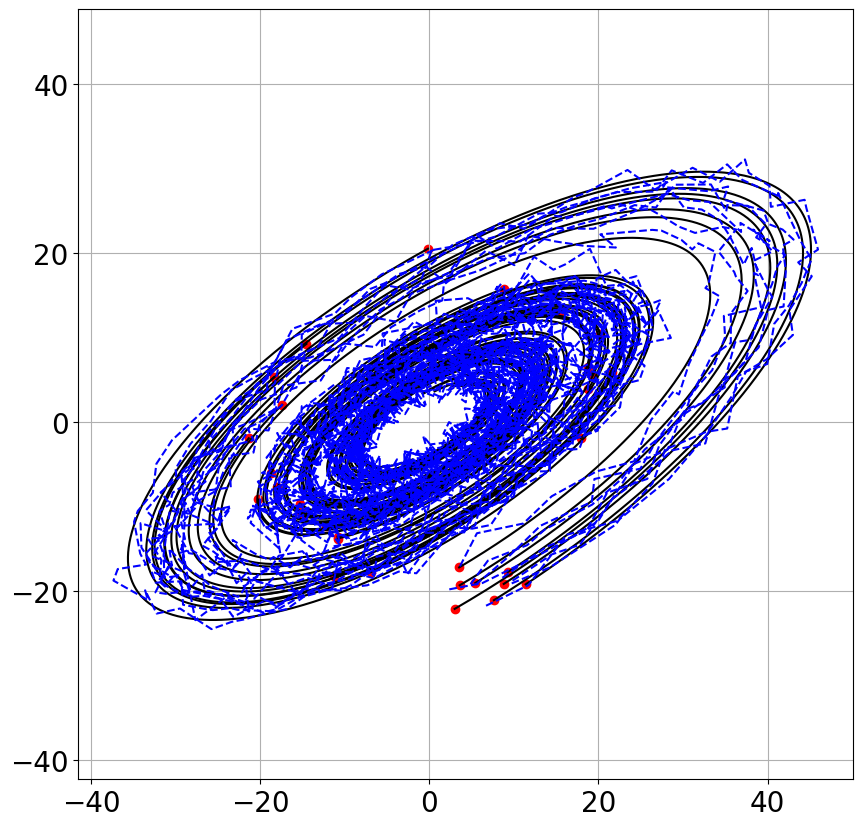

In [15]:
# PLOT ALL TRAJECTORIES

from matplotlib import patches
fig, ax = plt.subplots()

for it, (train_data, X_true, X_measure, t_measure_full) in enumerate(train_loader):
#     for i in range(args.batch_size):

#     if X_true.size()[2] == 1:
#         X_true = torch.stack((X_true, torch.zeros_like(X_true)),dim=2)
#         X_measure = torch.stack((X_measure, torch.zeros_like(X_measure)),dim=2)

    # Actual trajectory
    X_true_plt = X_true.squeeze().detach().cpu().numpy()
    plt.plot(X_true_plt.T[0],X_true_plt.T[1],'black')

    # Noisy trajectory
    traj = X_measure.detach().cpu().squeeze().numpy()
    plt.plot(traj.T[0], traj.T[1], 'b--')
    
    x0 = X_true_plt[:,0].T
    plt.scatter(x0[0],x0[1], color='red')

#     circle = patches.Circle((0,0), 17.0, edgecolor='red', facecolor='none', linewidth = 2)
#     ax.add_patch(circle)

    plt.axis('equal')
    plt.grid()
    plt.show()

In [16]:
# Iterate through training data
for it, (train_data, X_true, X_measure, t_measure_full) in enumerate(train_loader):
    break
    
# Outputs are one index ahead of inputs
inputs  = train_data[:, :, :-1]
outputs = train_data[:, :, 1:]

# rand_idx = np.random.choice(args.num_samp)
# # _, _, _, t_measure = train_dataset.__getitem__(rand_idx)
# train_data, X_true, X_measure, t_measure = train_dataset.__getitem__(rand_idx)
# inputs = train_data[:, :-1].unsqueeze(0)

inputs.size()
est, out, Q_ij_tot, Z_ij_hat_all, epoch_lambdas = model(inputs, t_measure_all)

print(out.size())
print(Z_ij_hat_all.size())
print(epoch_lambdas.size())

print(Q_ij_tot.size())

for head in range(Q_ij_tot.size()[-1]):
    Q_ij = Q_ij_tot[:,:,:,:,head]

torch.Size([32, 2, 101, 128])
torch.Size([32, 2, 101, 101, 128])
torch.Size([2, 1, 128, 1])
torch.Size([32, 2, 101, 101, 2])


Training progress...:   0%|▏                                                          | 4/1000 [00:03<13:38,  1.22it/s]

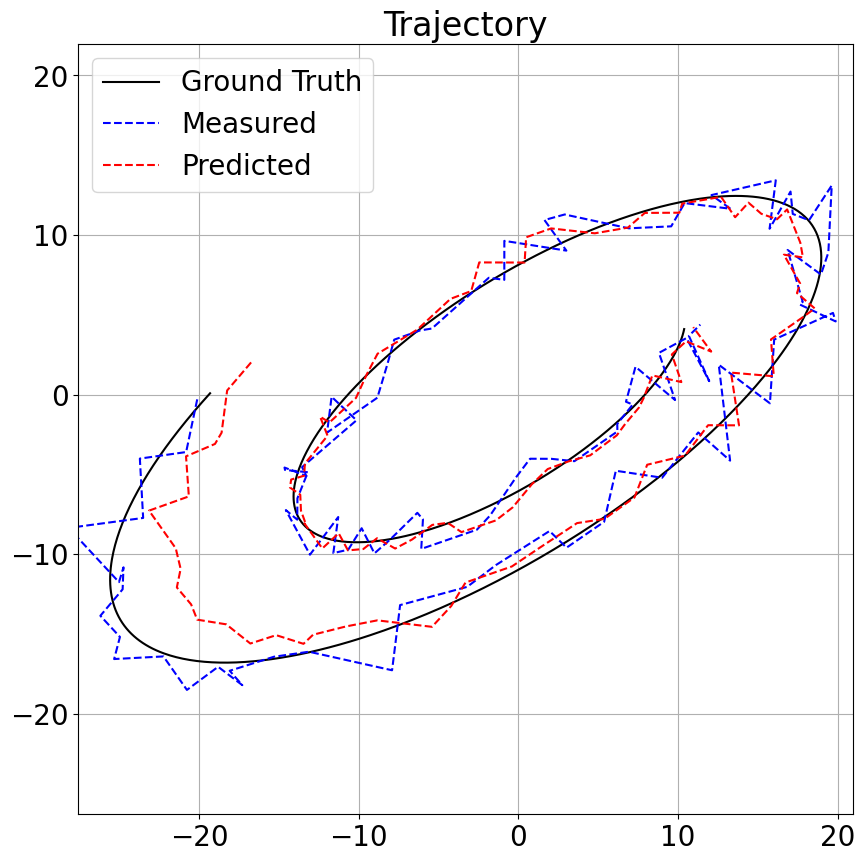

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


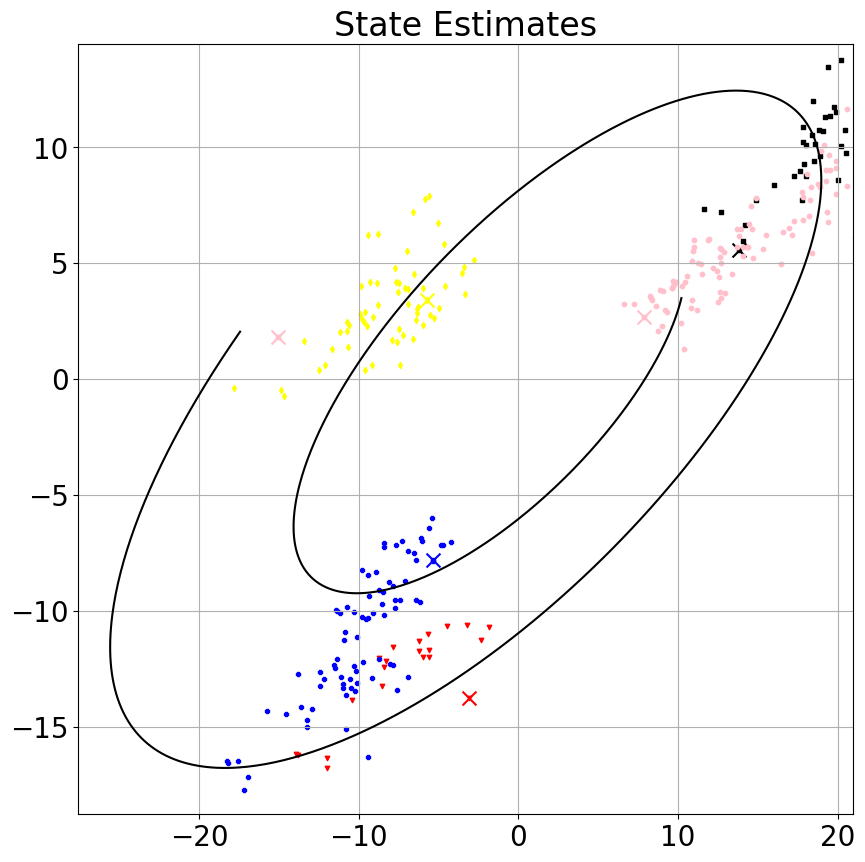

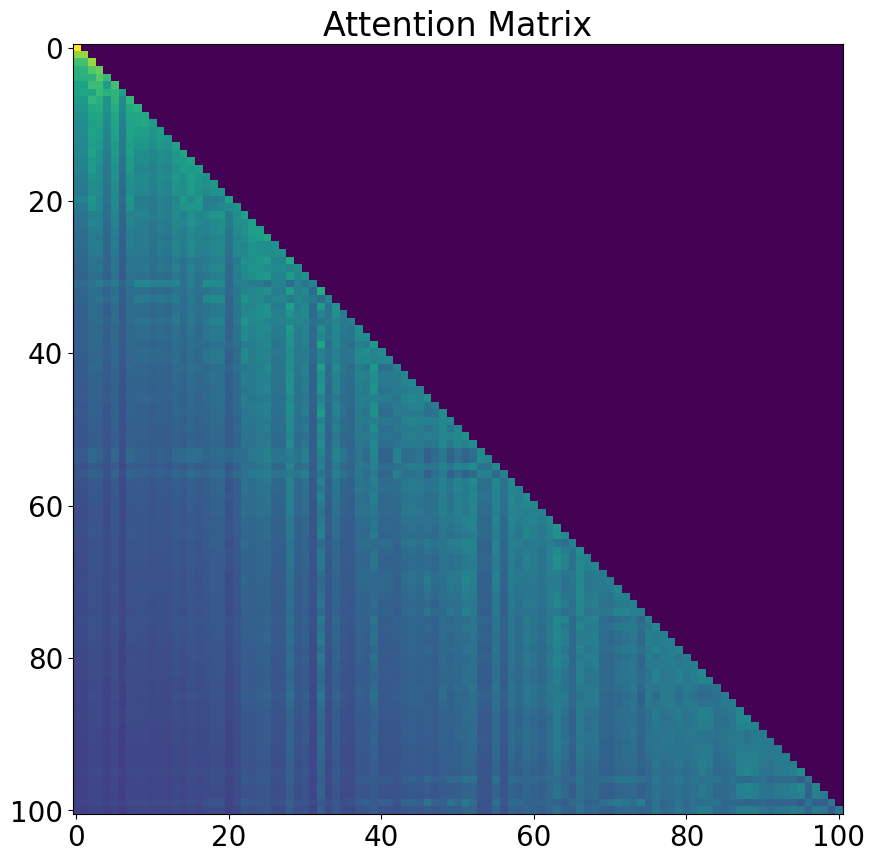

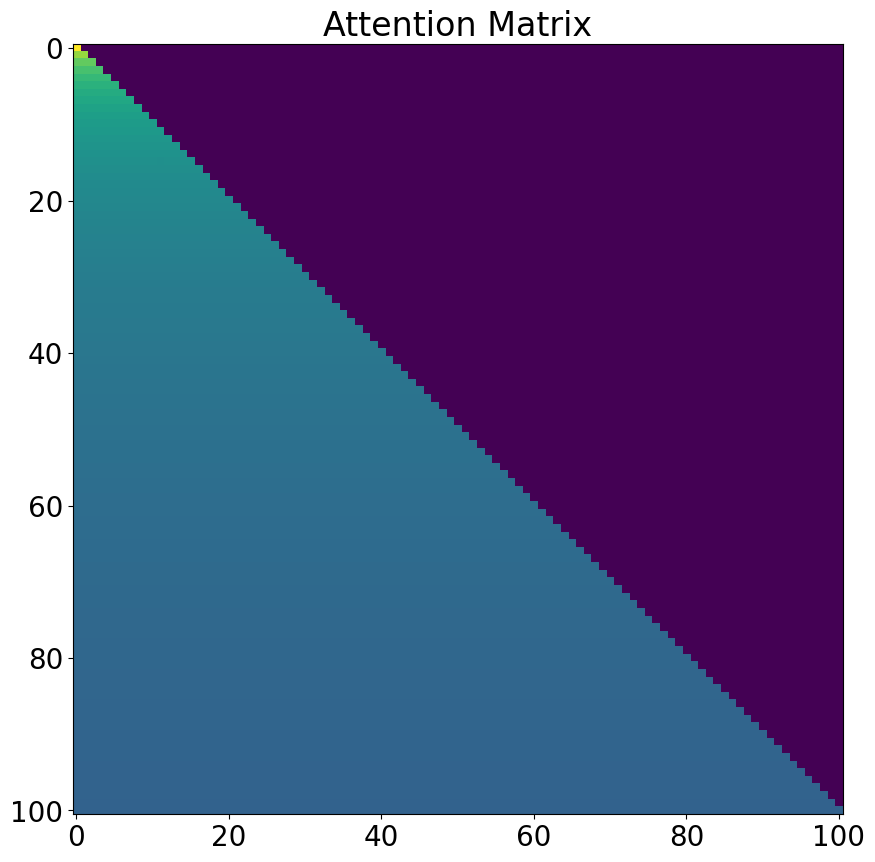

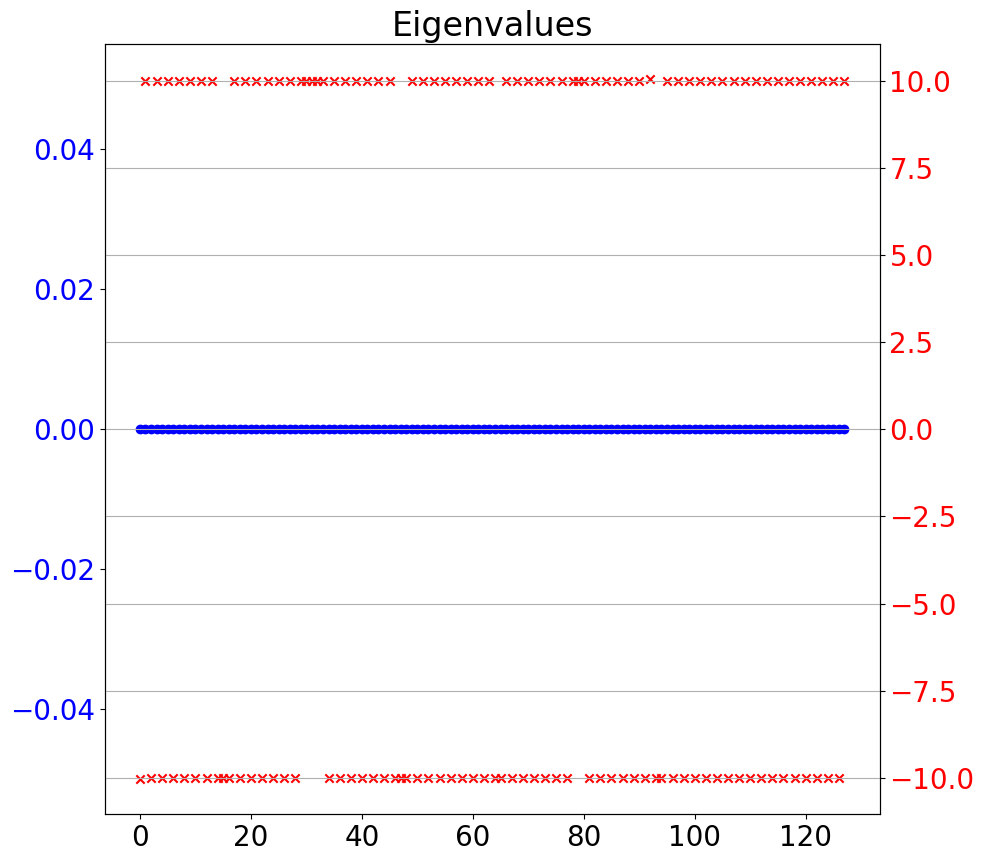

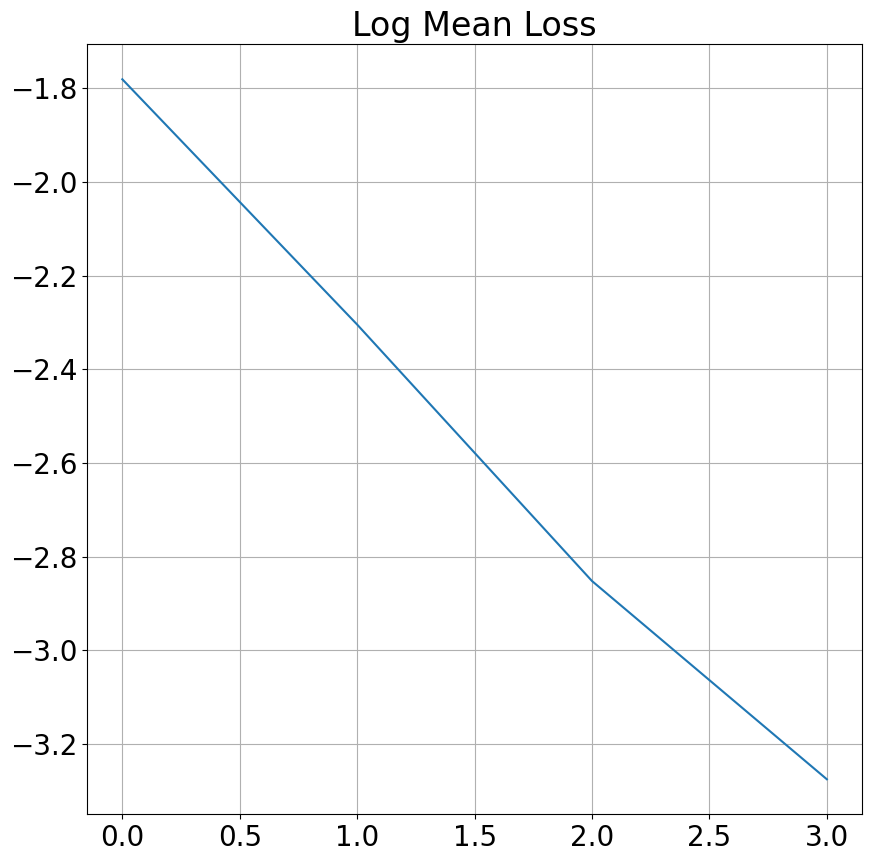

Training progress...:   1%|▌                                                          | 9/1000 [00:08<14:48,  1.12it/s]

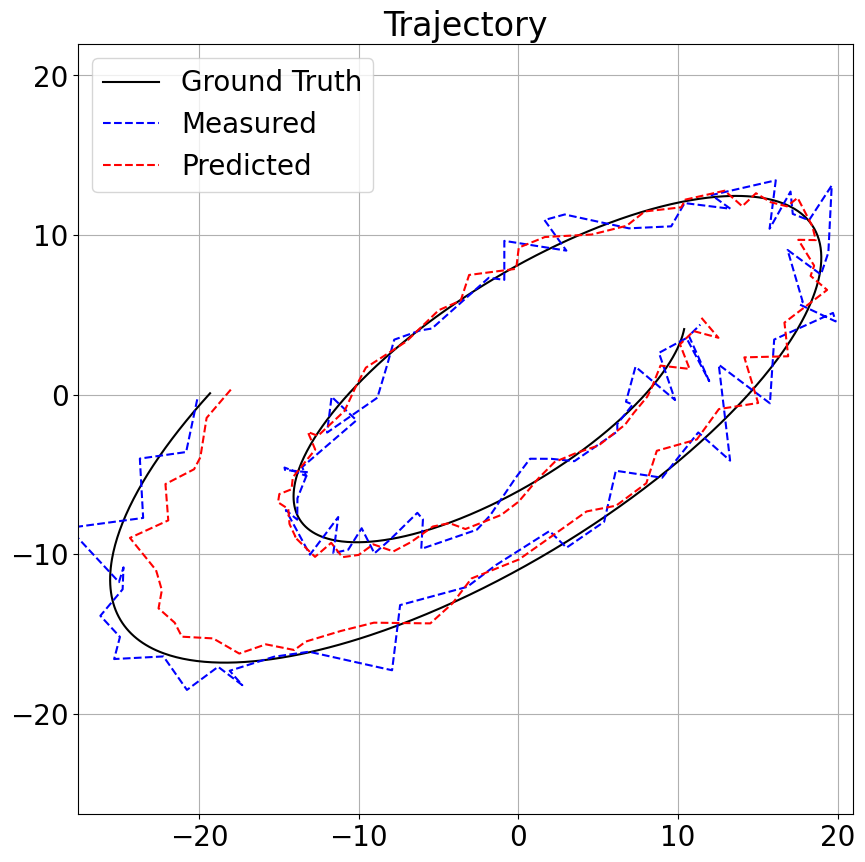

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


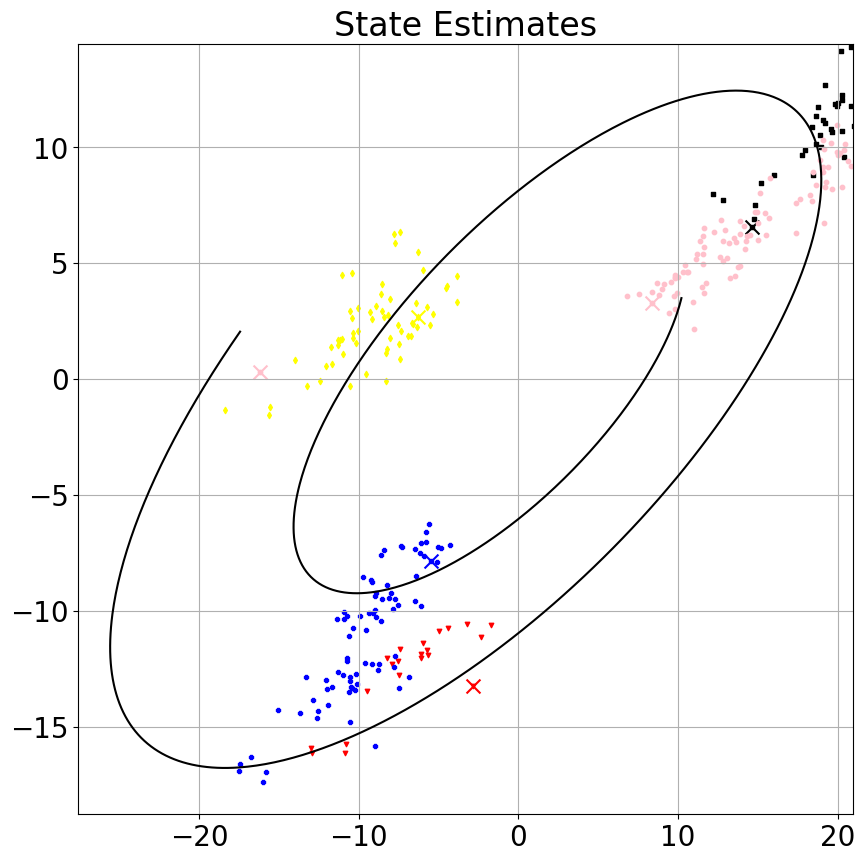

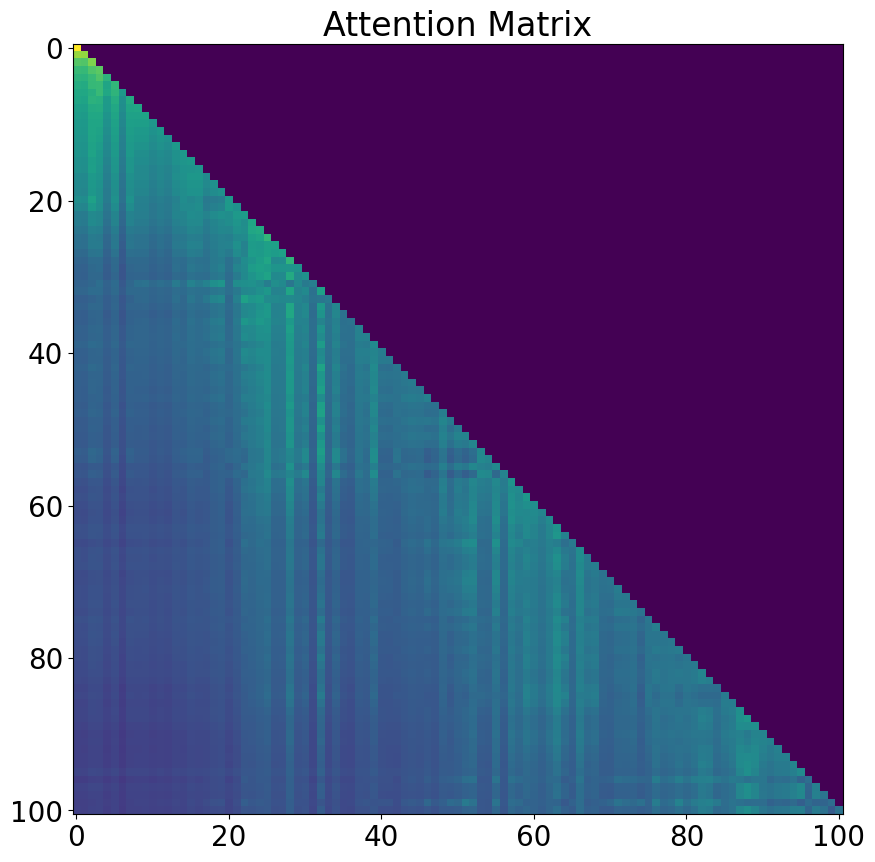

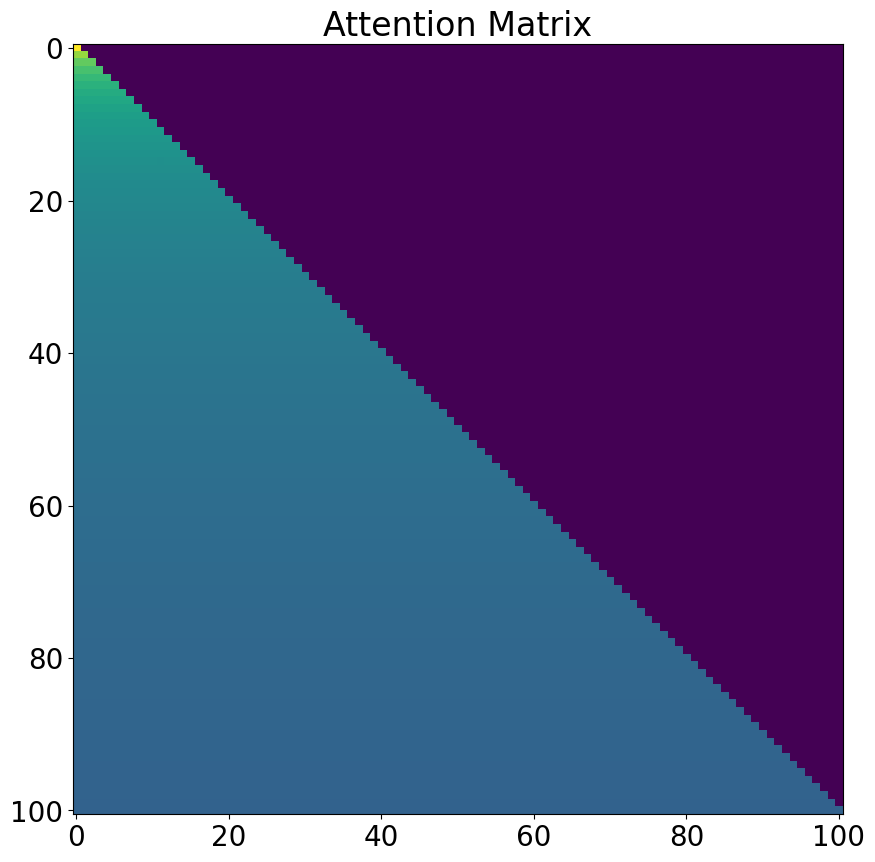

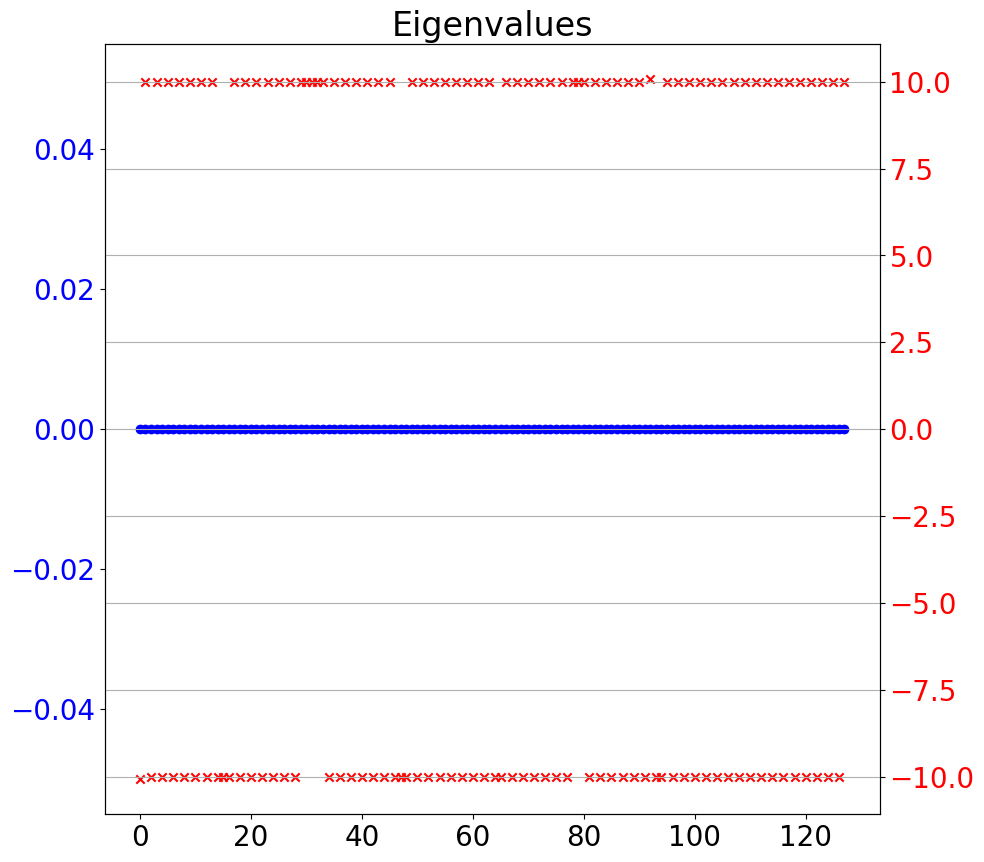

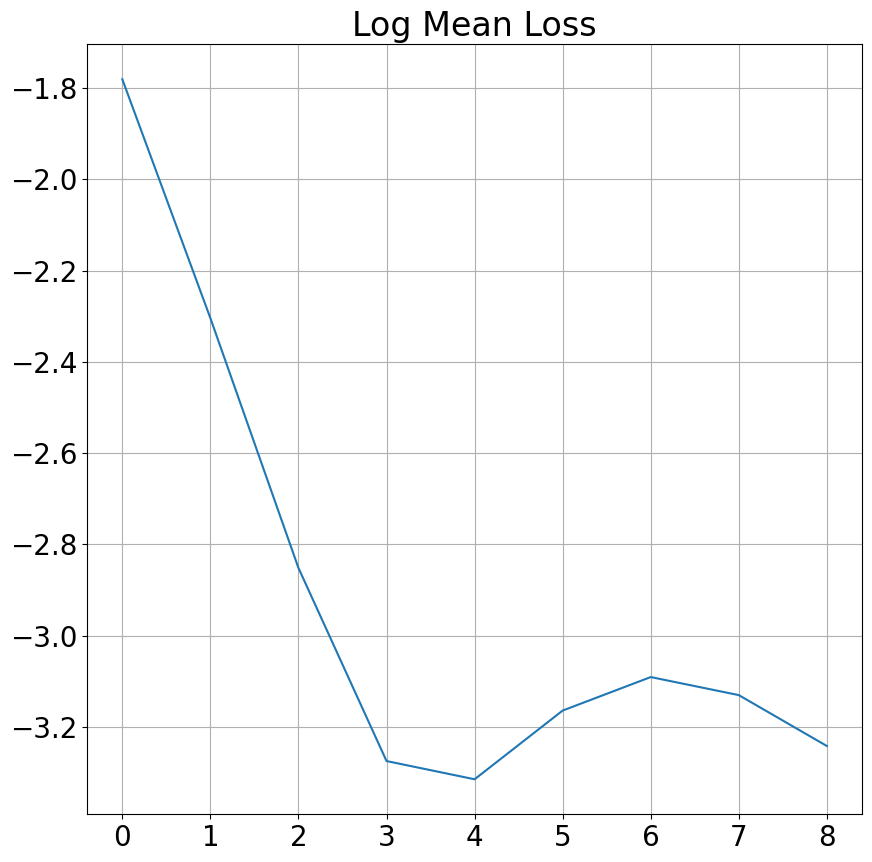

Training progress...:   1%|▊                                                         | 14/1000 [00:13<14:58,  1.10it/s]

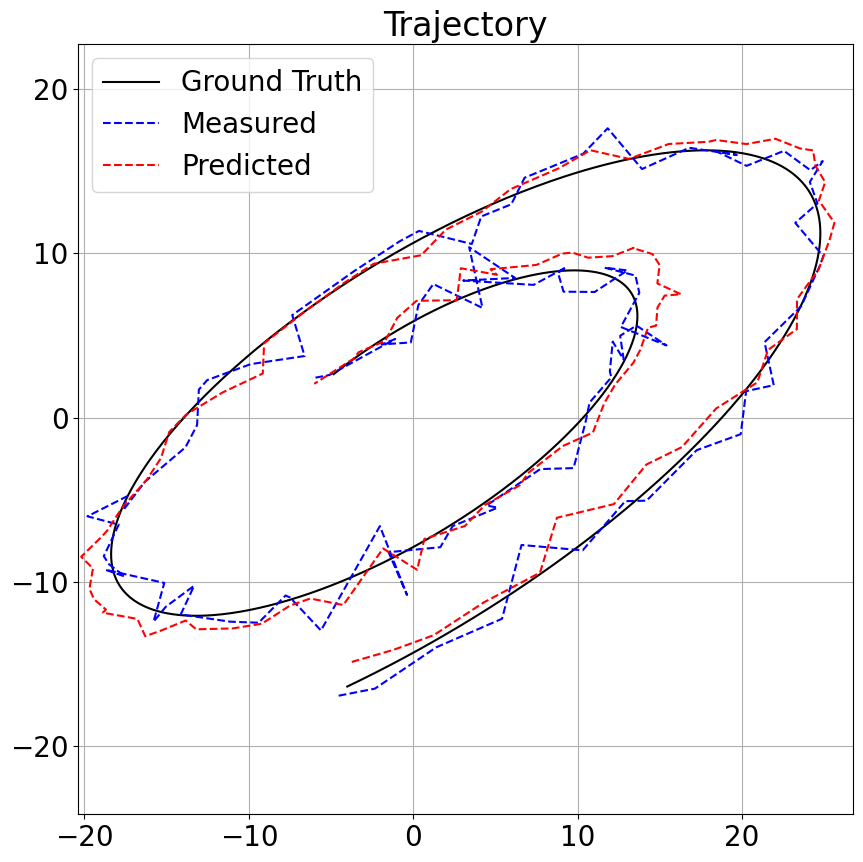

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


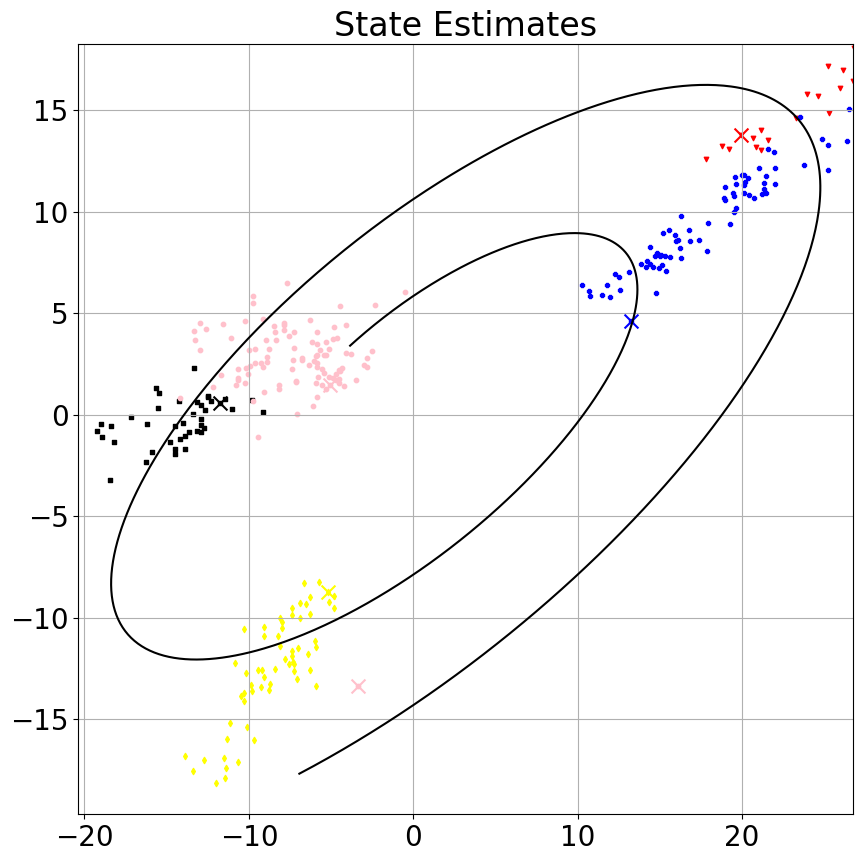

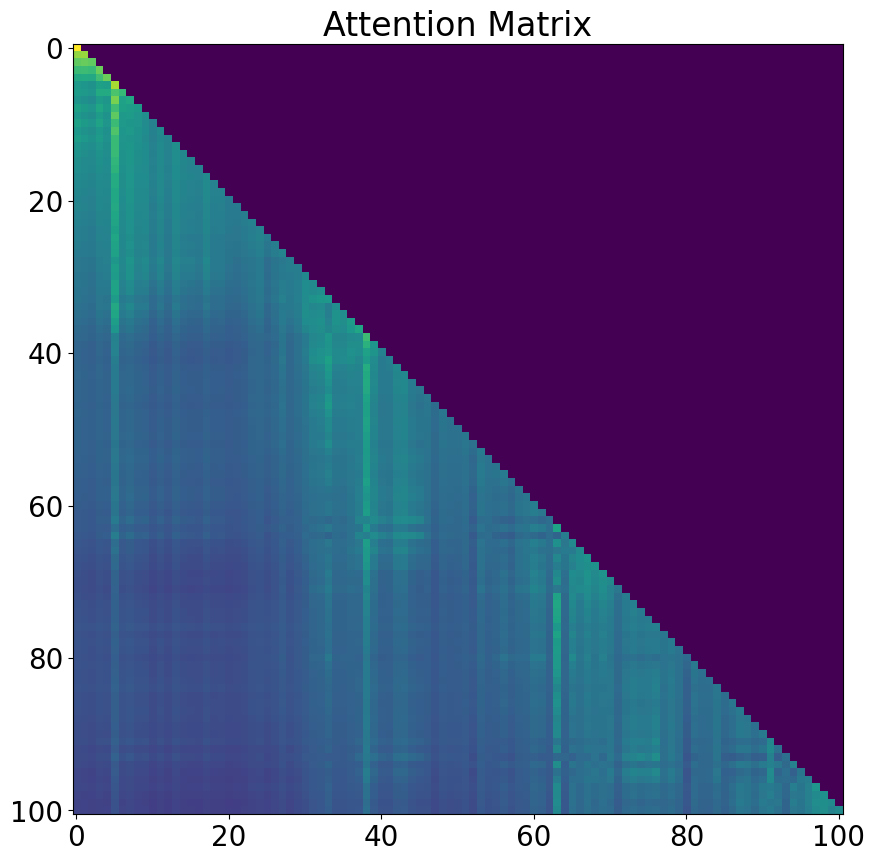

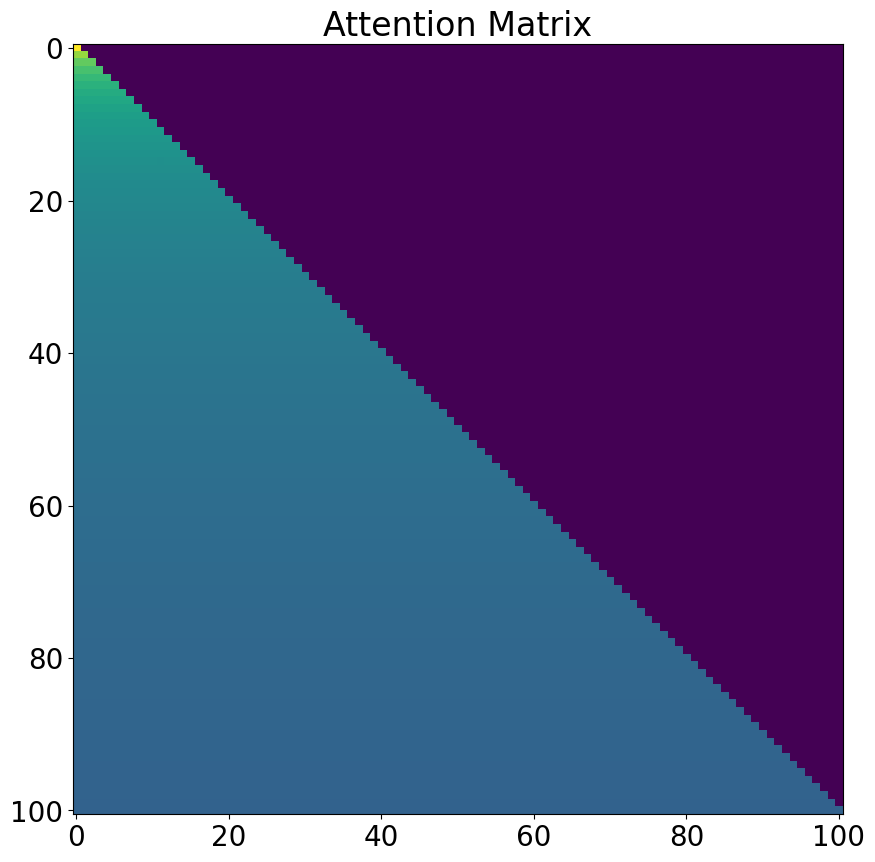

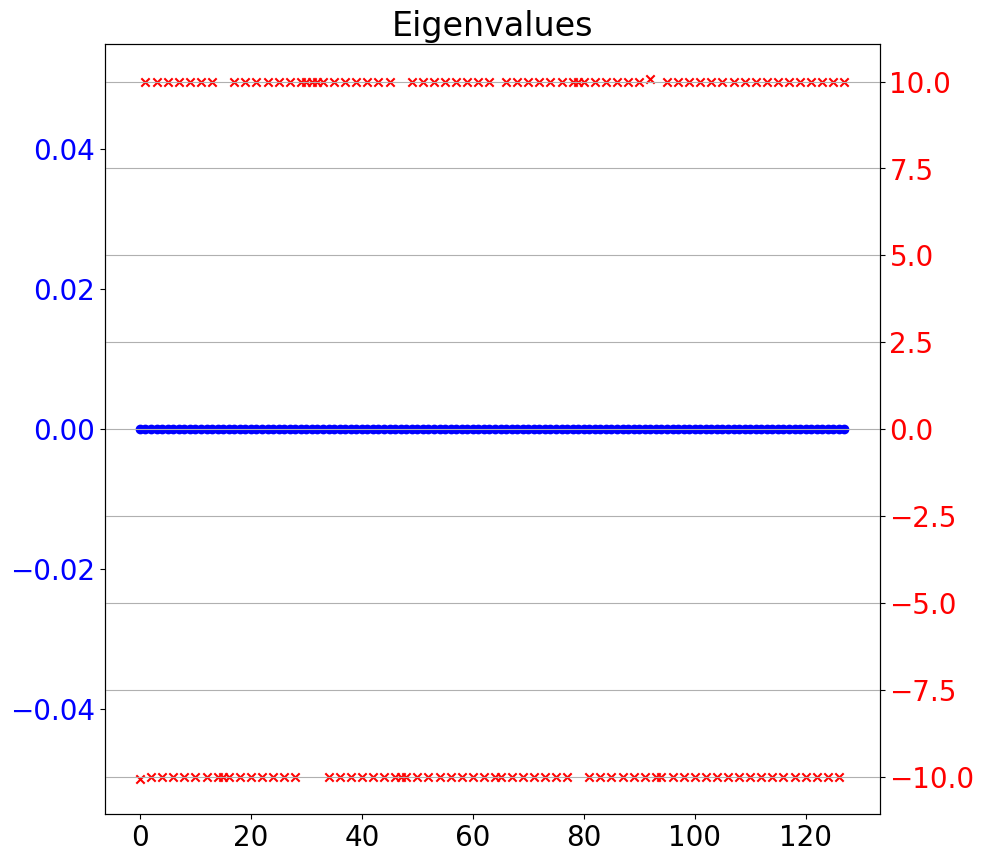

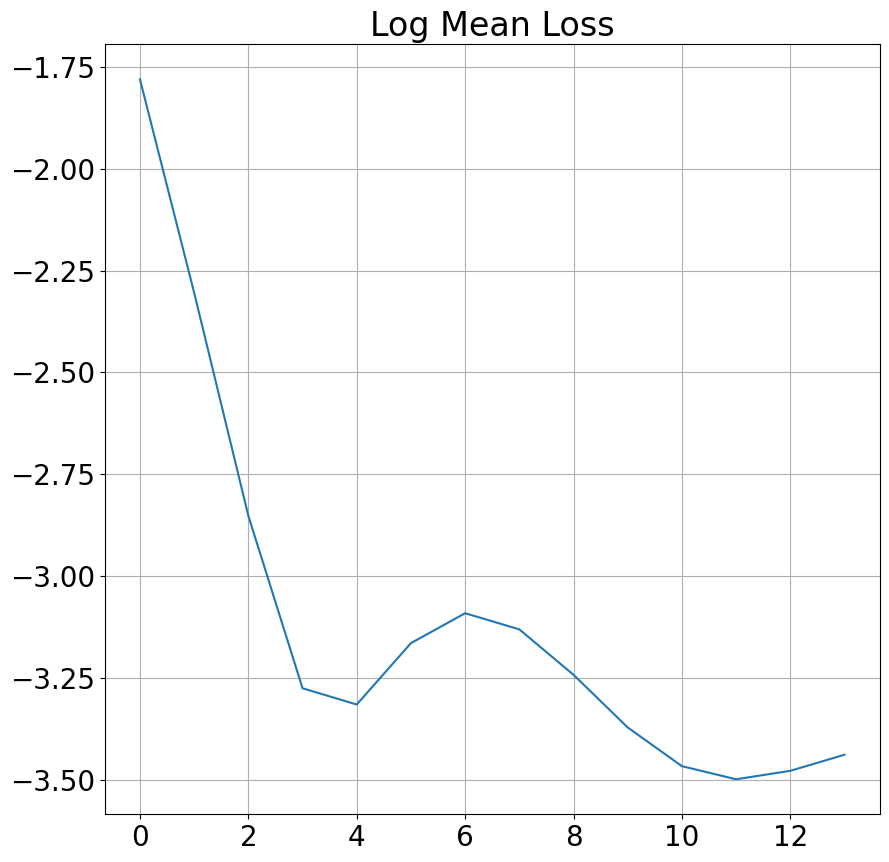

Training progress...:   2%|█                                                         | 19/1000 [00:19<15:00,  1.09it/s]

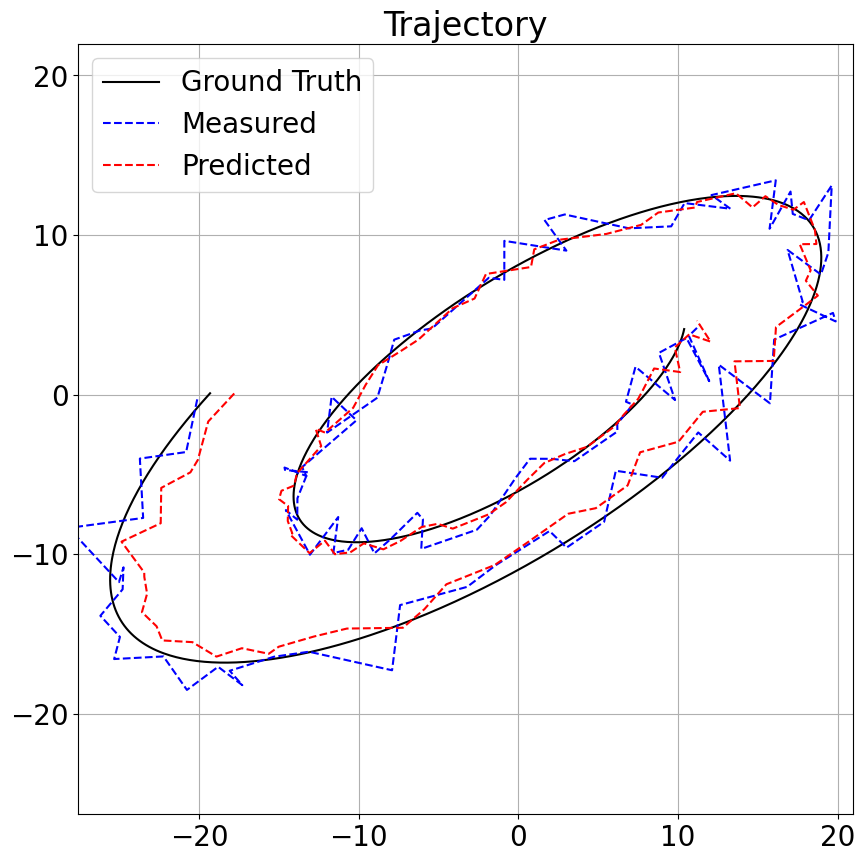

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


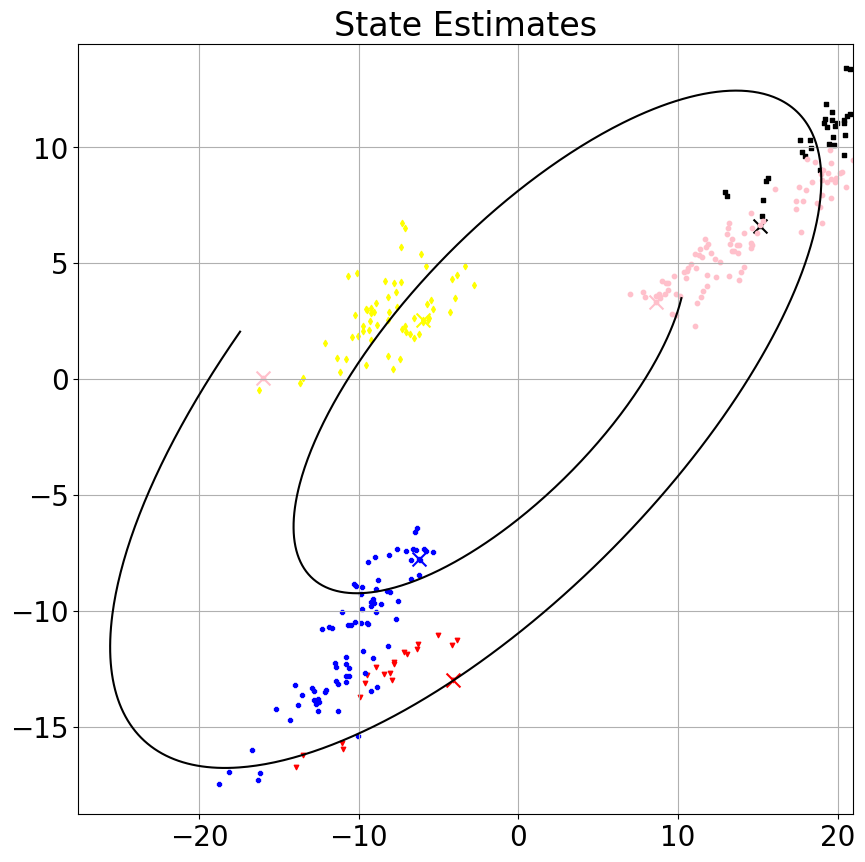

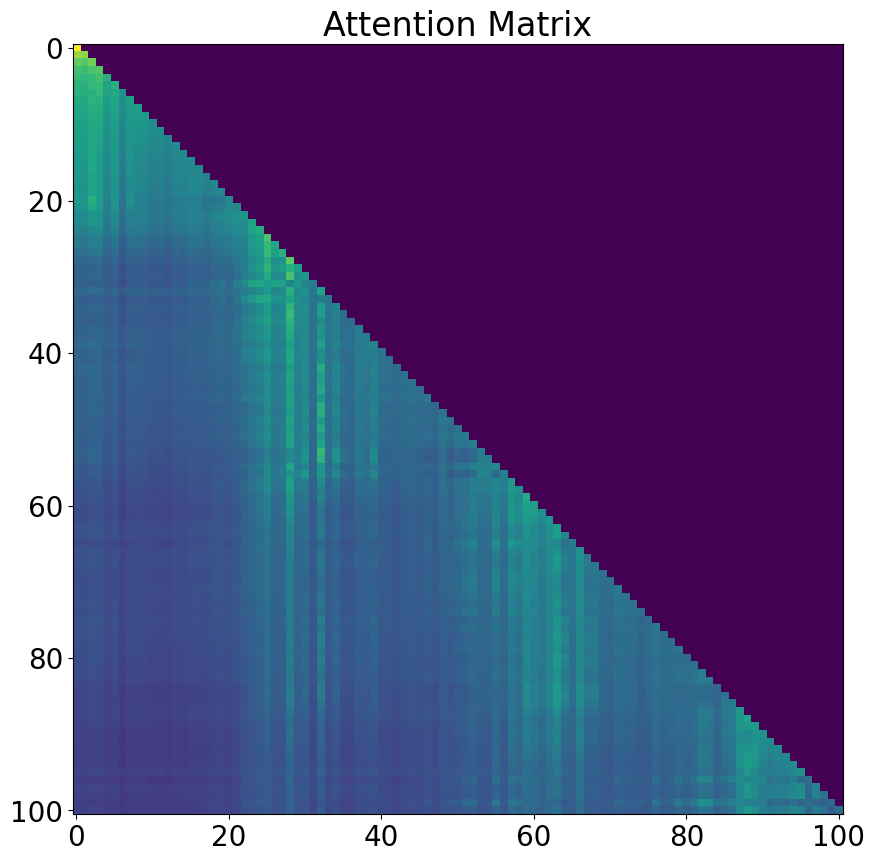

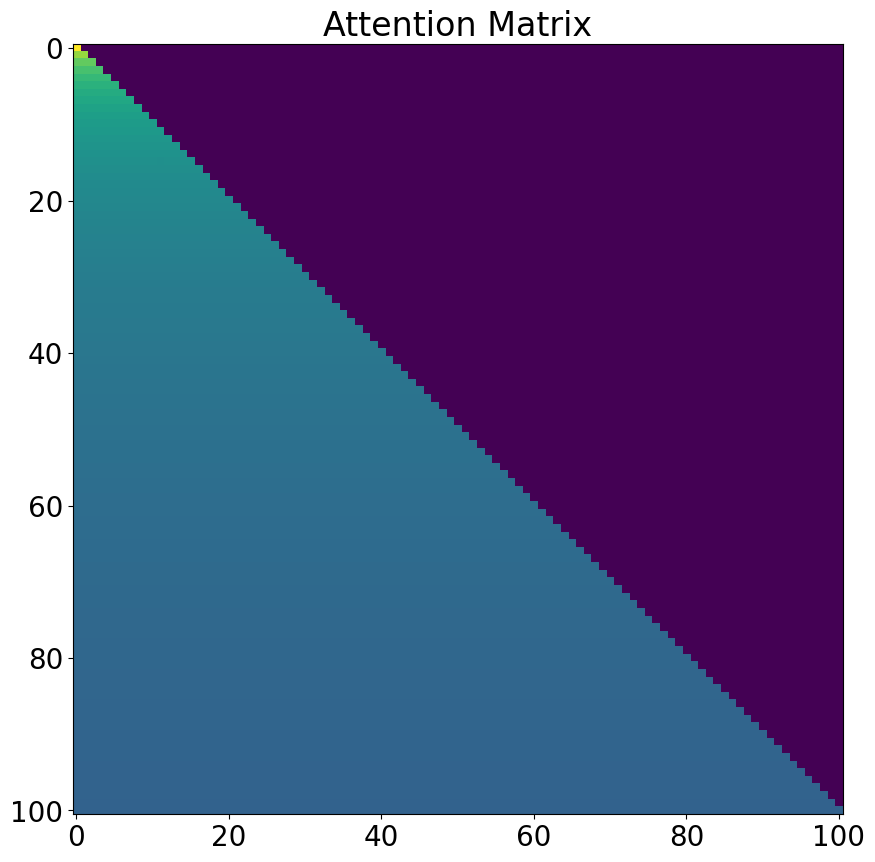

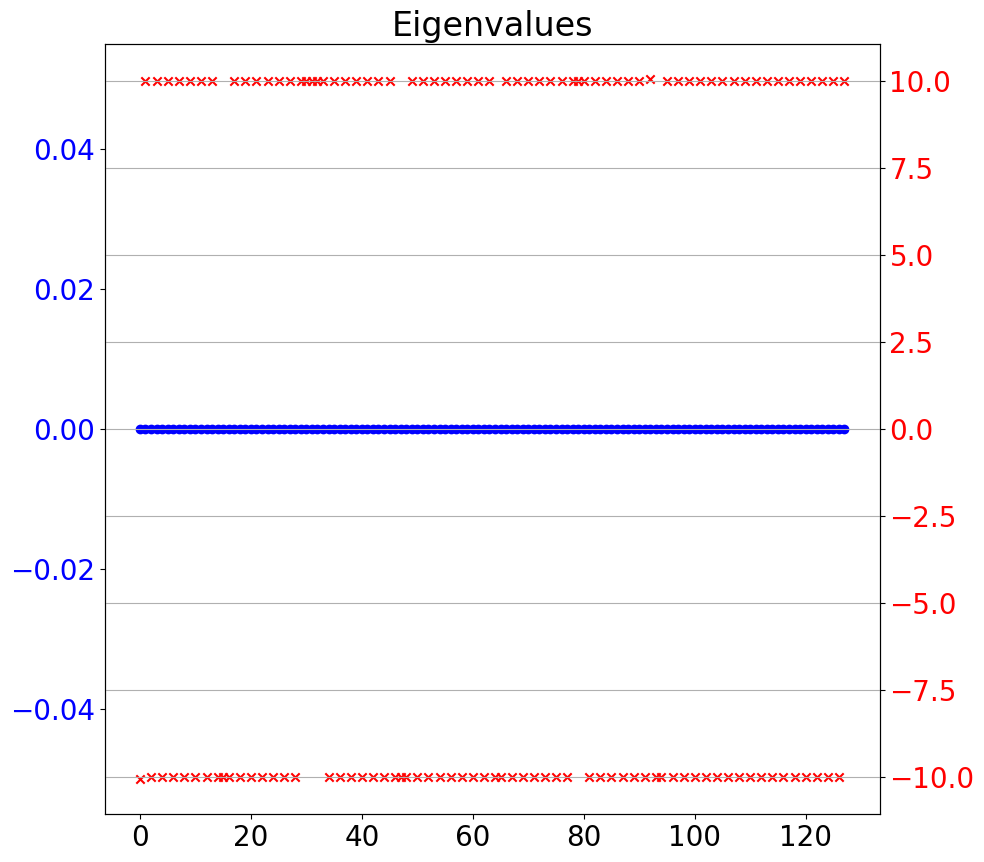

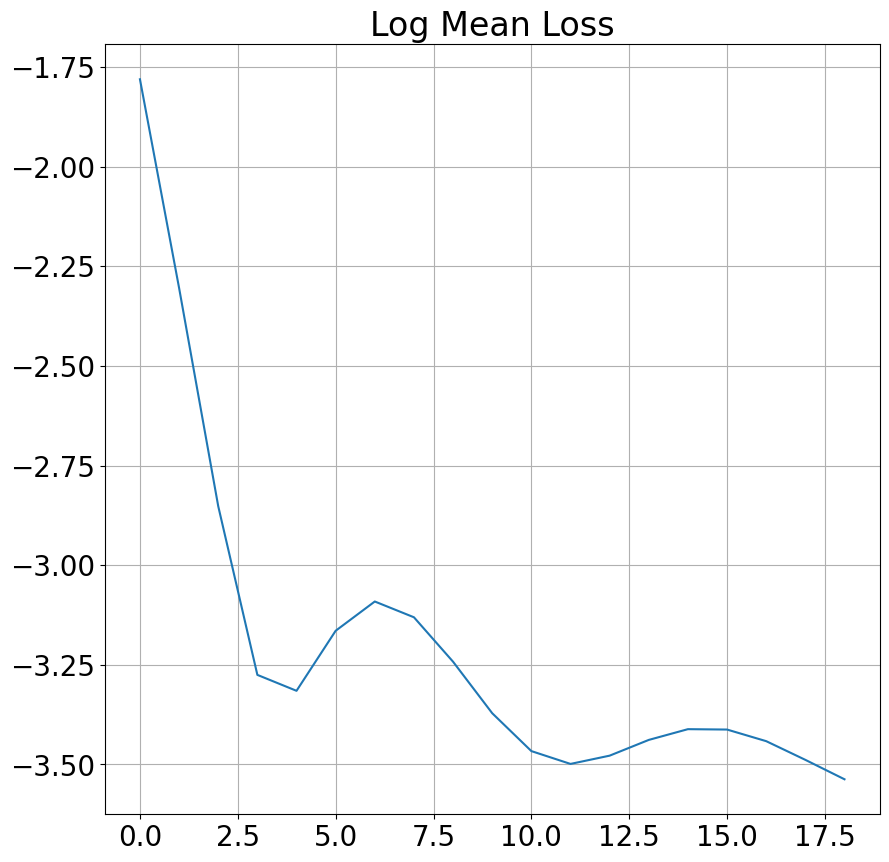

Training progress...:   2%|█▍                                                        | 24/1000 [00:24<15:05,  1.08it/s]

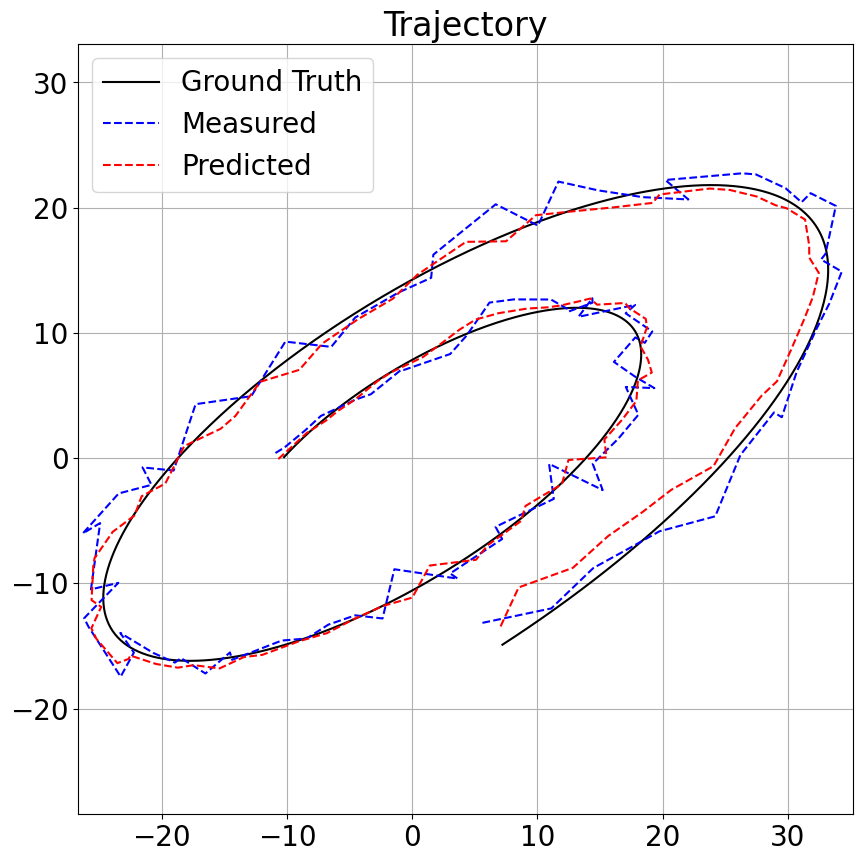

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


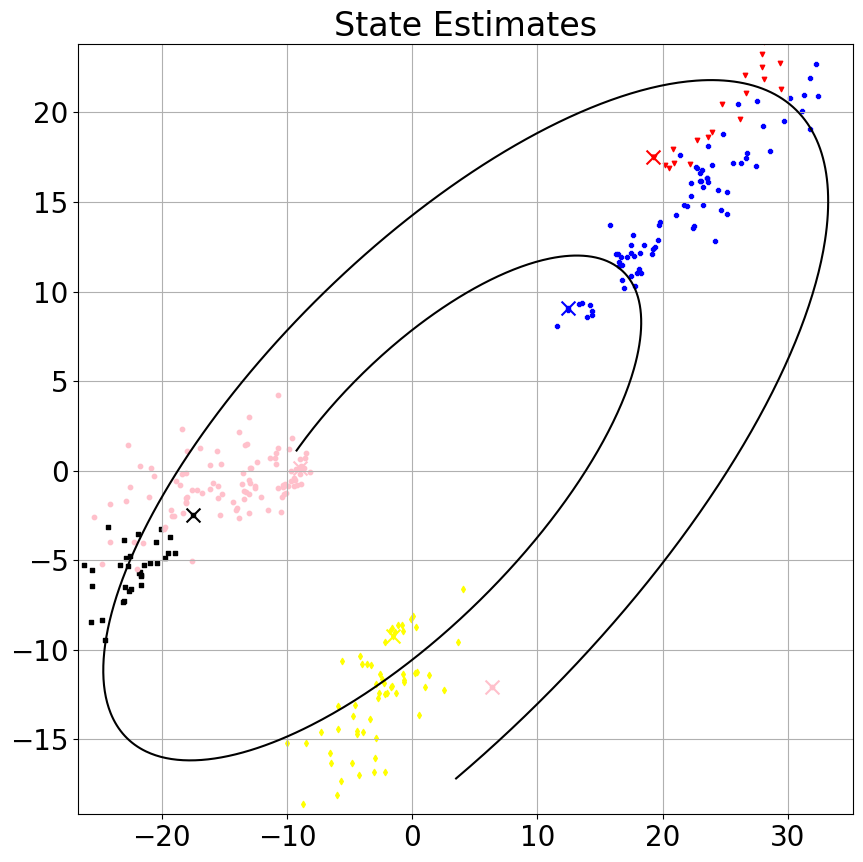

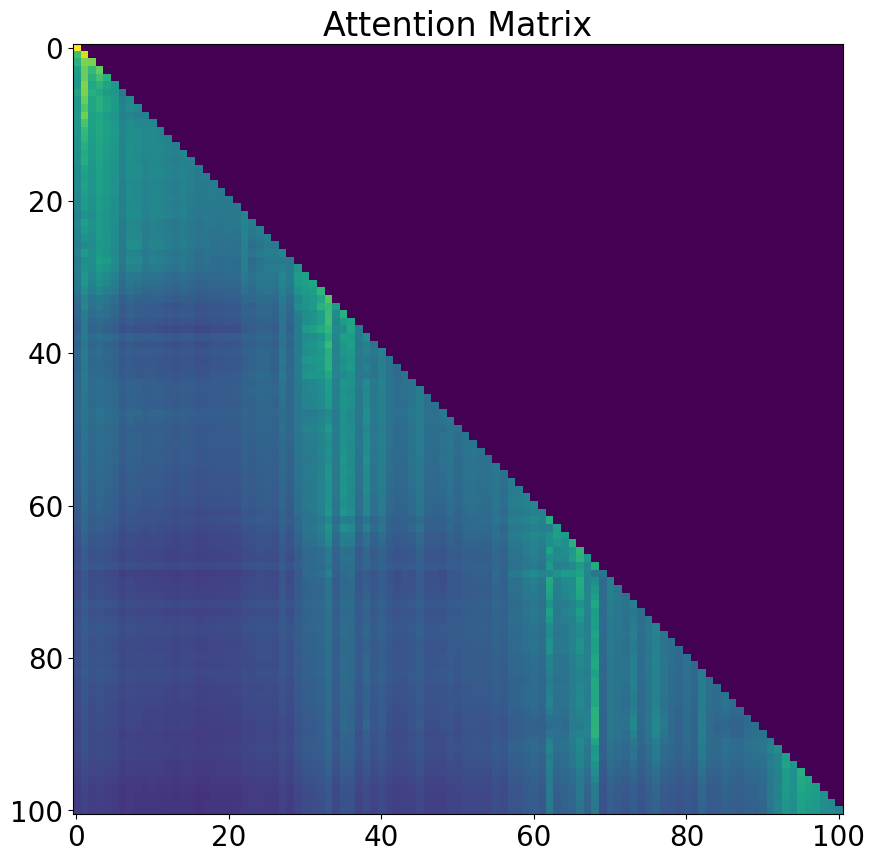

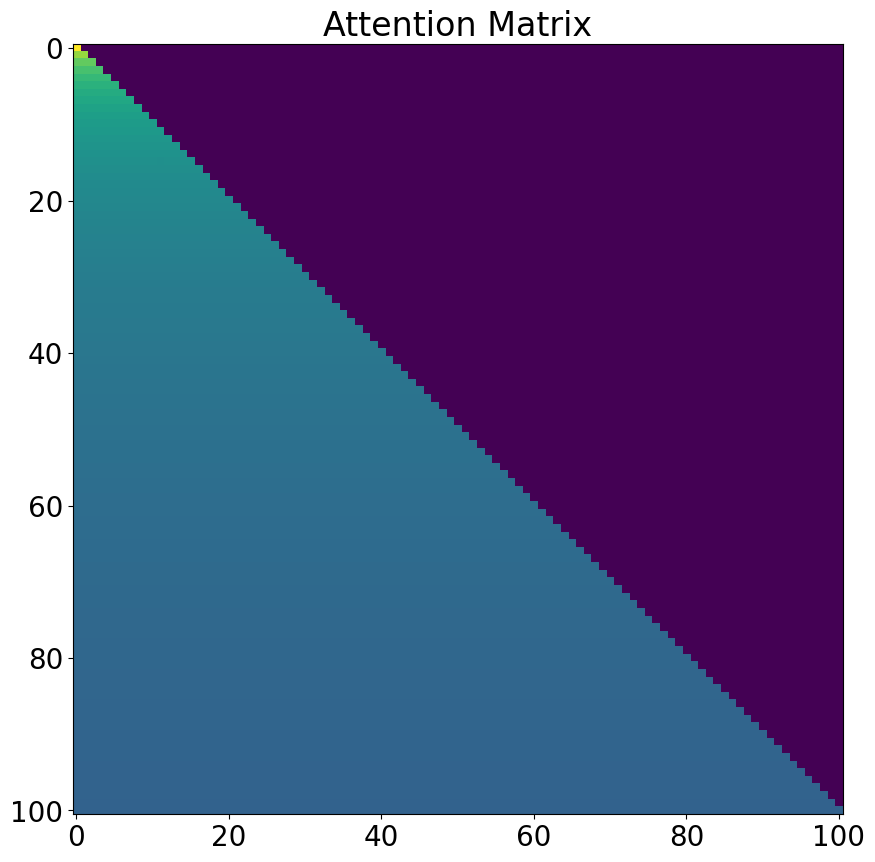

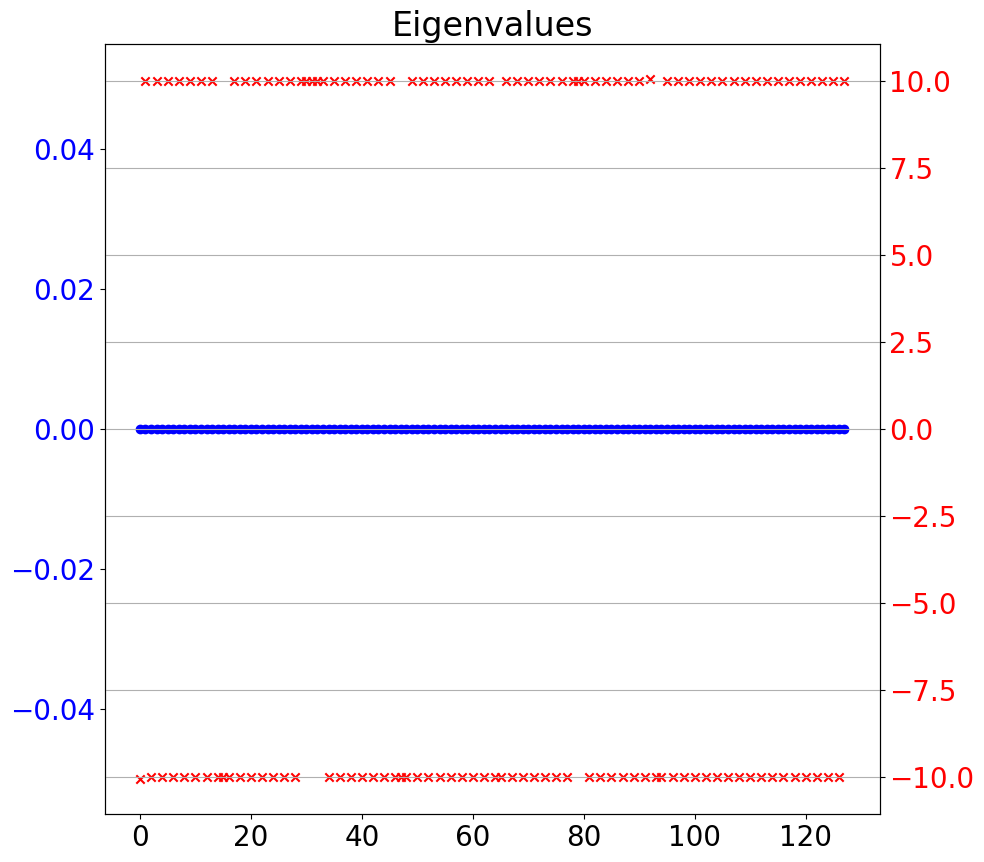

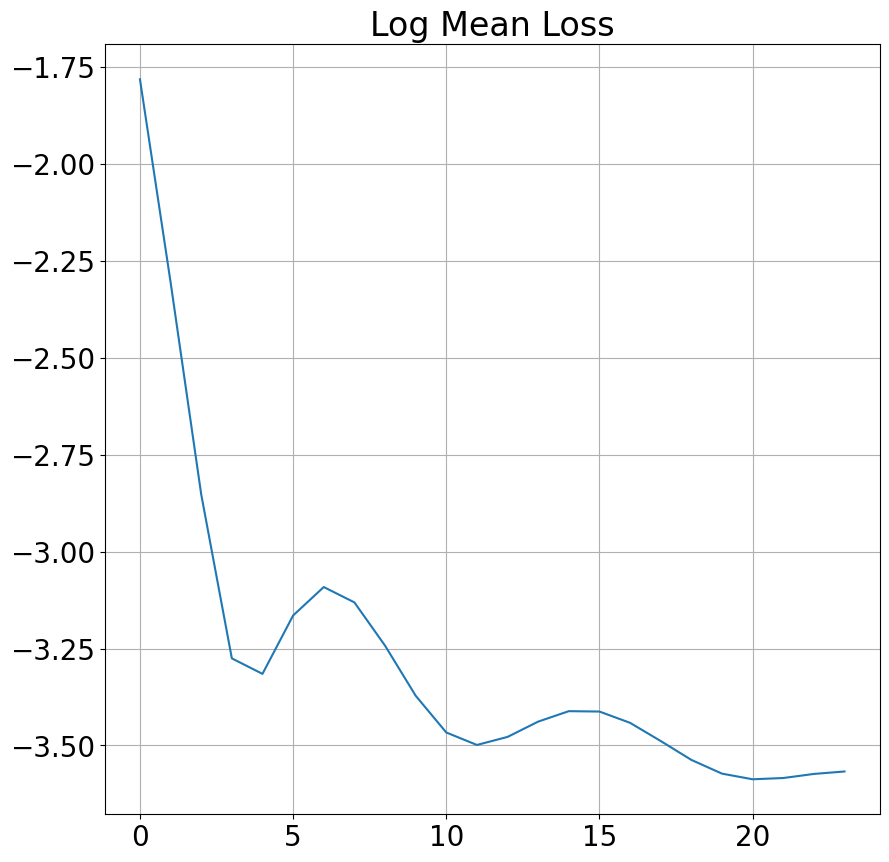

Training progress...:   3%|█▋                                                        | 29/1000 [00:30<14:53,  1.09it/s]

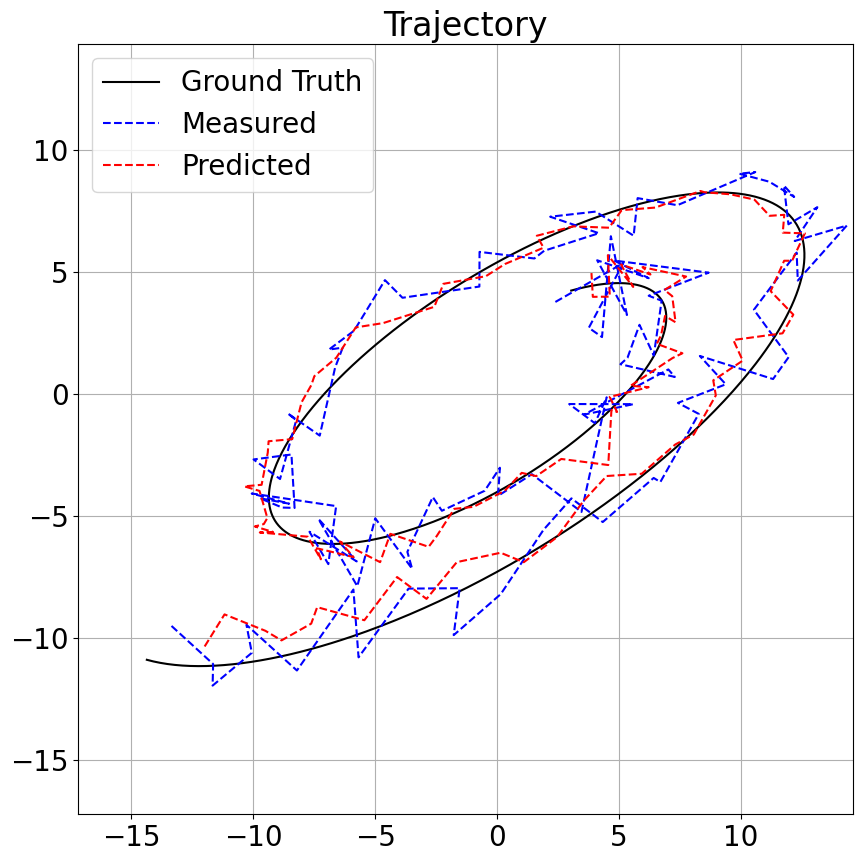

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


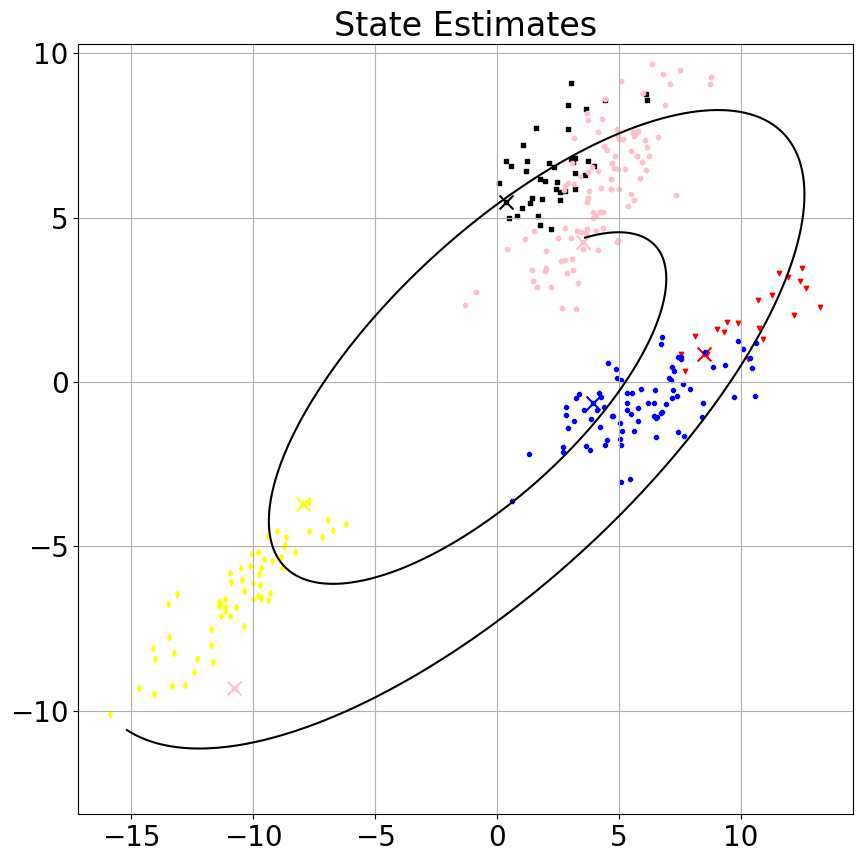

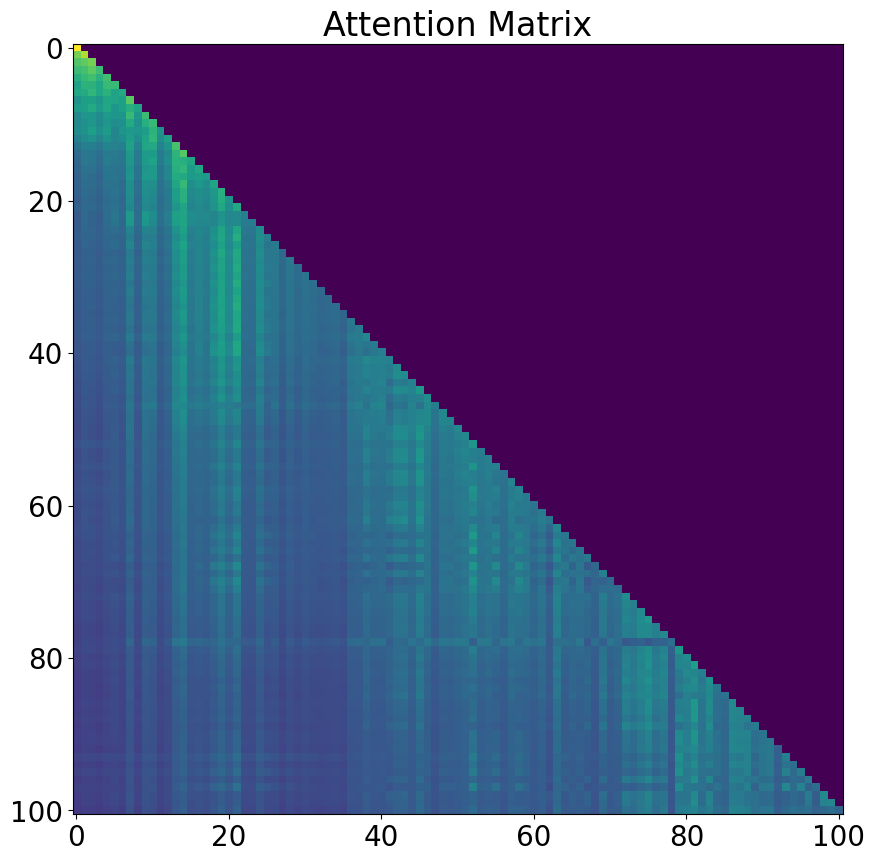

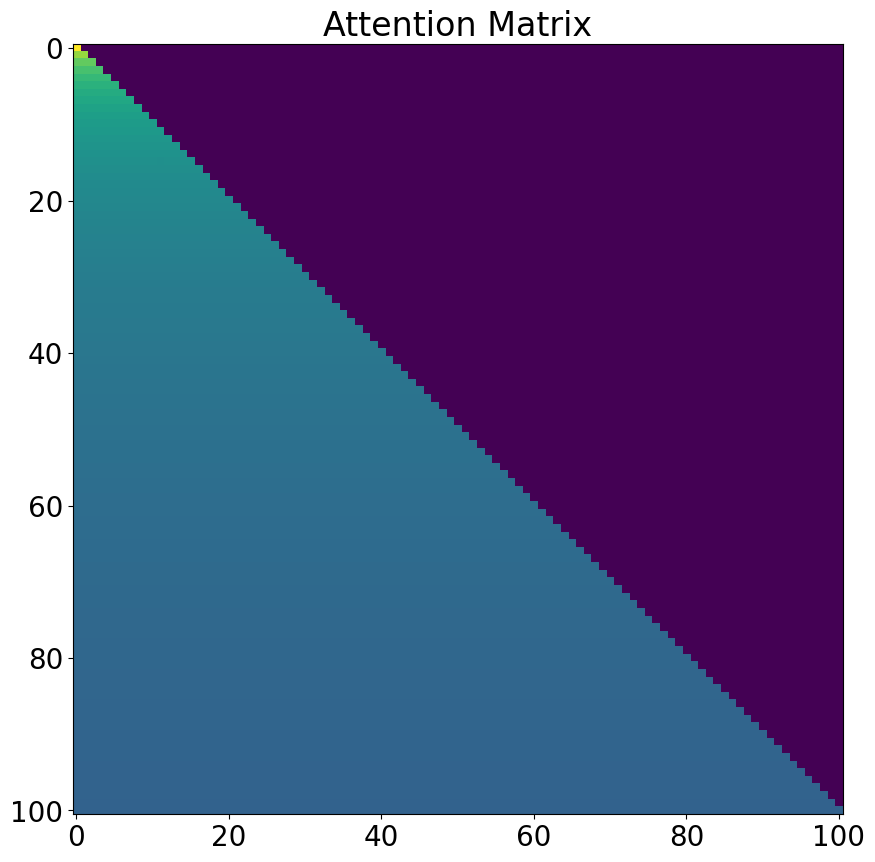

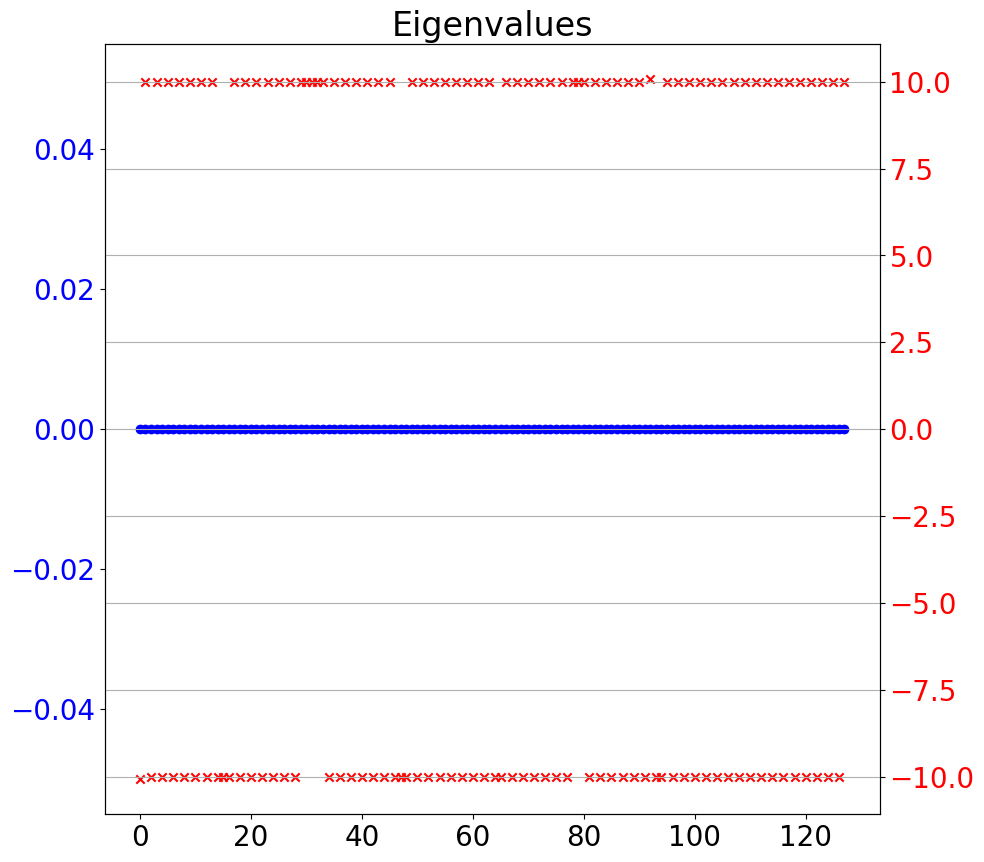

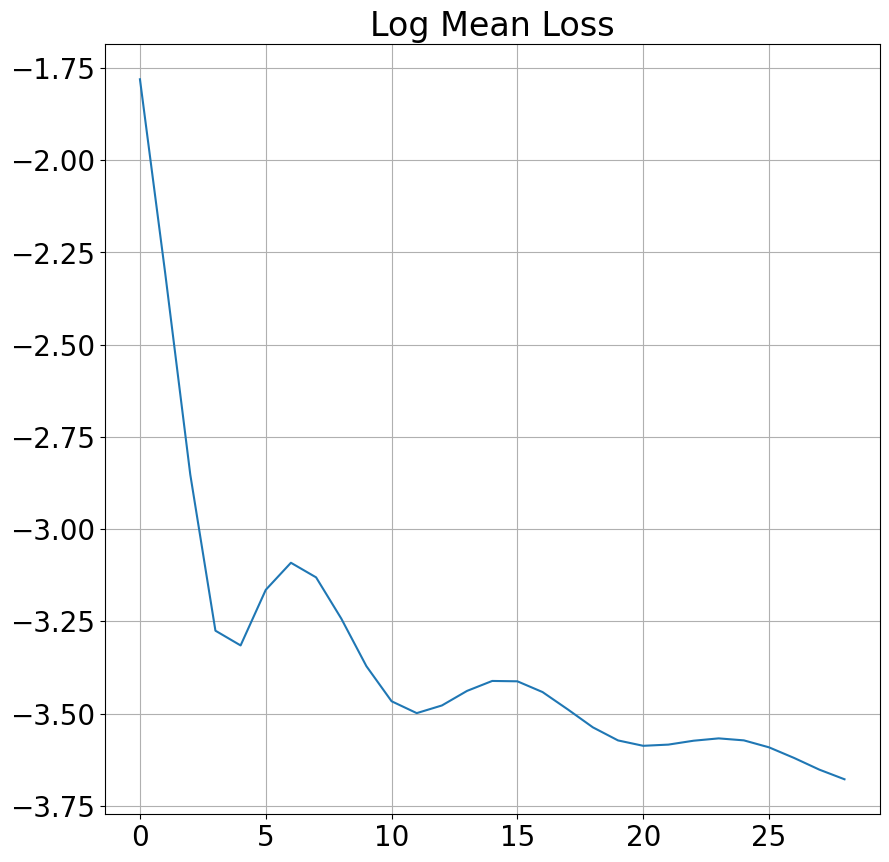

Training progress...:   3%|█▉                                                        | 34/1000 [00:35<14:46,  1.09it/s]

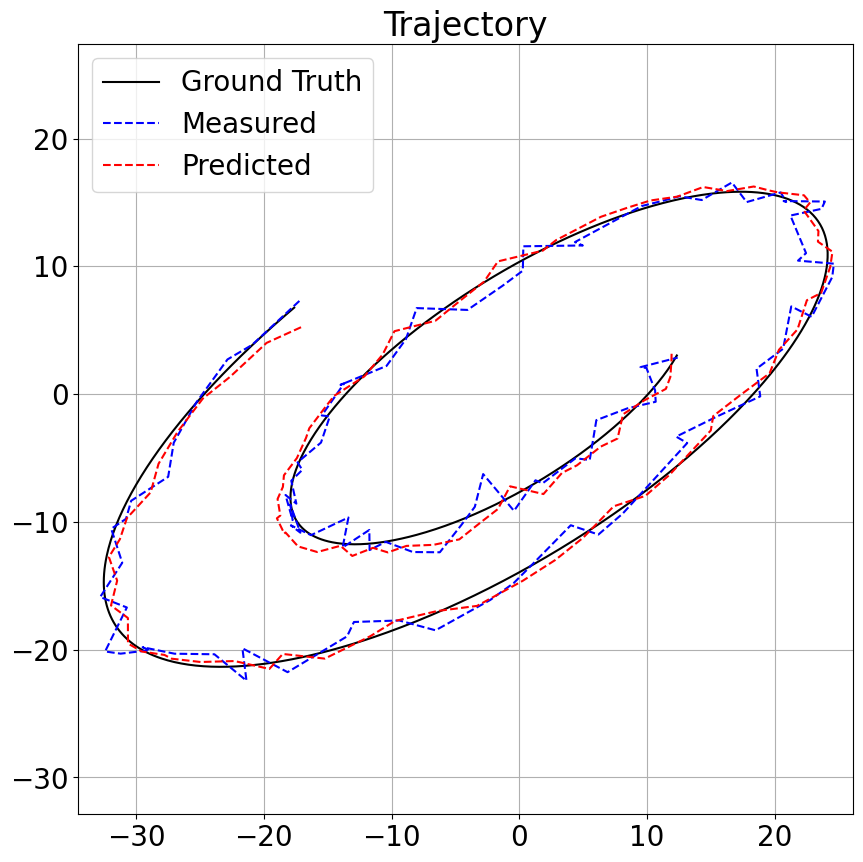

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


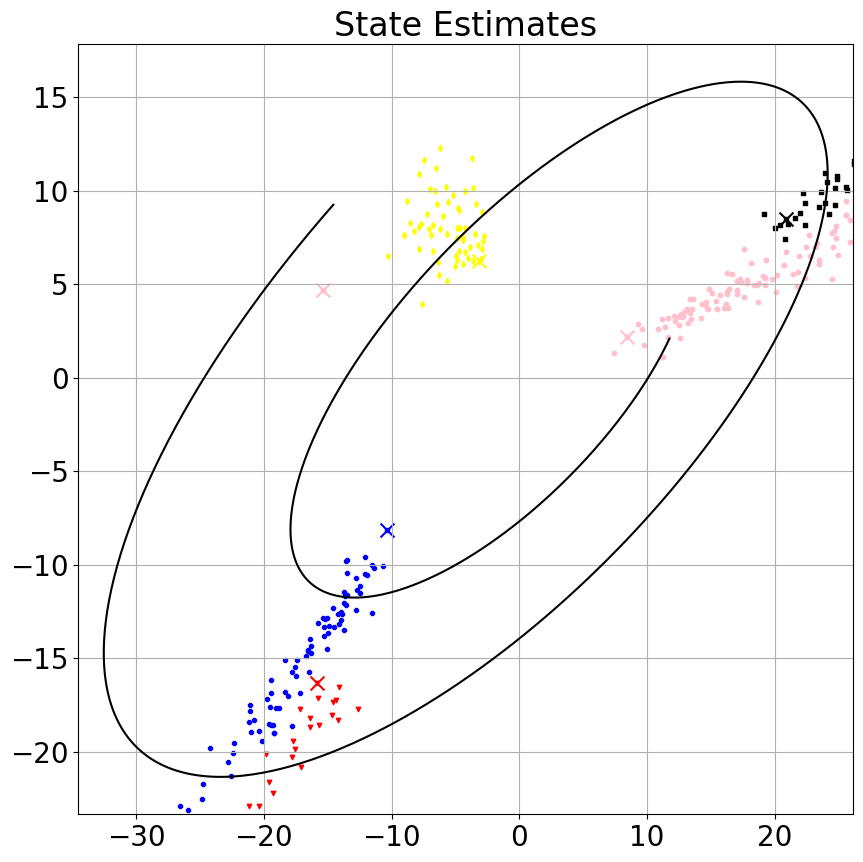

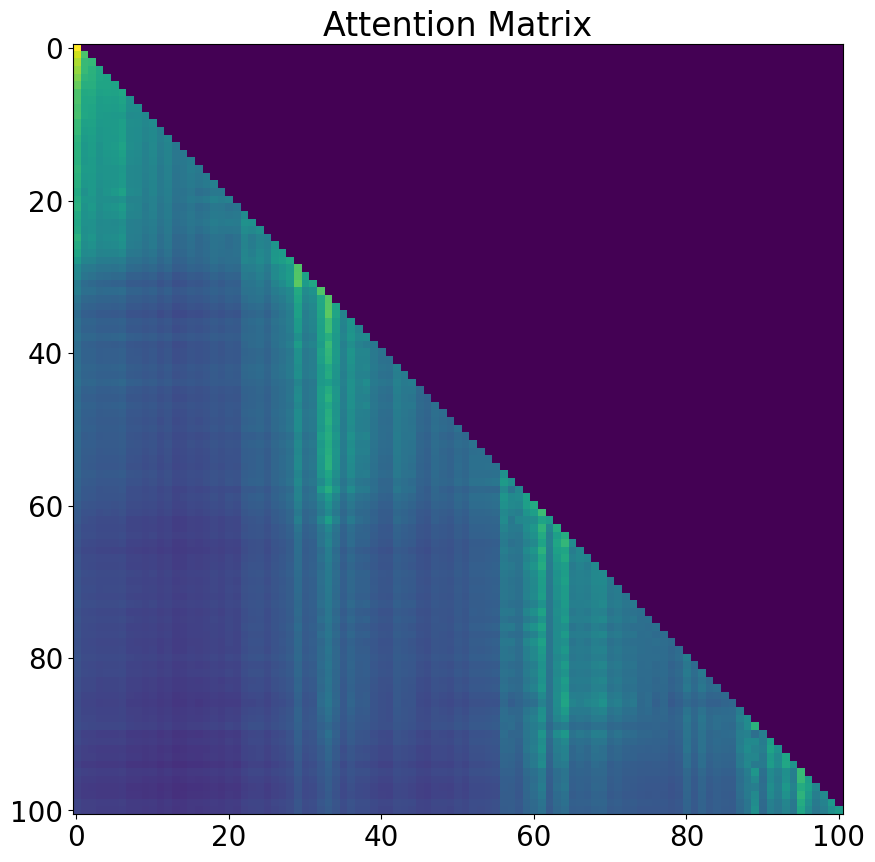

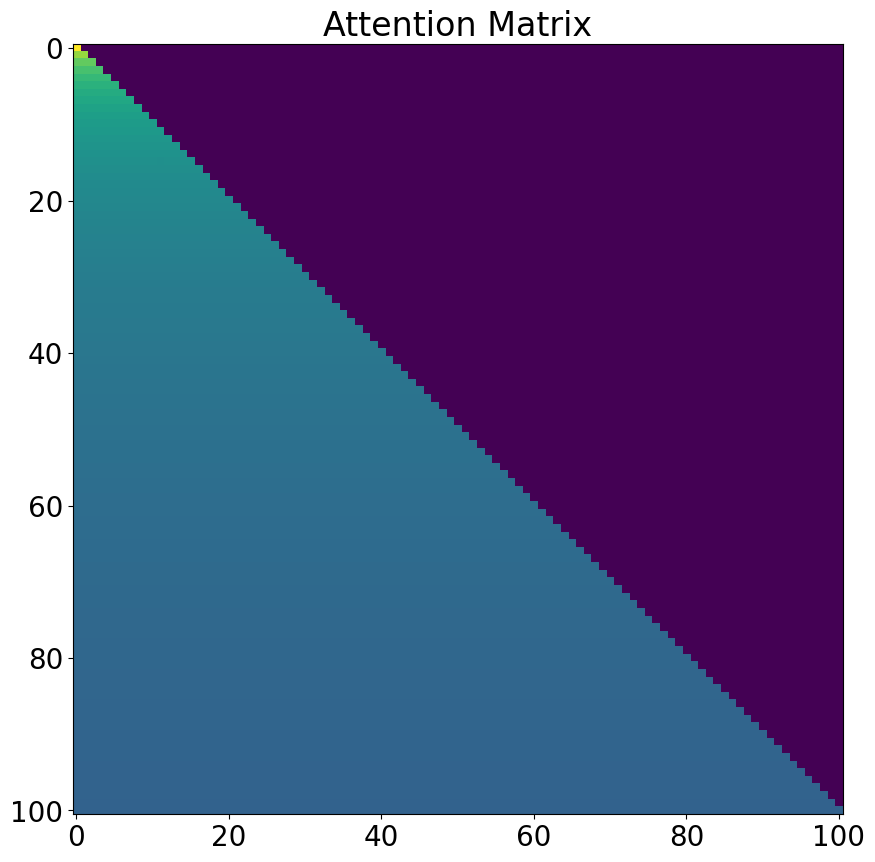

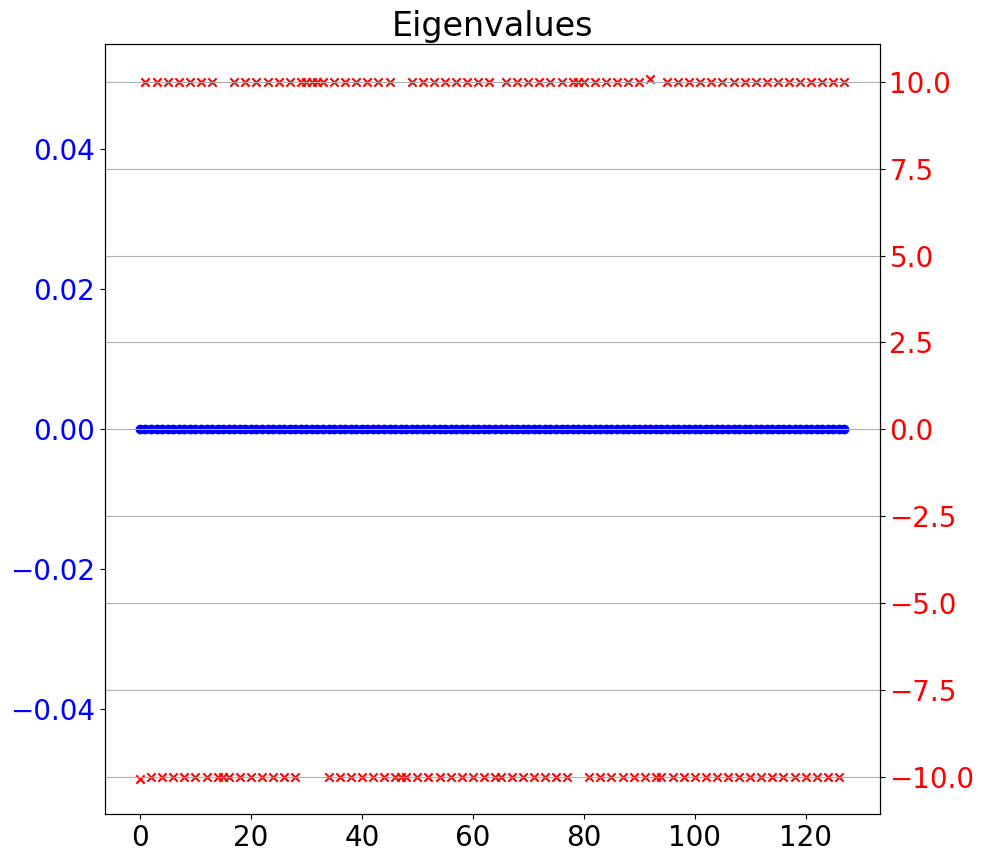

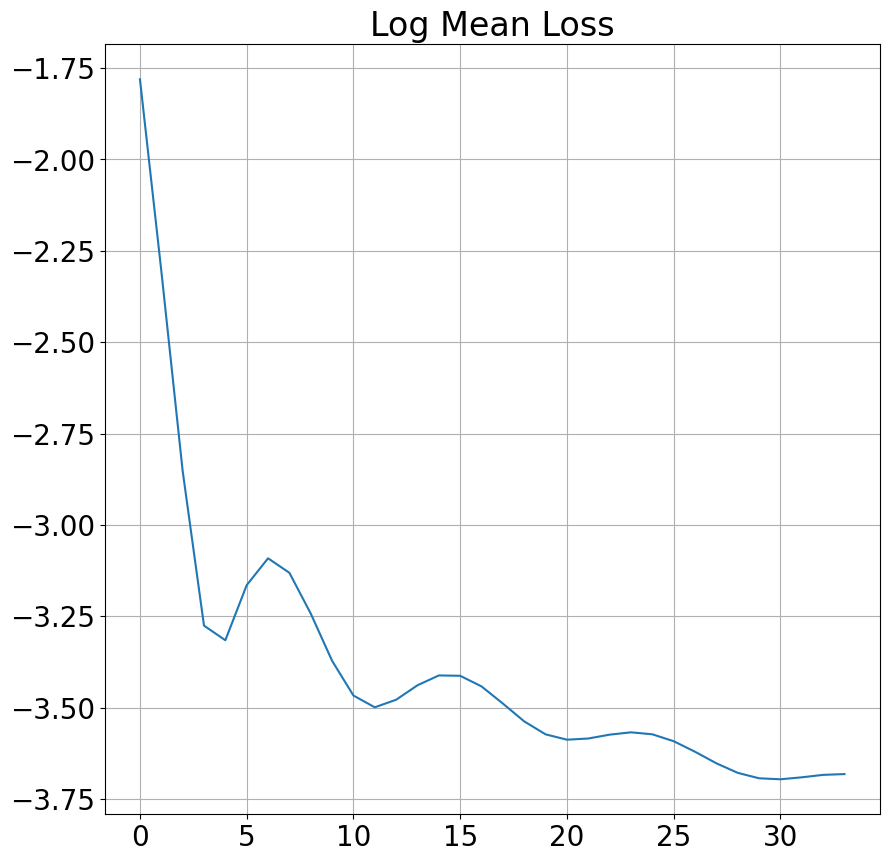

Training progress...:   4%|██▎                                                       | 39/1000 [00:40<14:21,  1.12it/s]

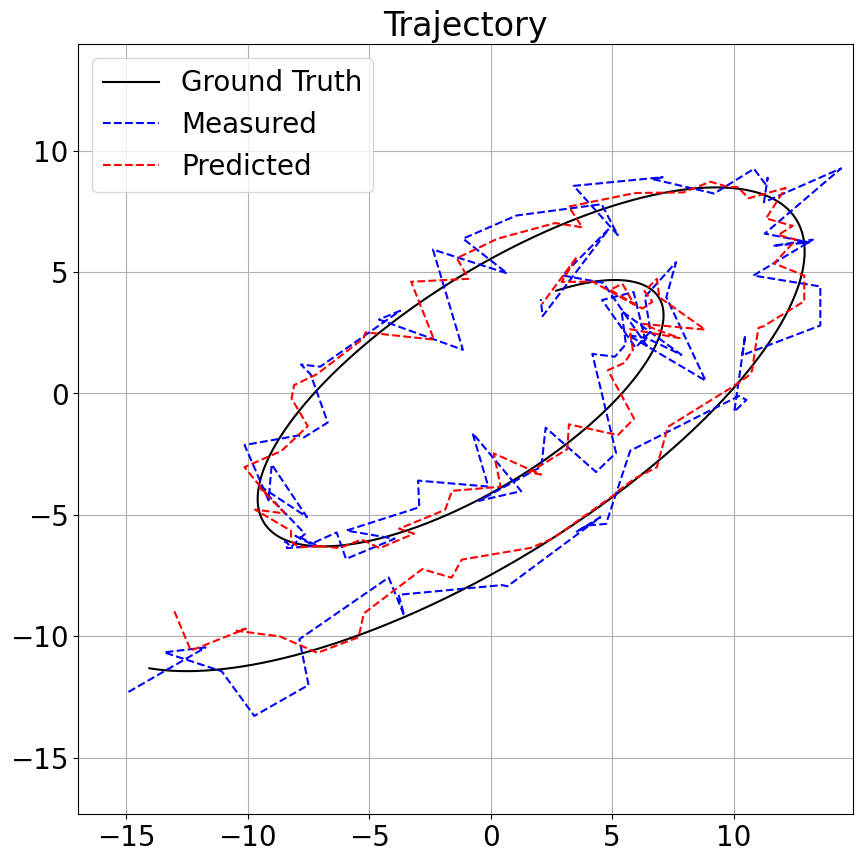

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


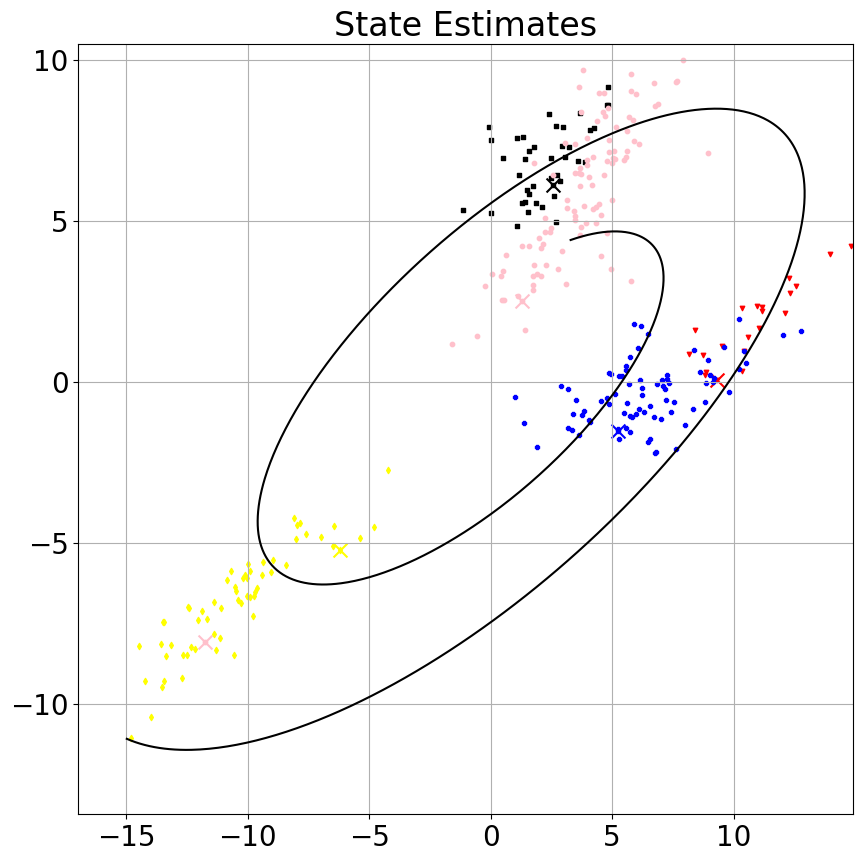

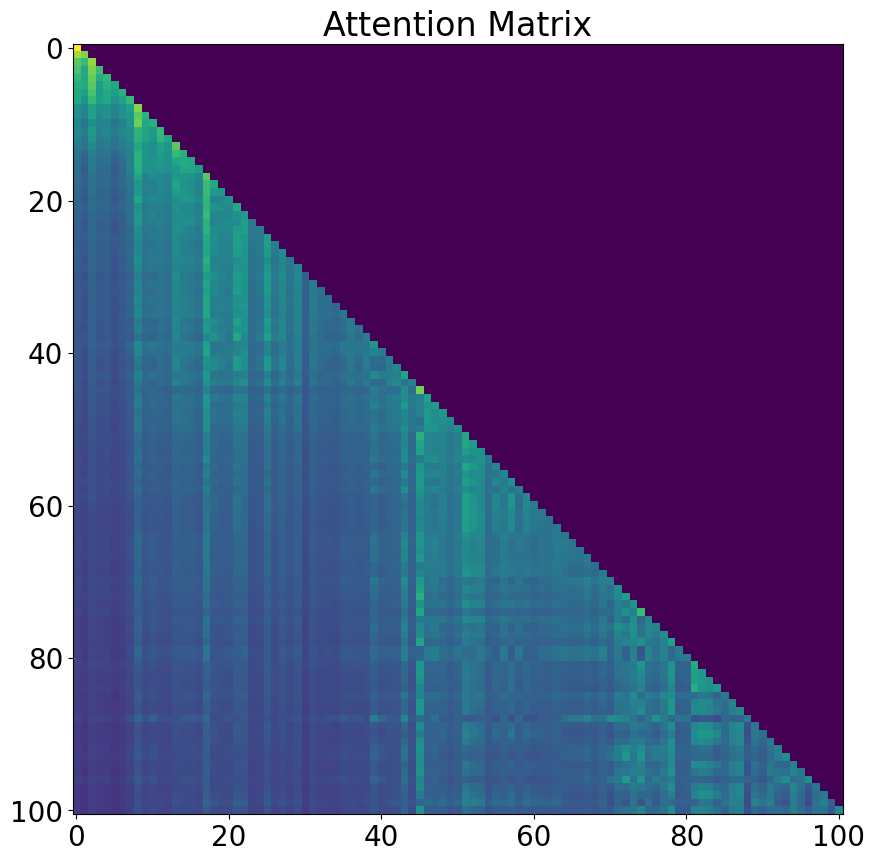

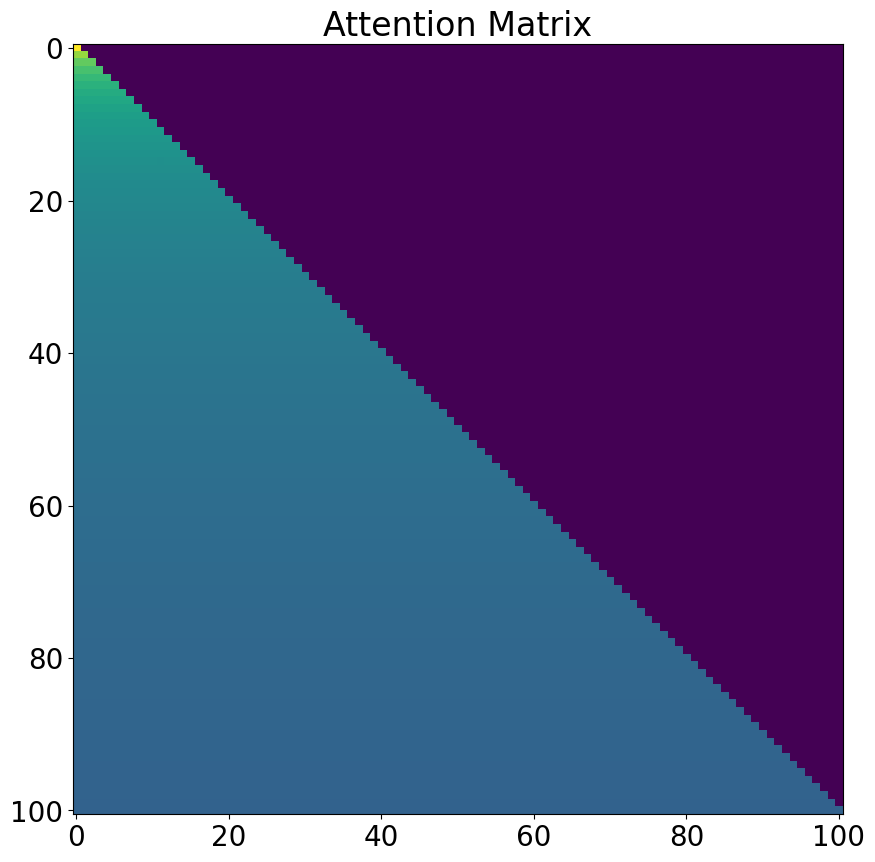

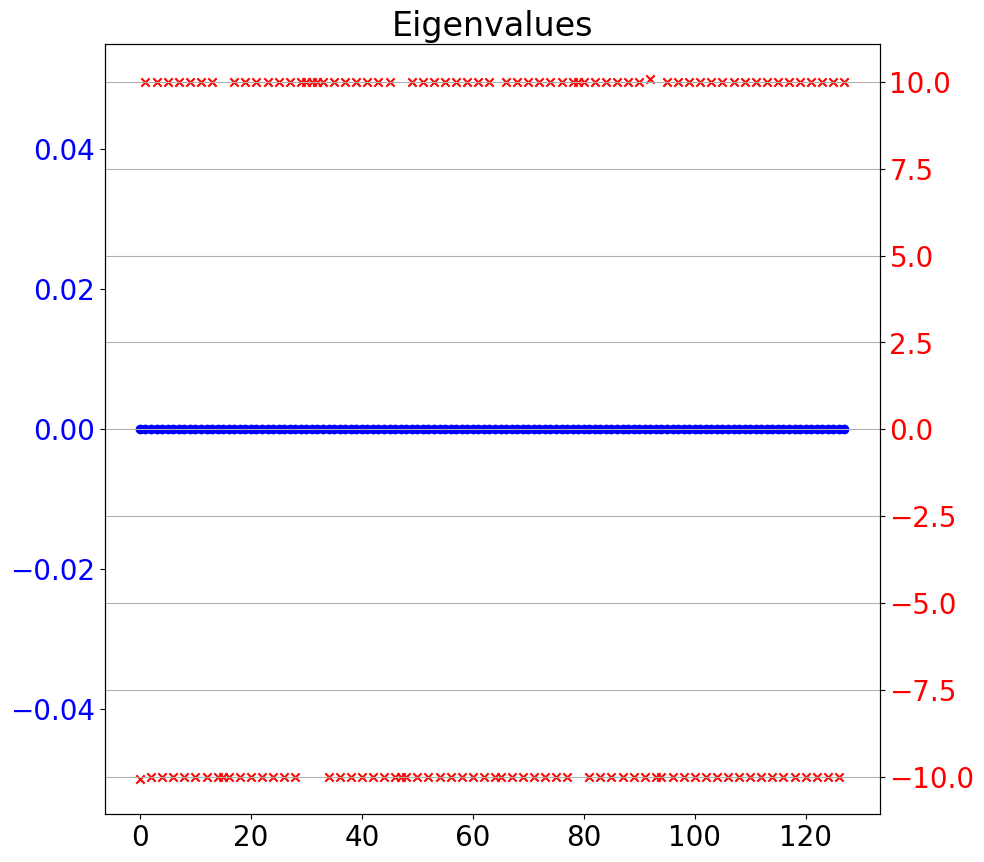

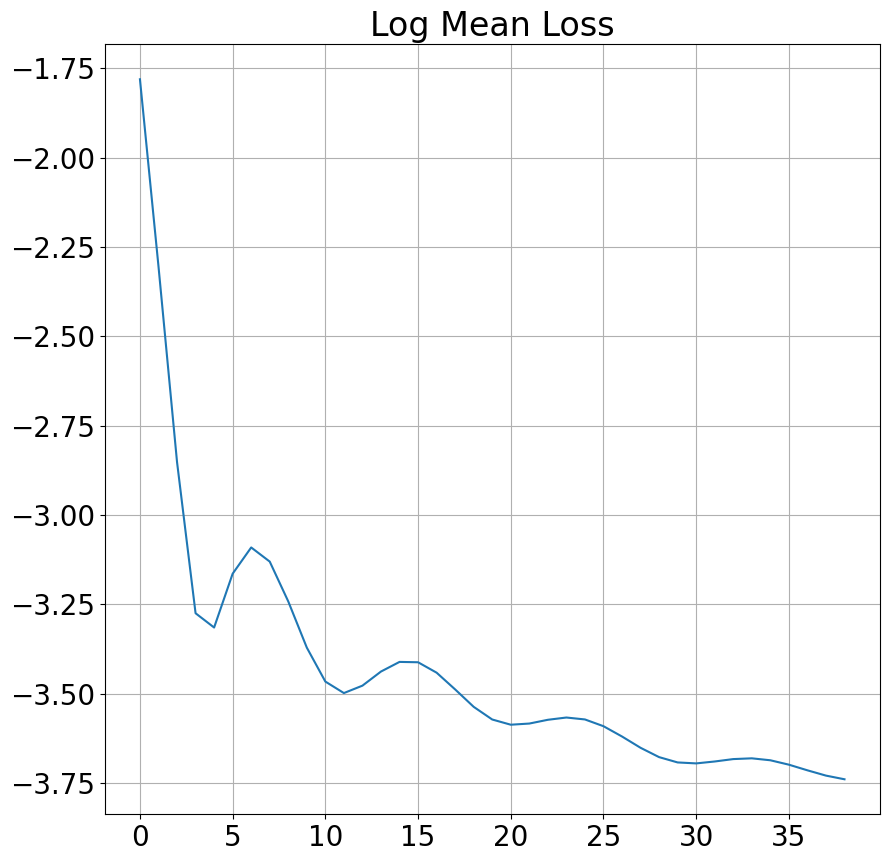

Training progress...:   4%|██▌                                                       | 44/1000 [00:46<14:57,  1.07it/s]

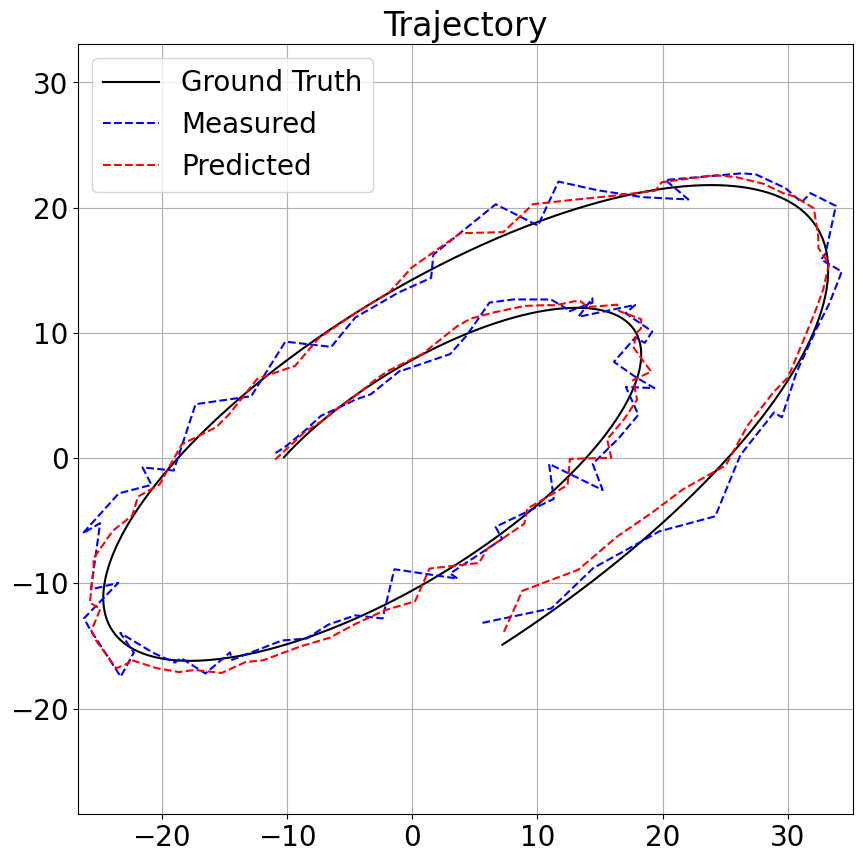

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


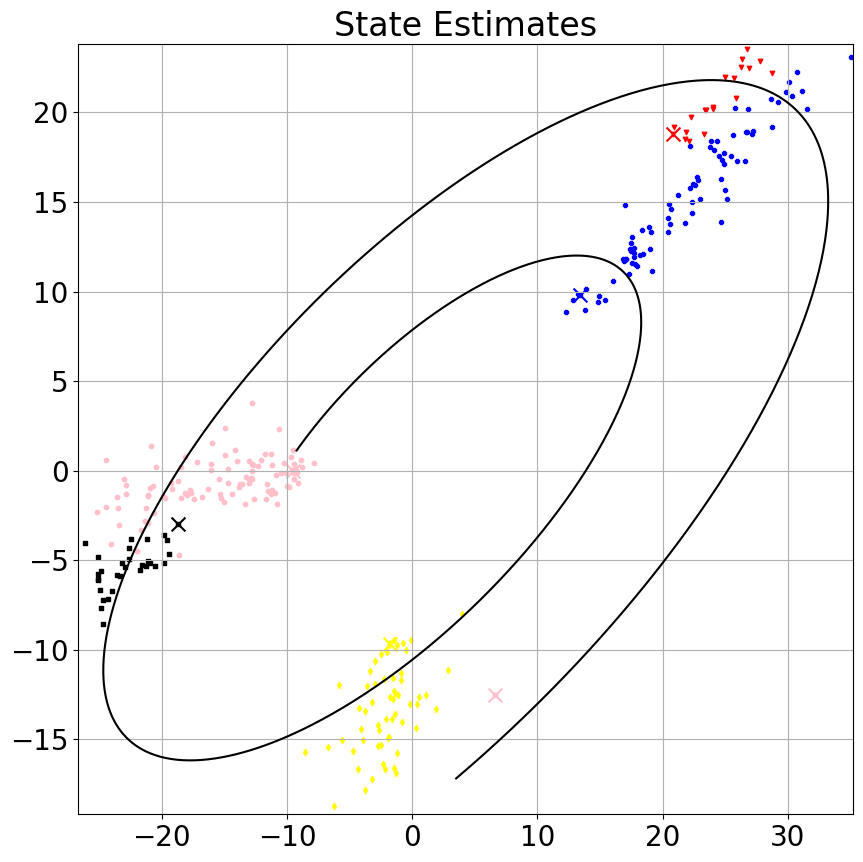

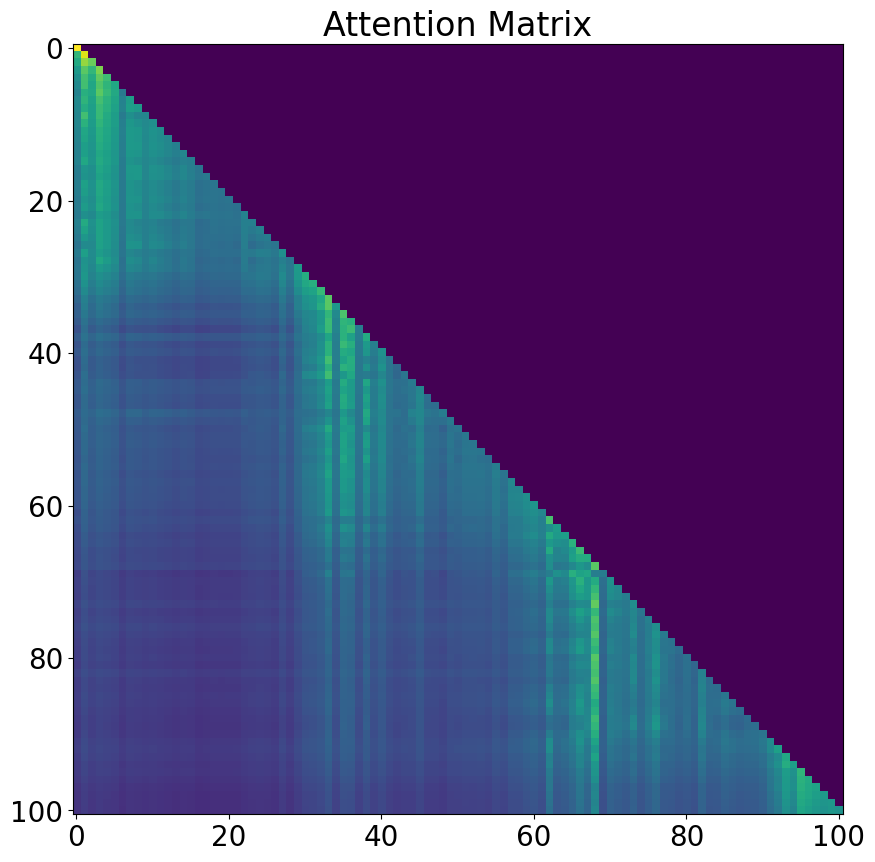

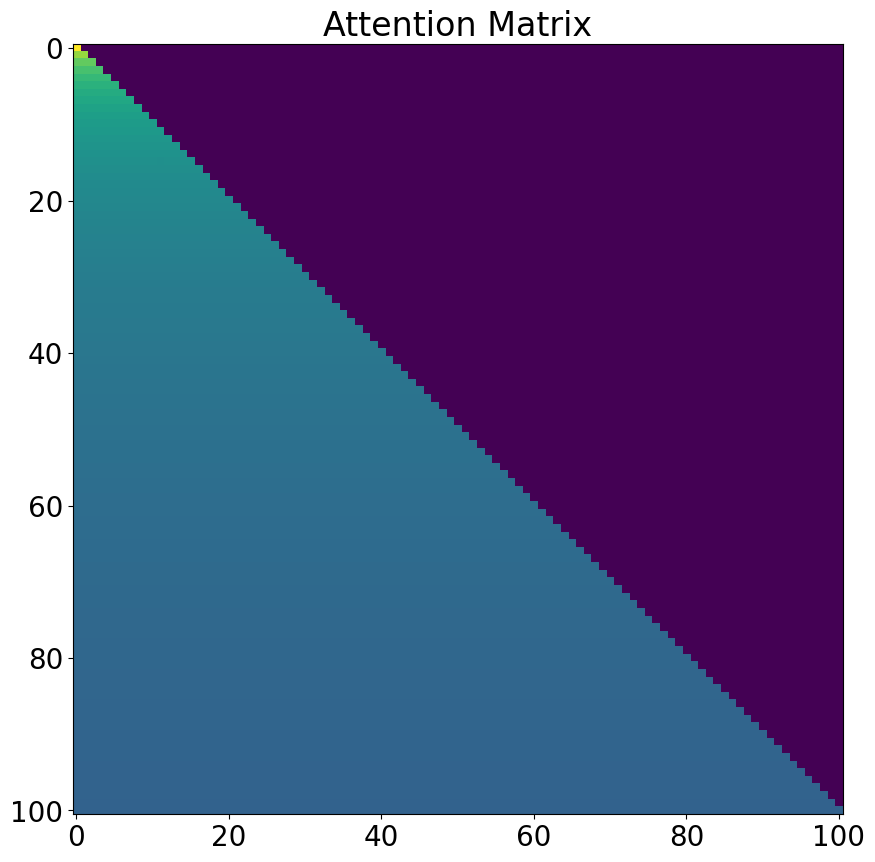

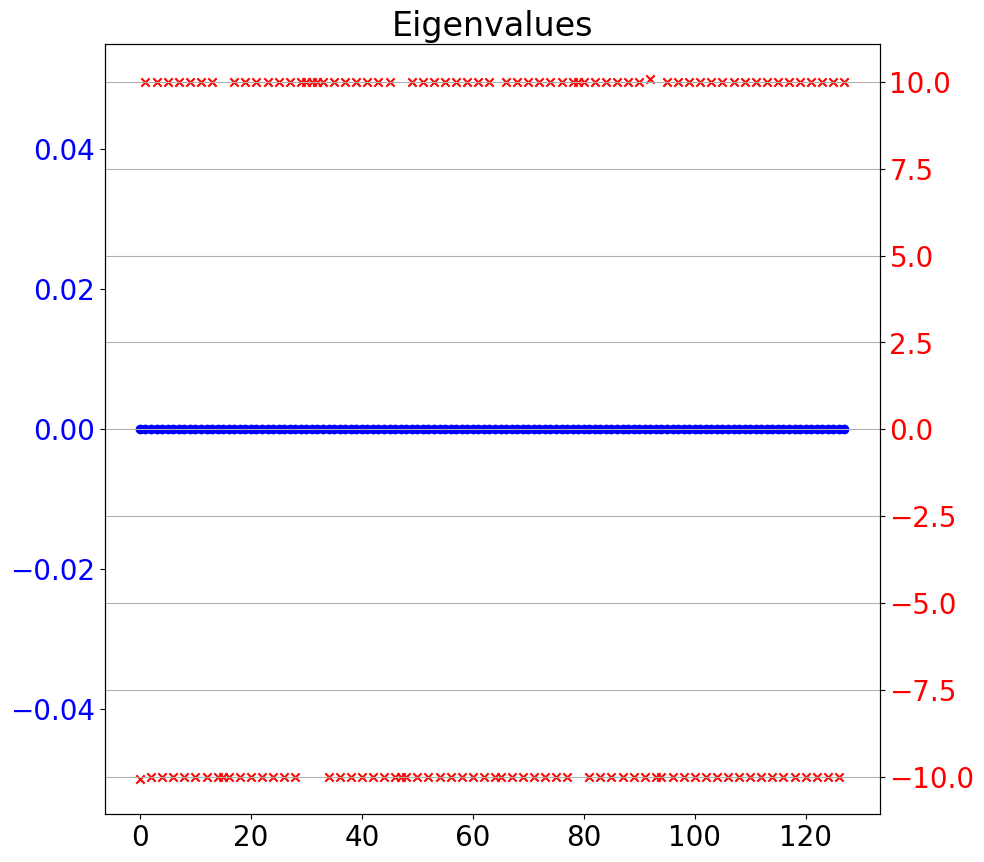

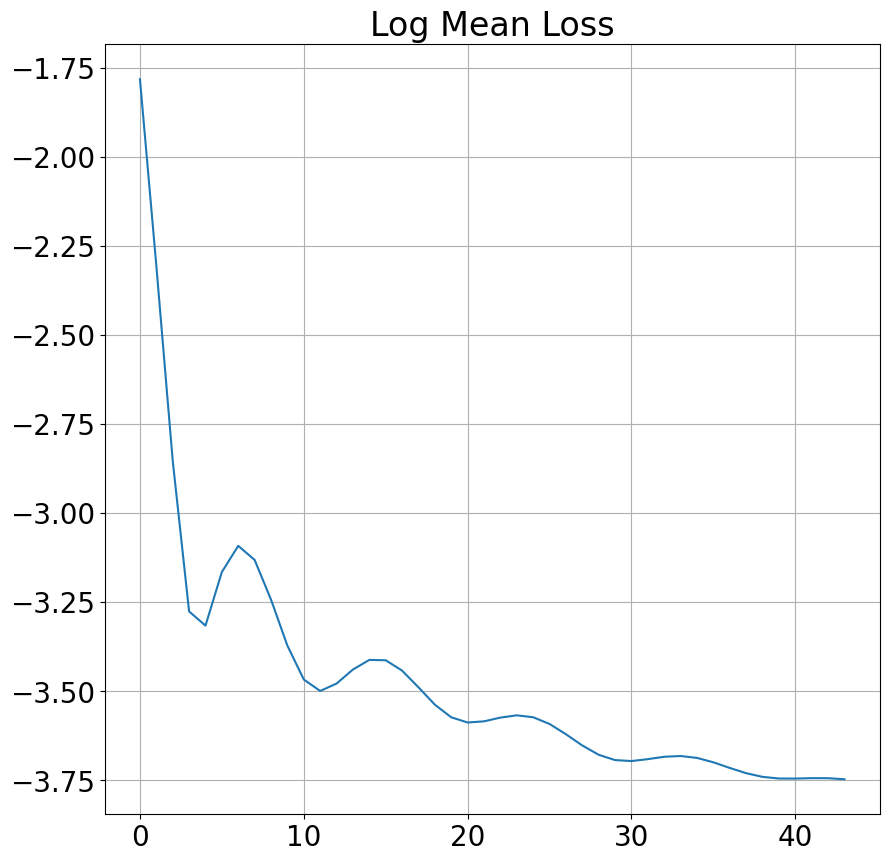

Training progress...:   5%|██▊                                                       | 49/1000 [00:51<14:44,  1.07it/s]

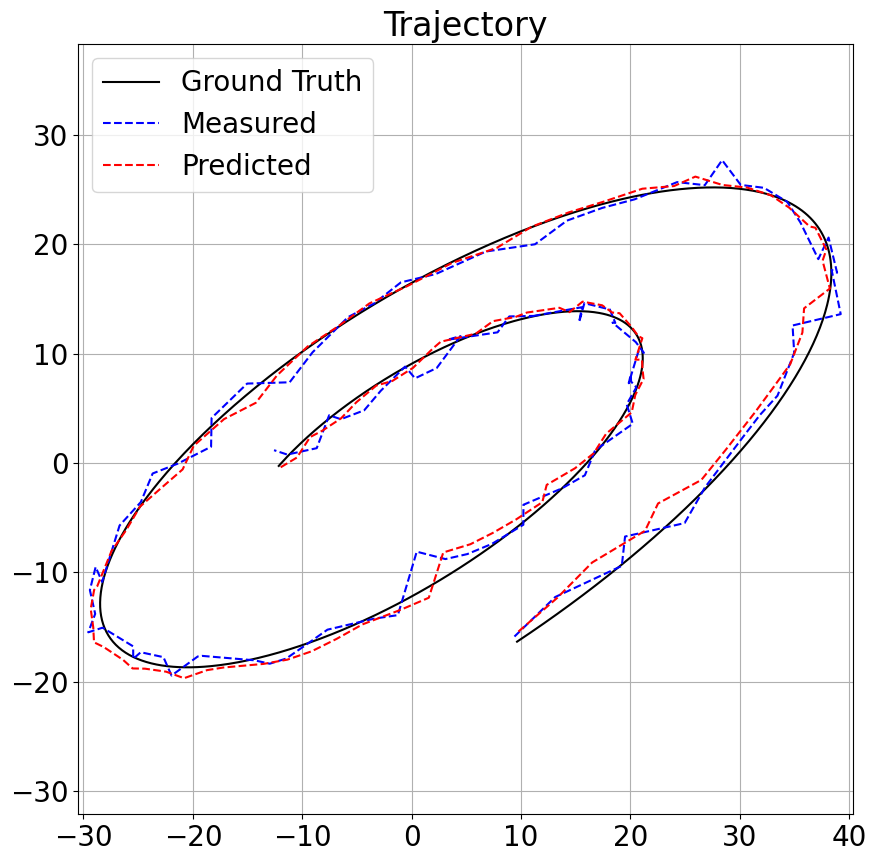

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


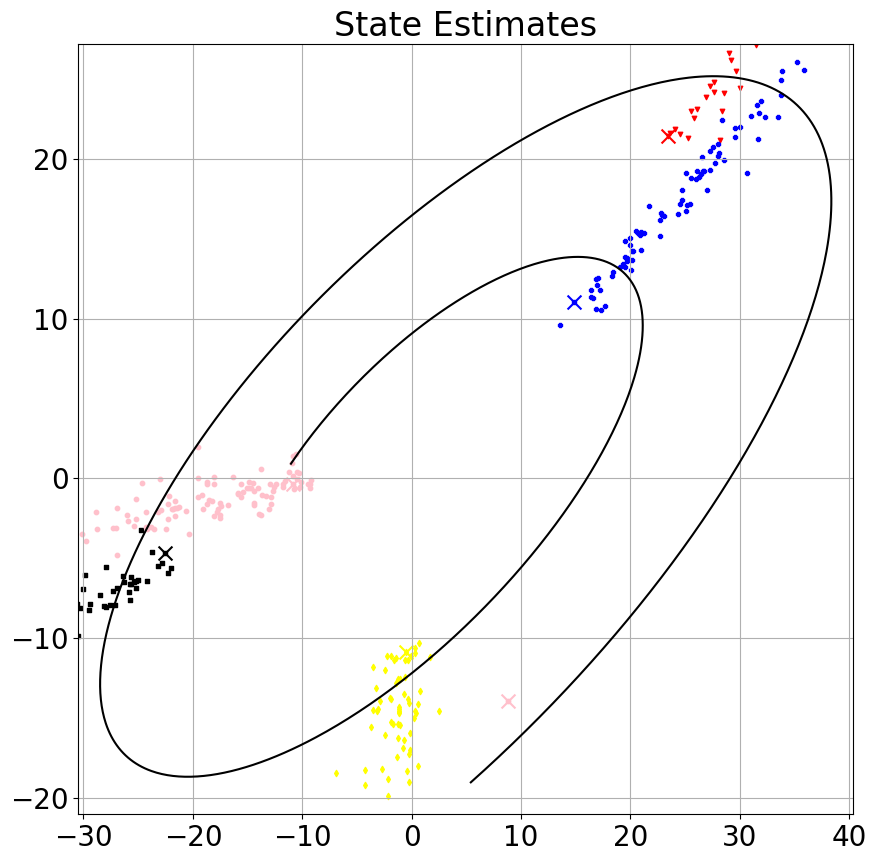

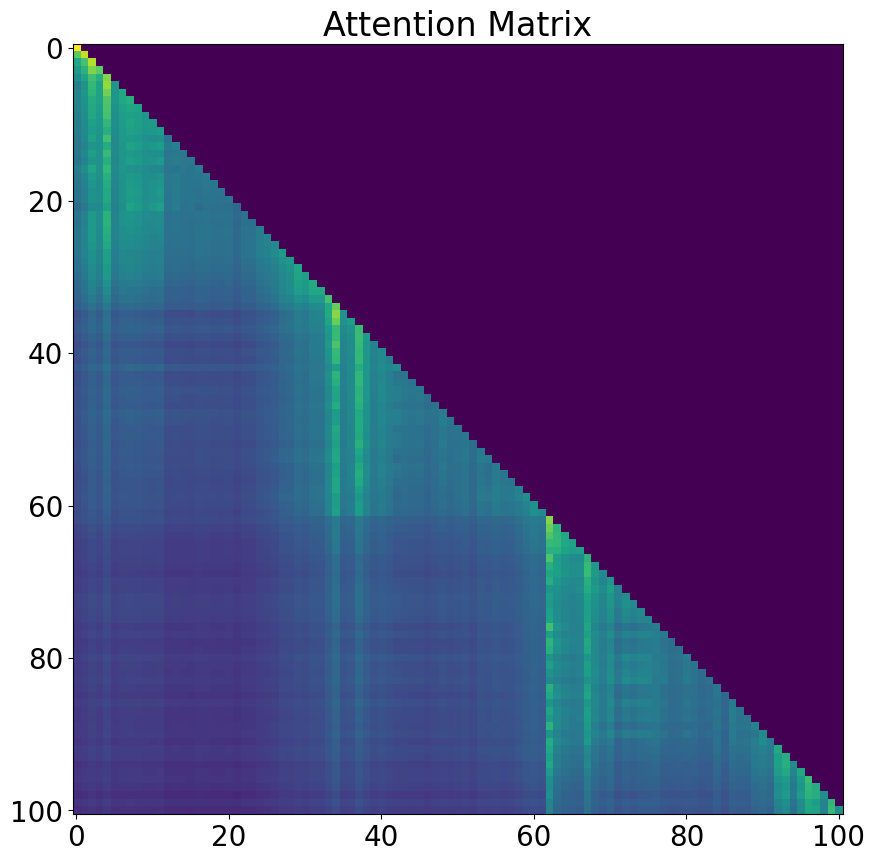

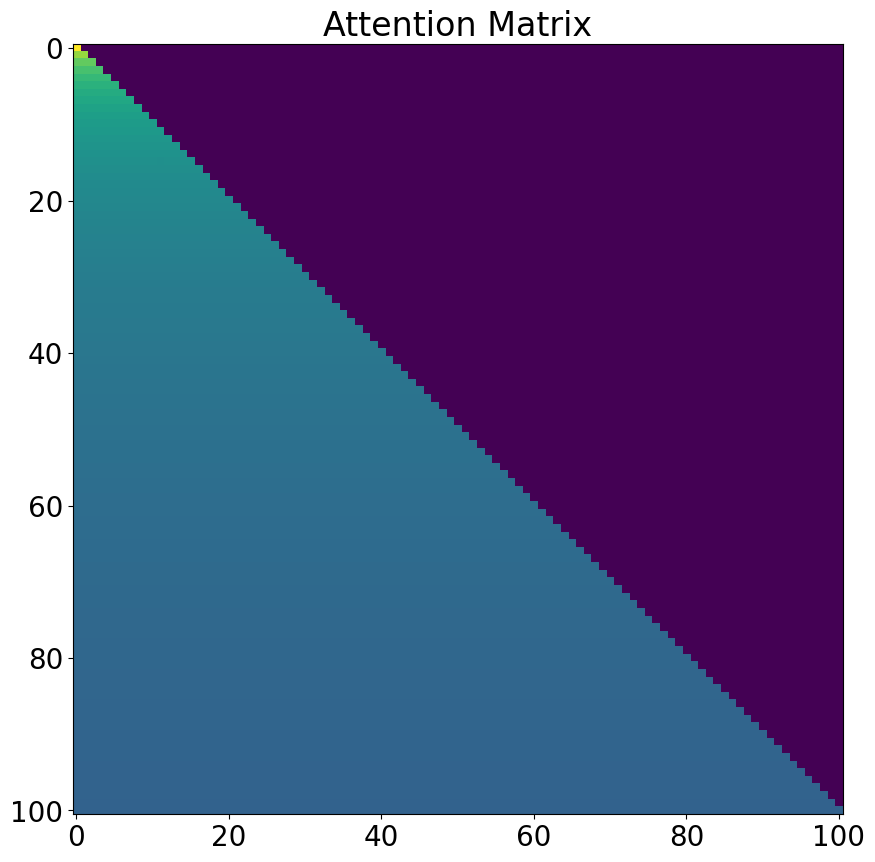

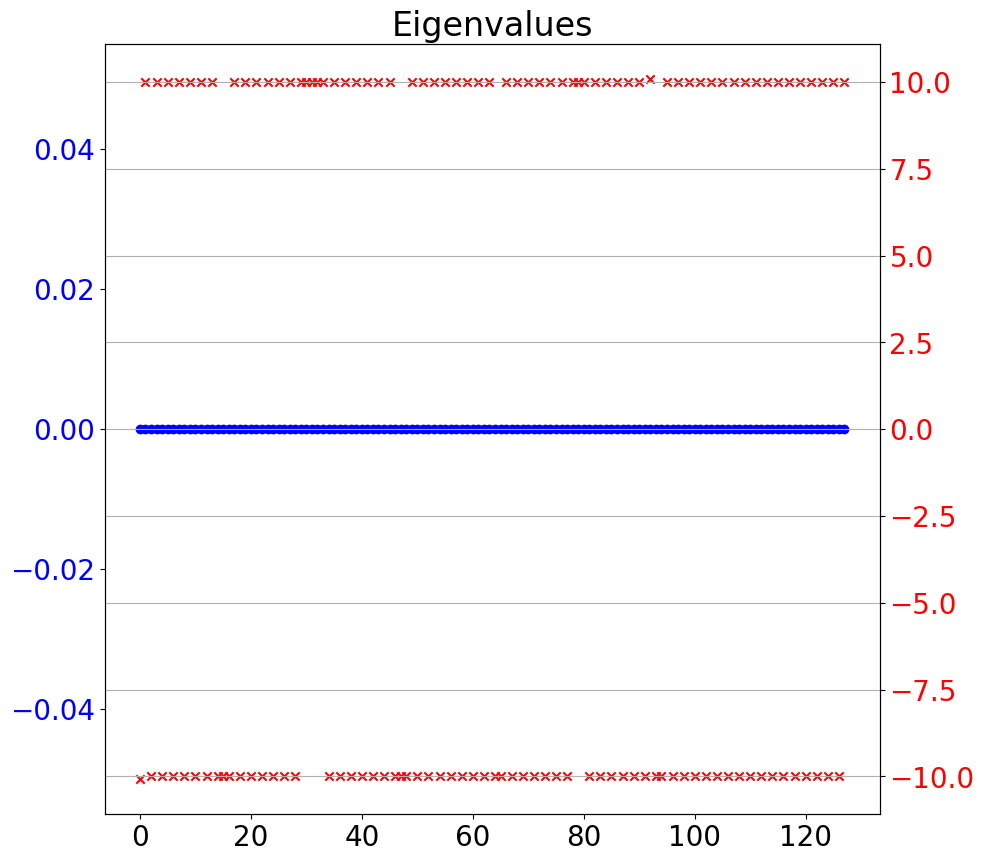

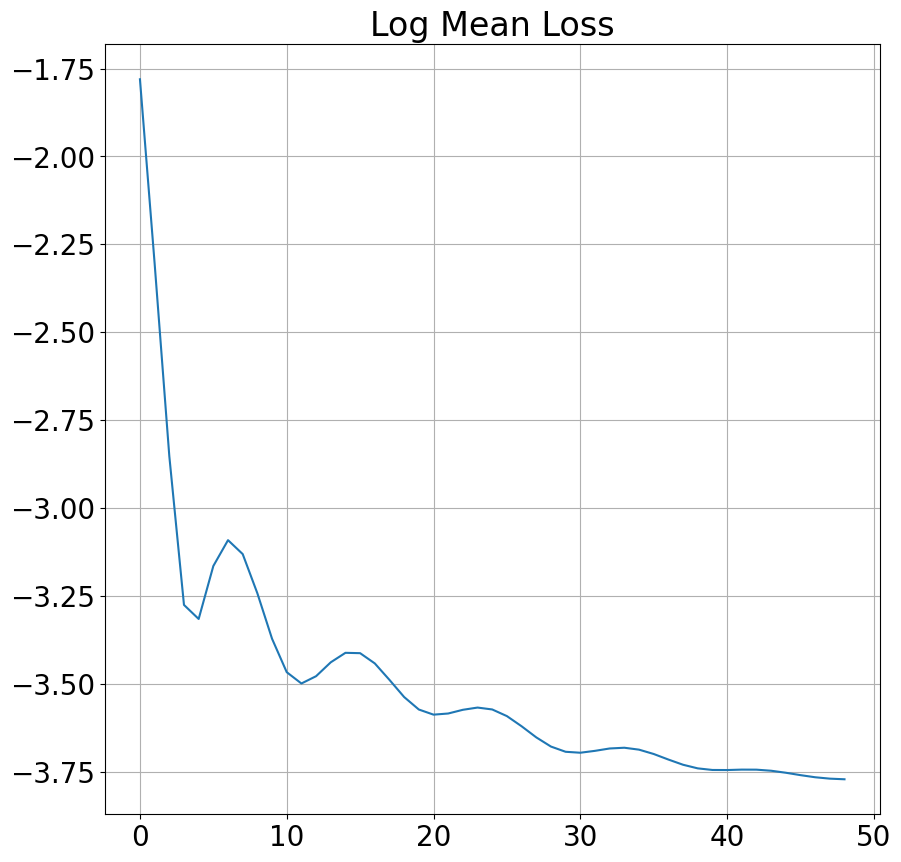

Training progress...:   5%|███▏                                                      | 54/1000 [00:56<14:11,  1.11it/s]

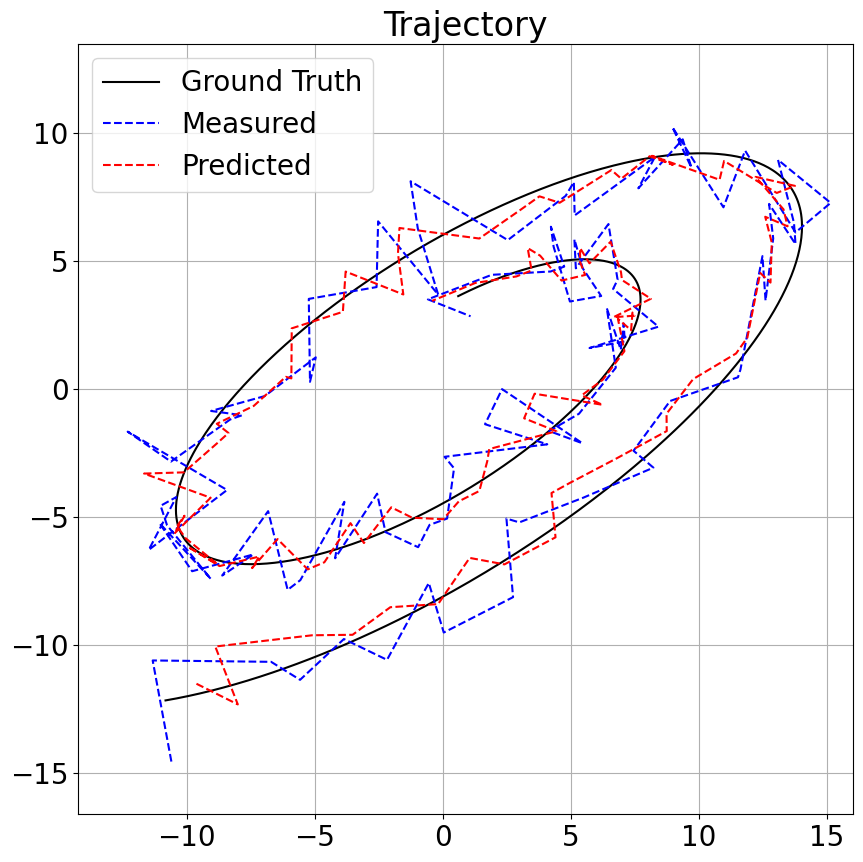

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


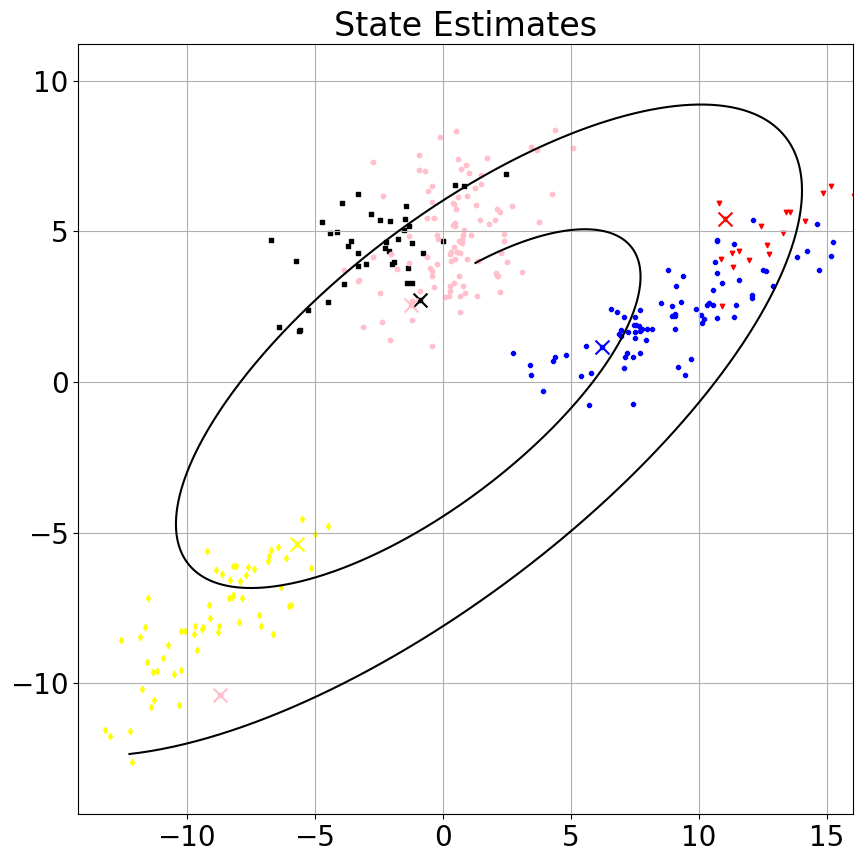

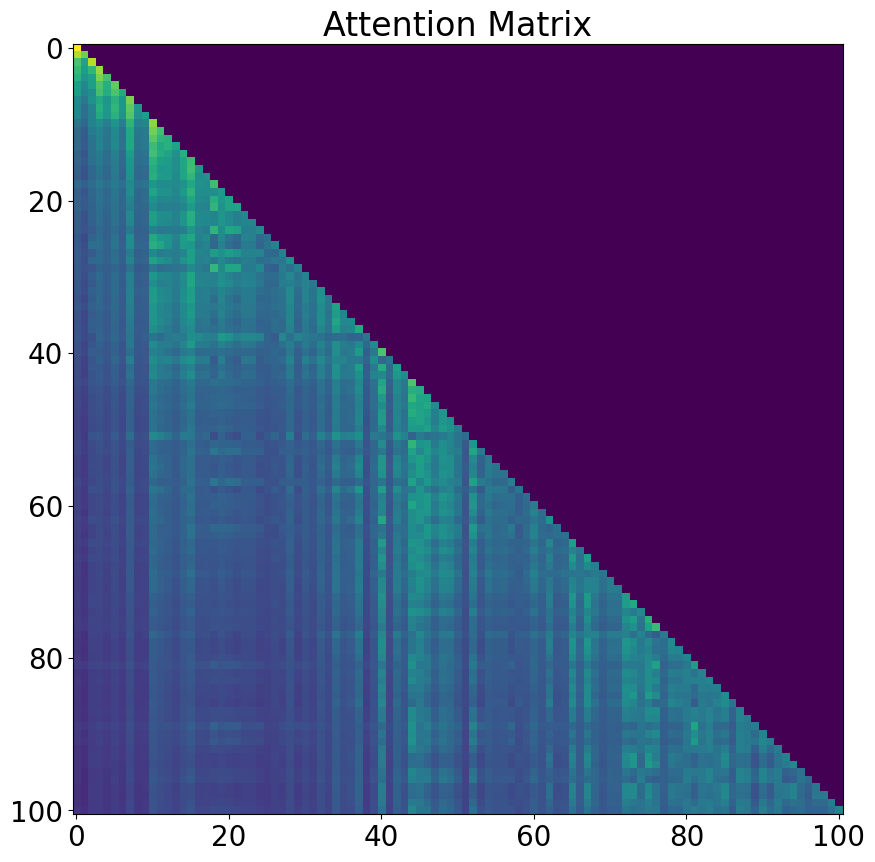

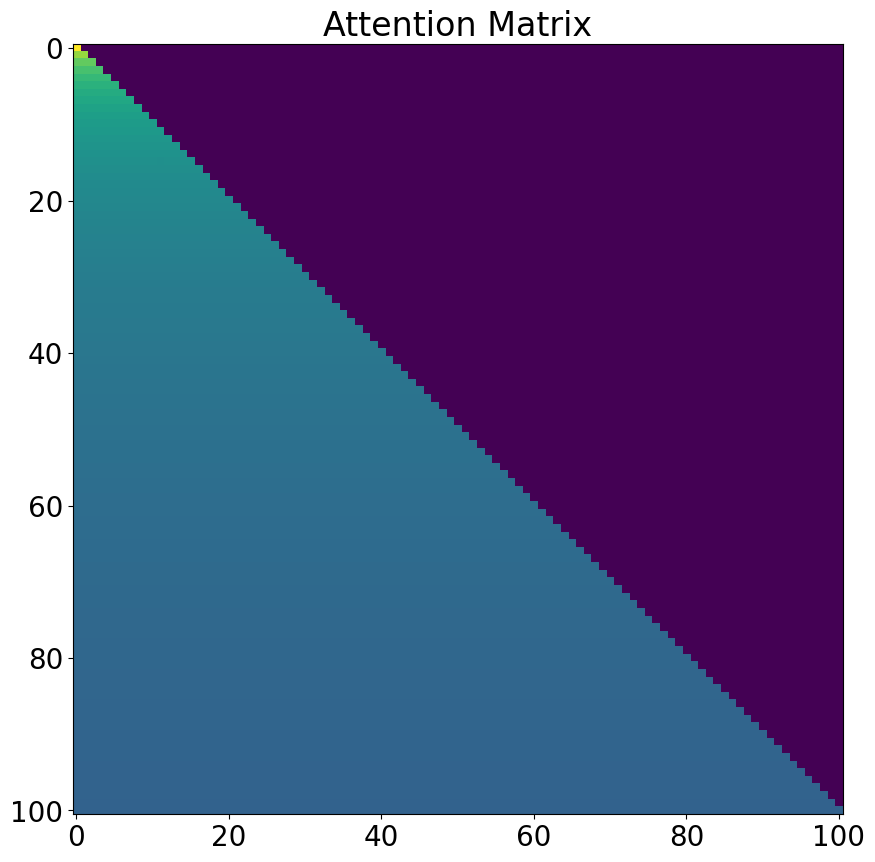

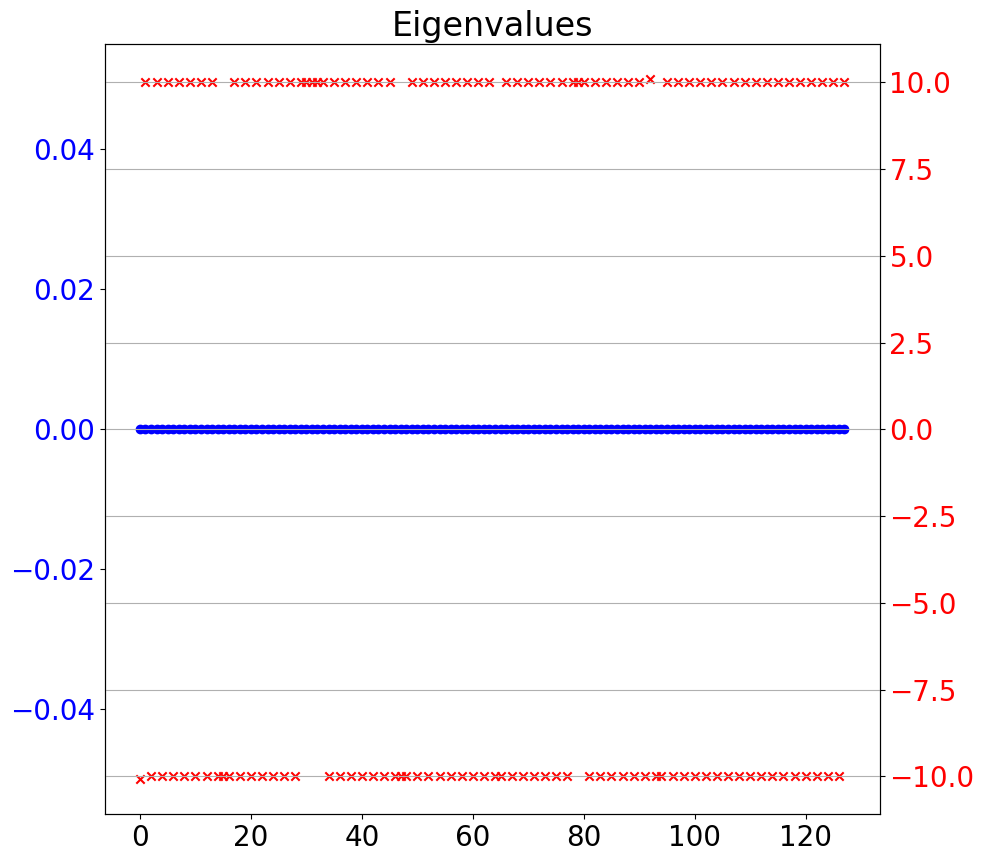

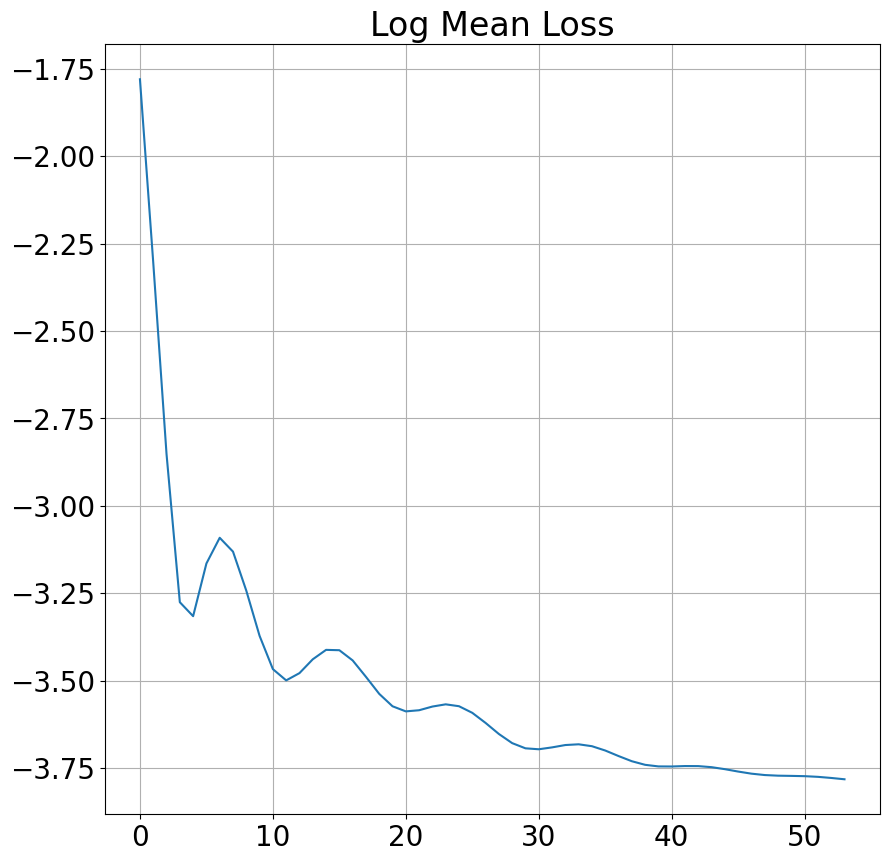

Training progress...:   6%|███▍                                                      | 59/1000 [01:02<14:02,  1.12it/s]

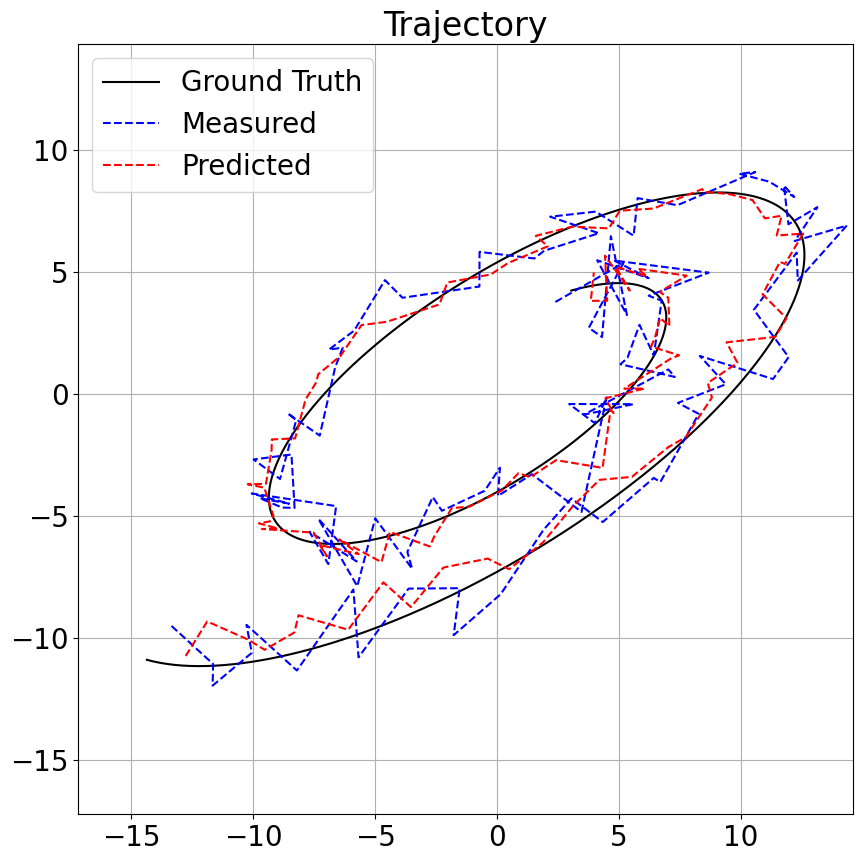

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


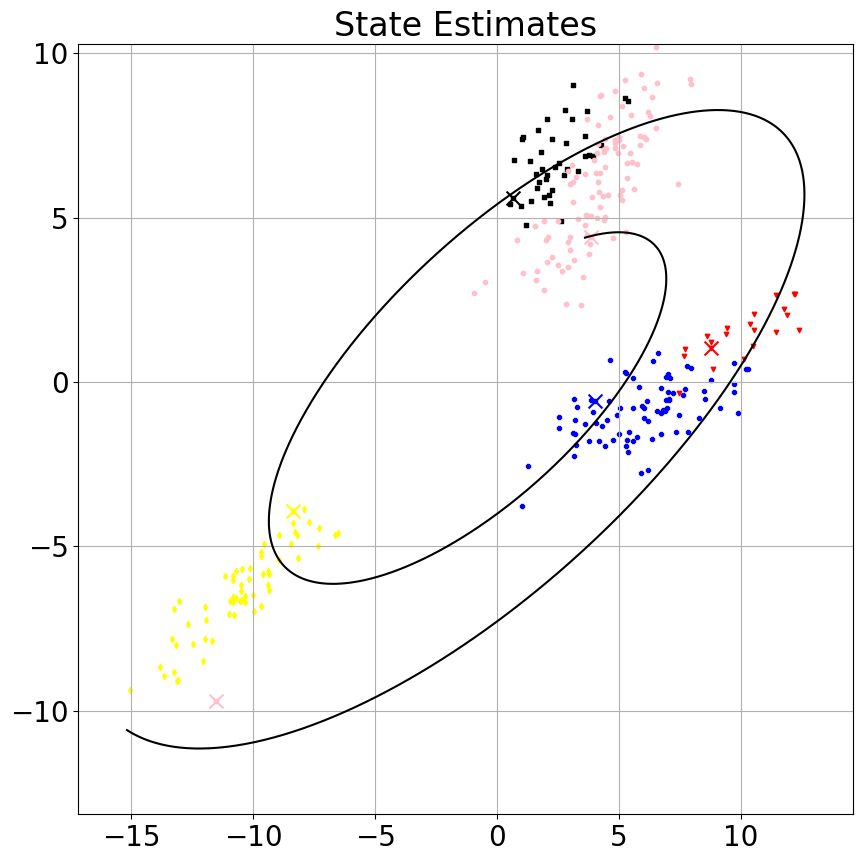

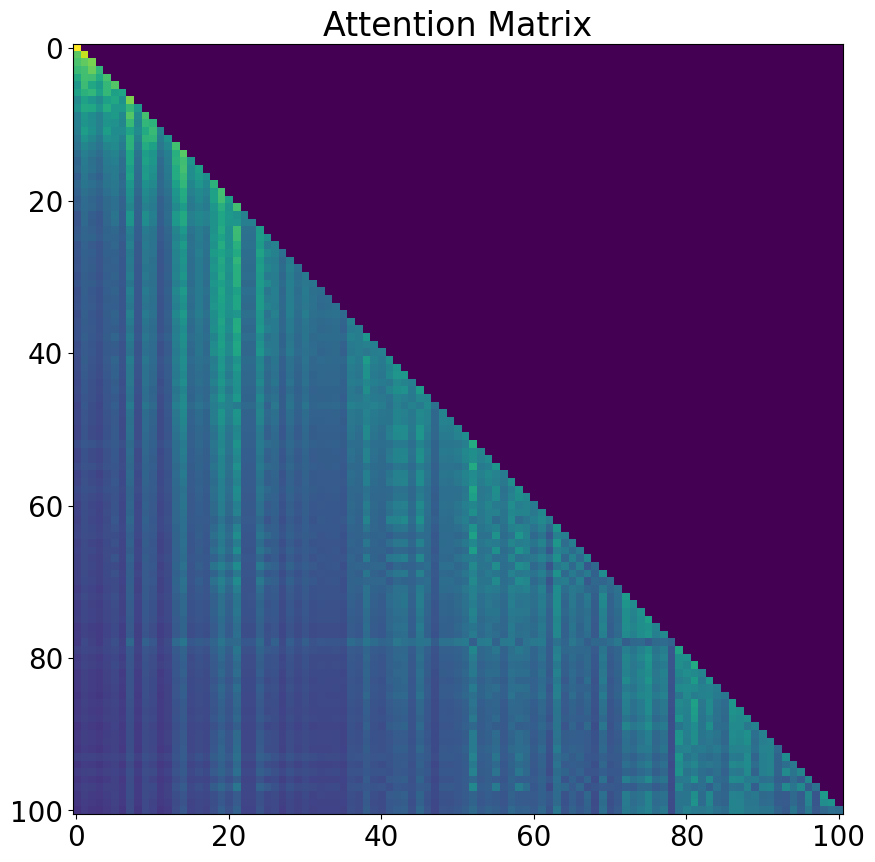

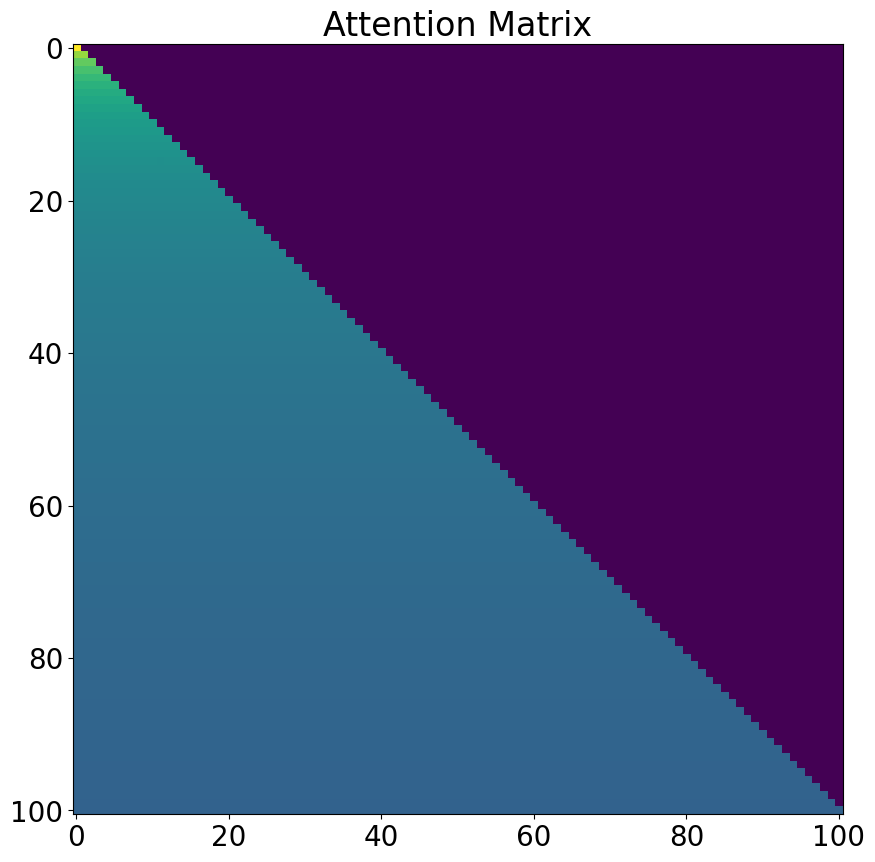

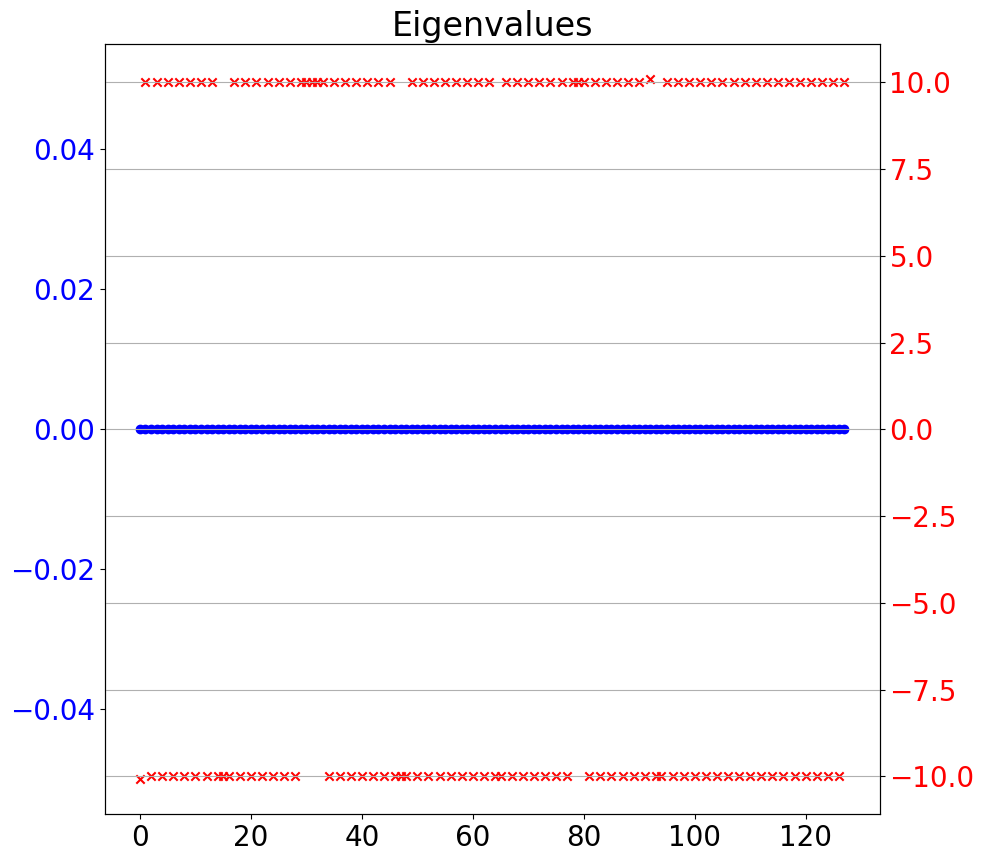

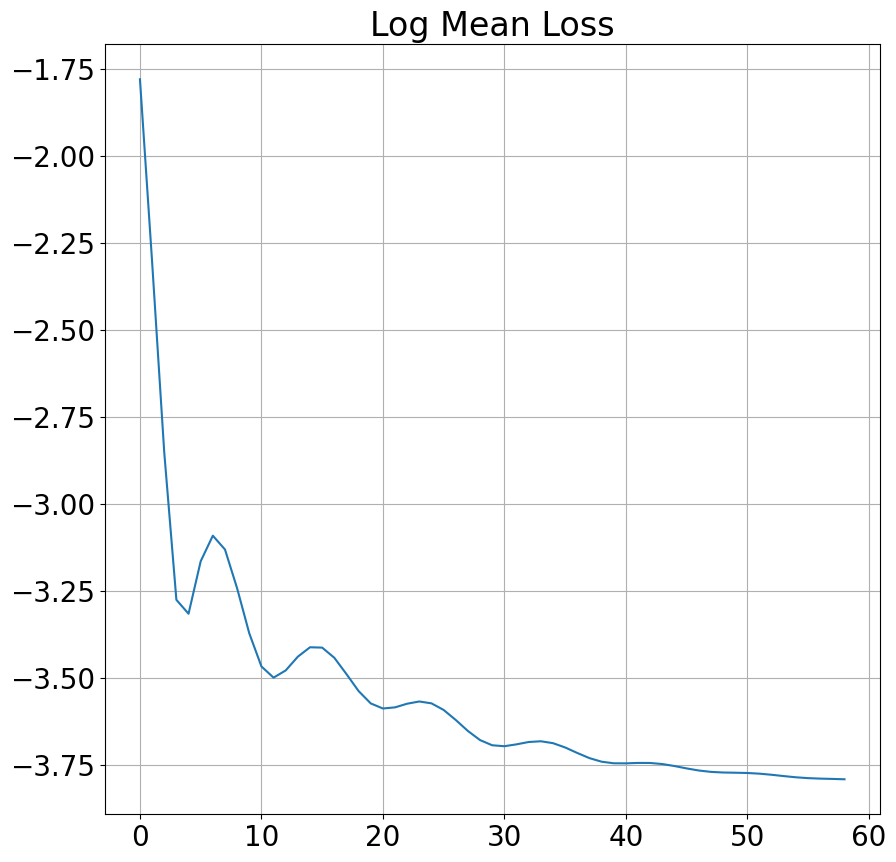

Training progress...:   6%|███▋                                                      | 64/1000 [01:07<13:56,  1.12it/s]

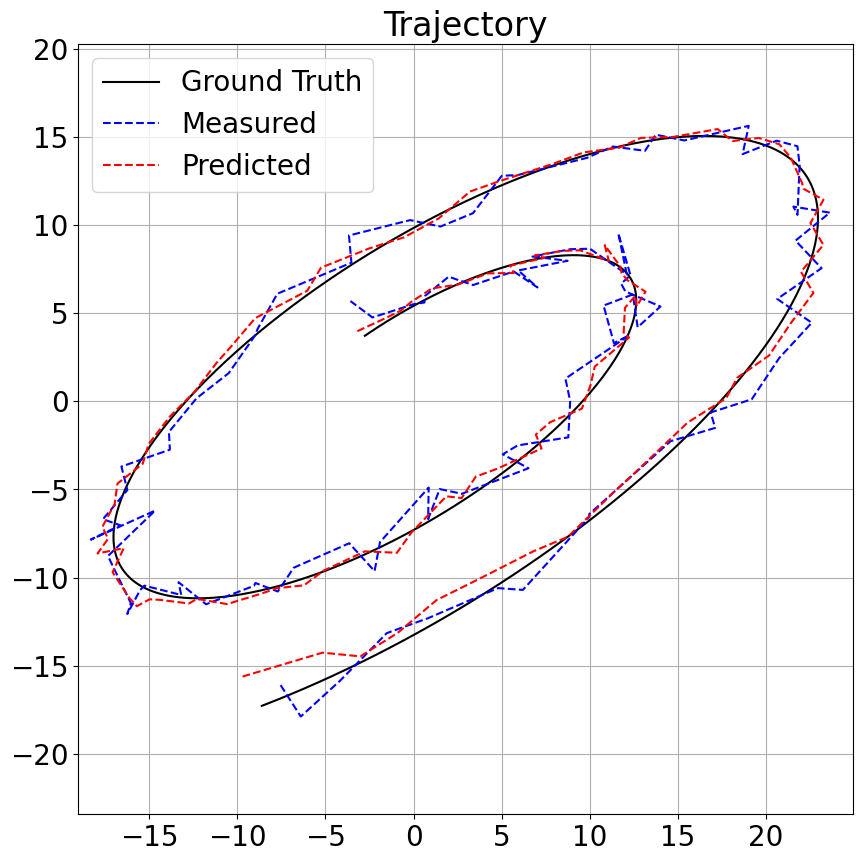

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


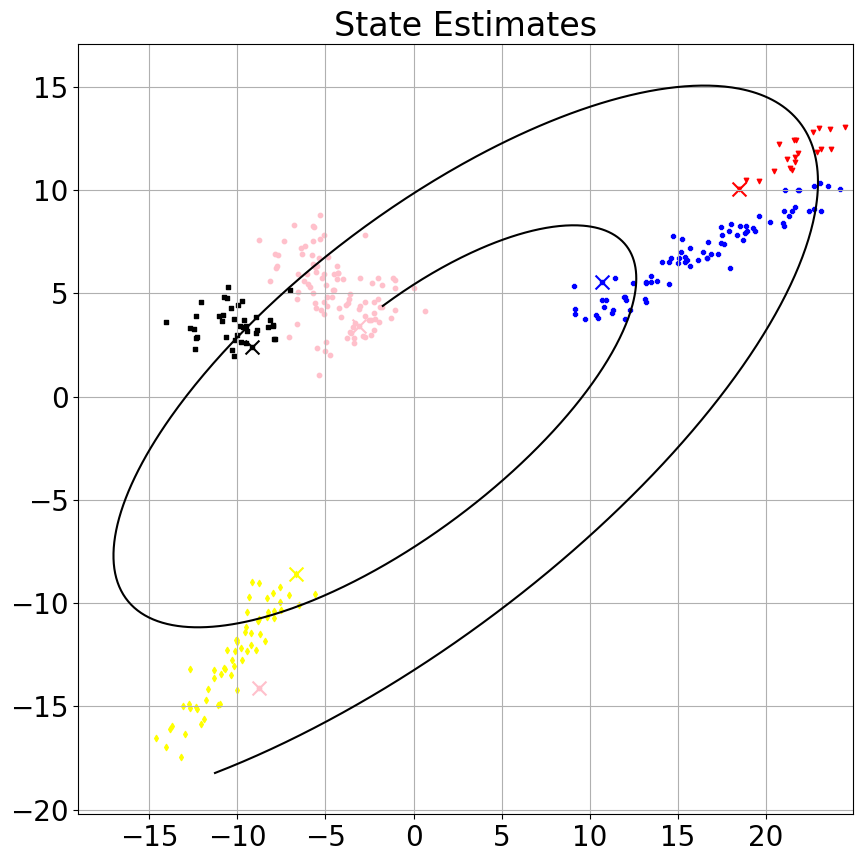

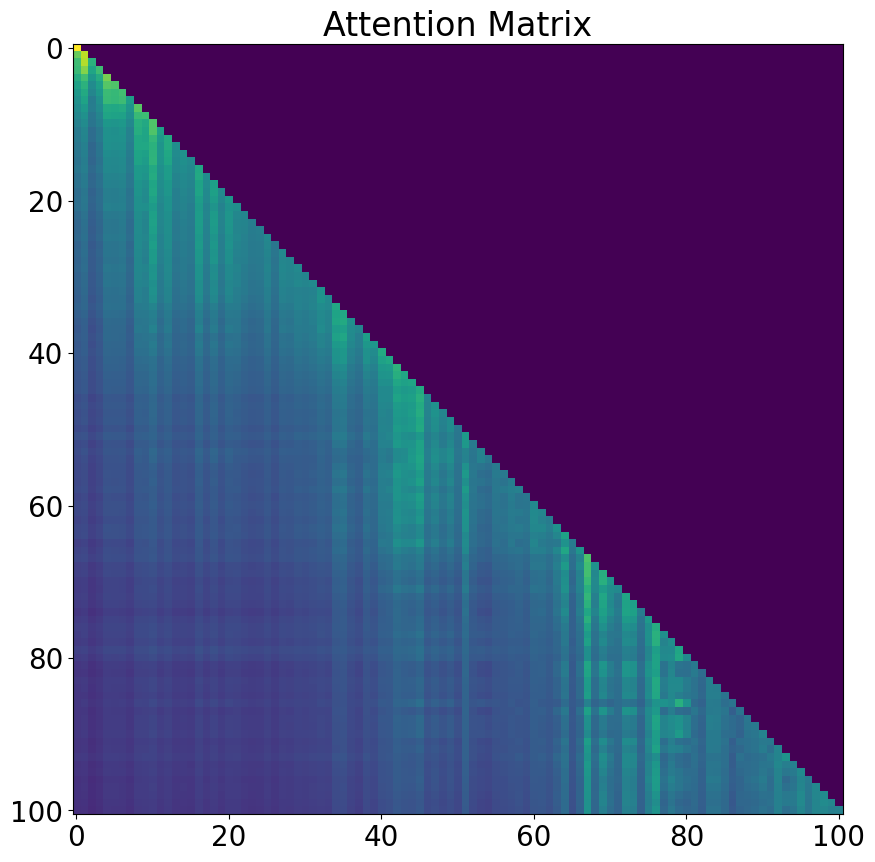

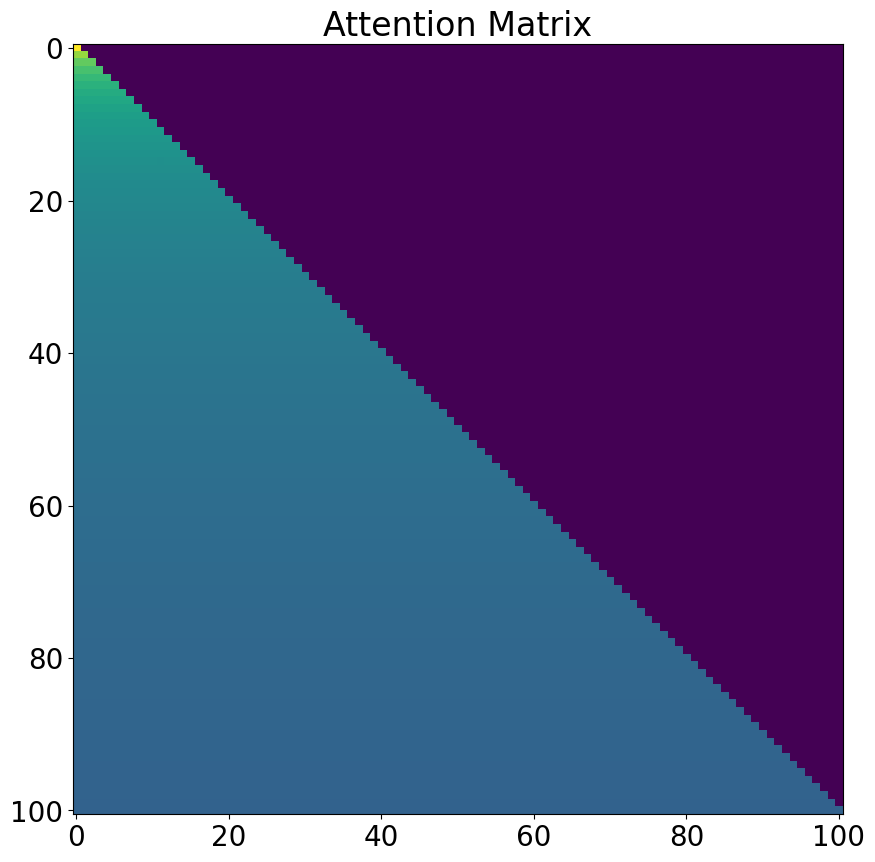

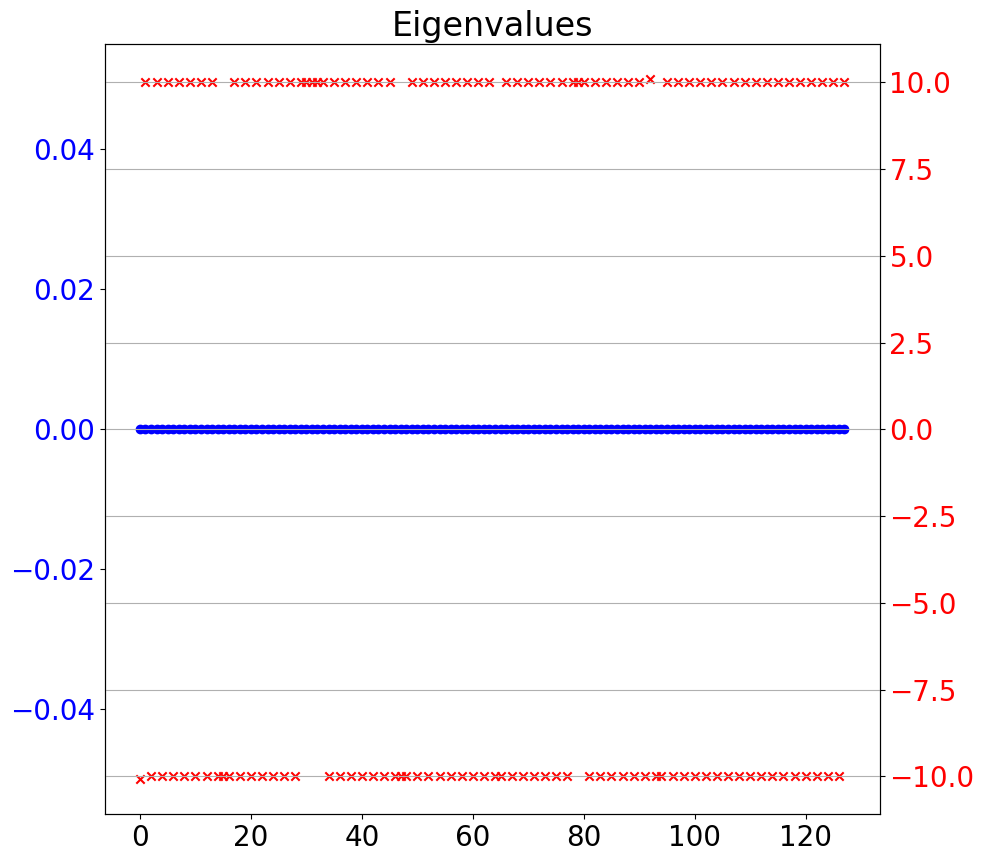

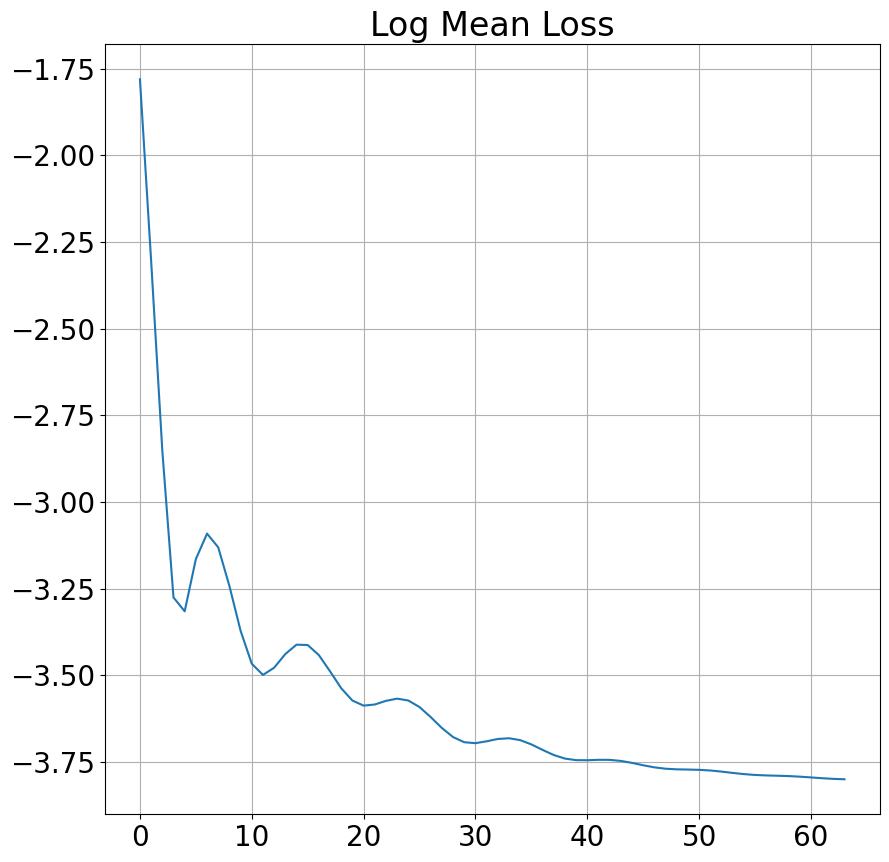

Training progress...:   7%|████                                                      | 69/1000 [01:12<14:37,  1.06it/s]

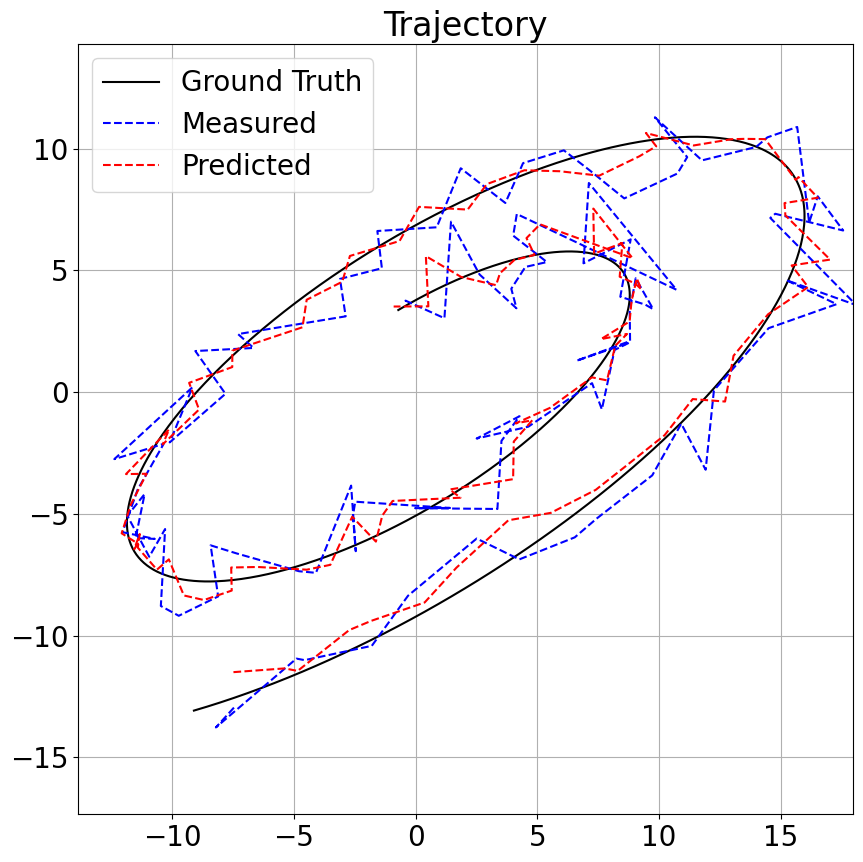

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


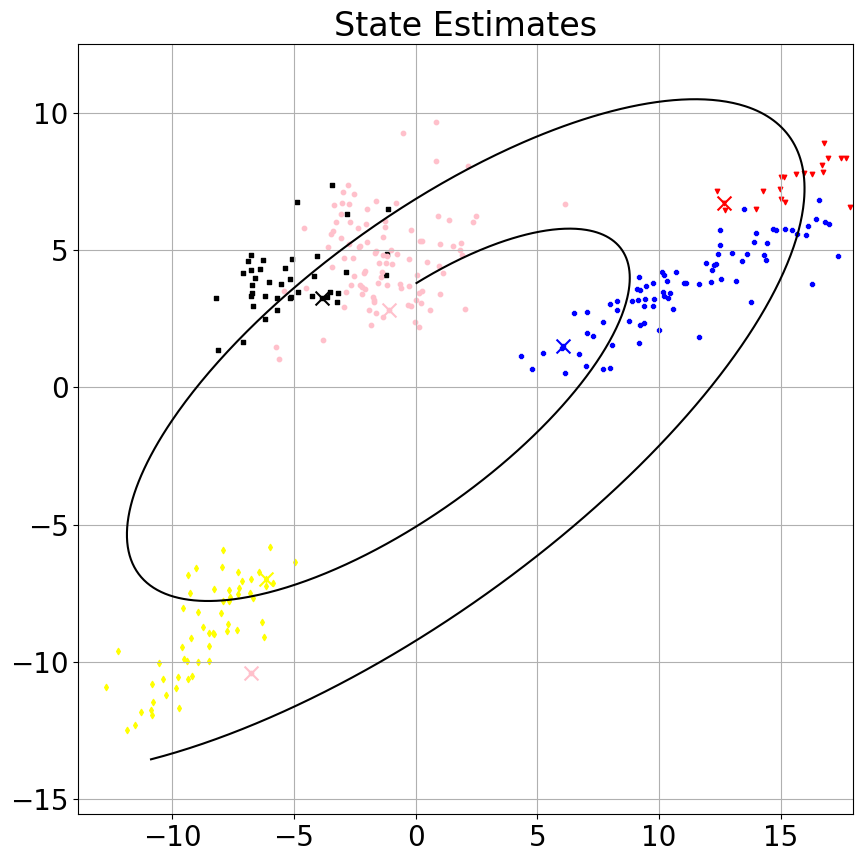

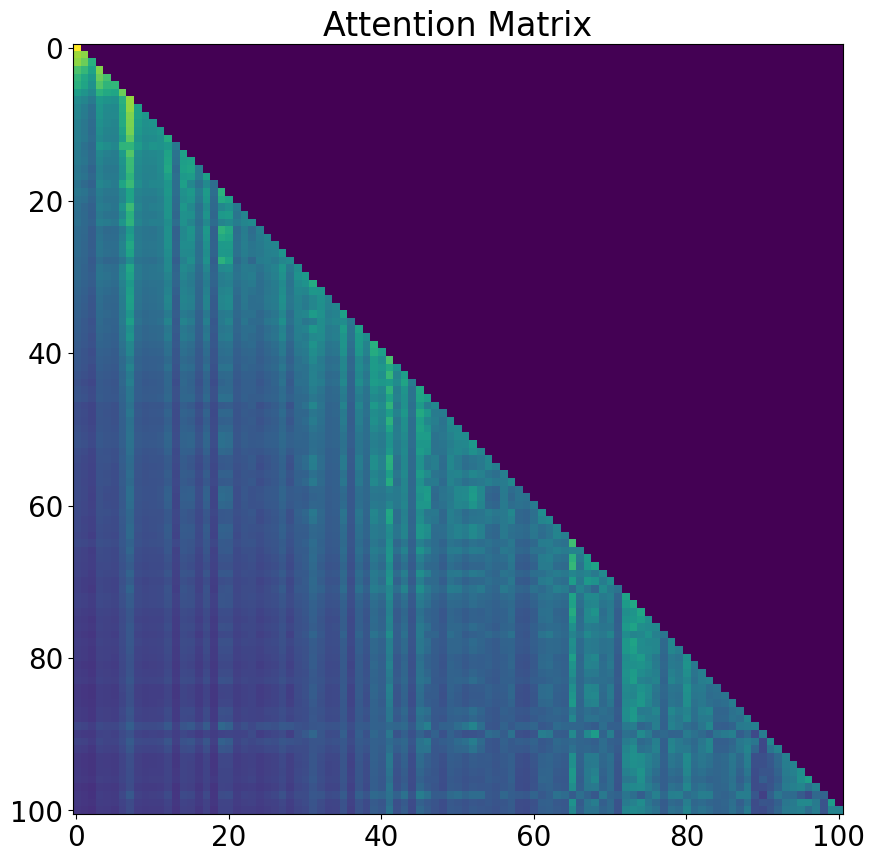

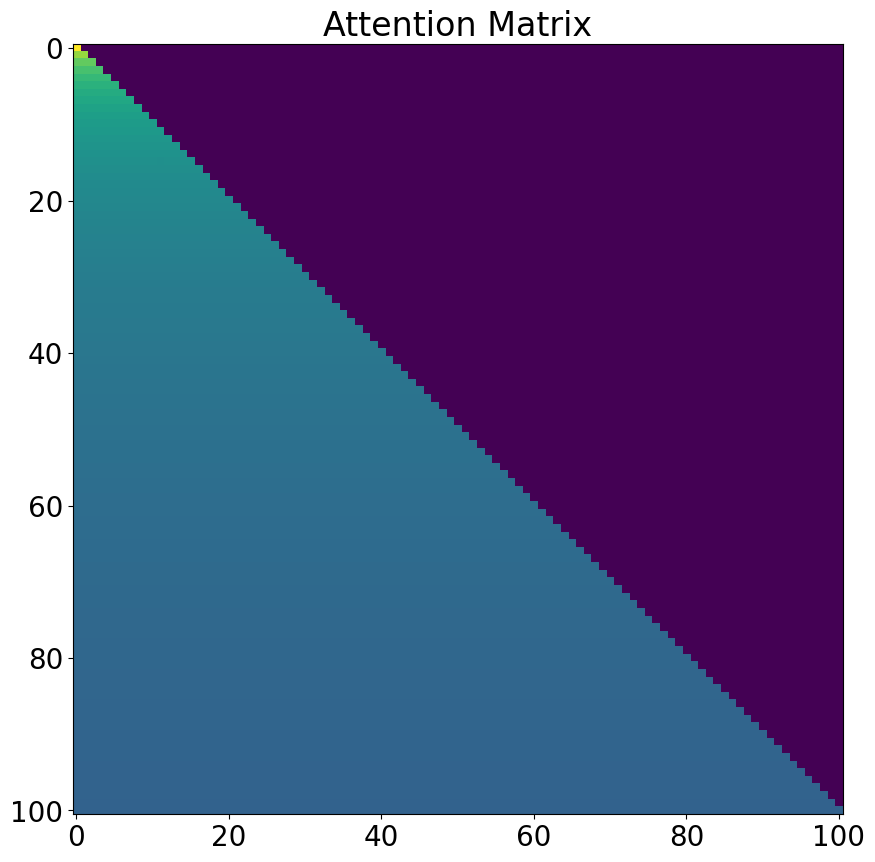

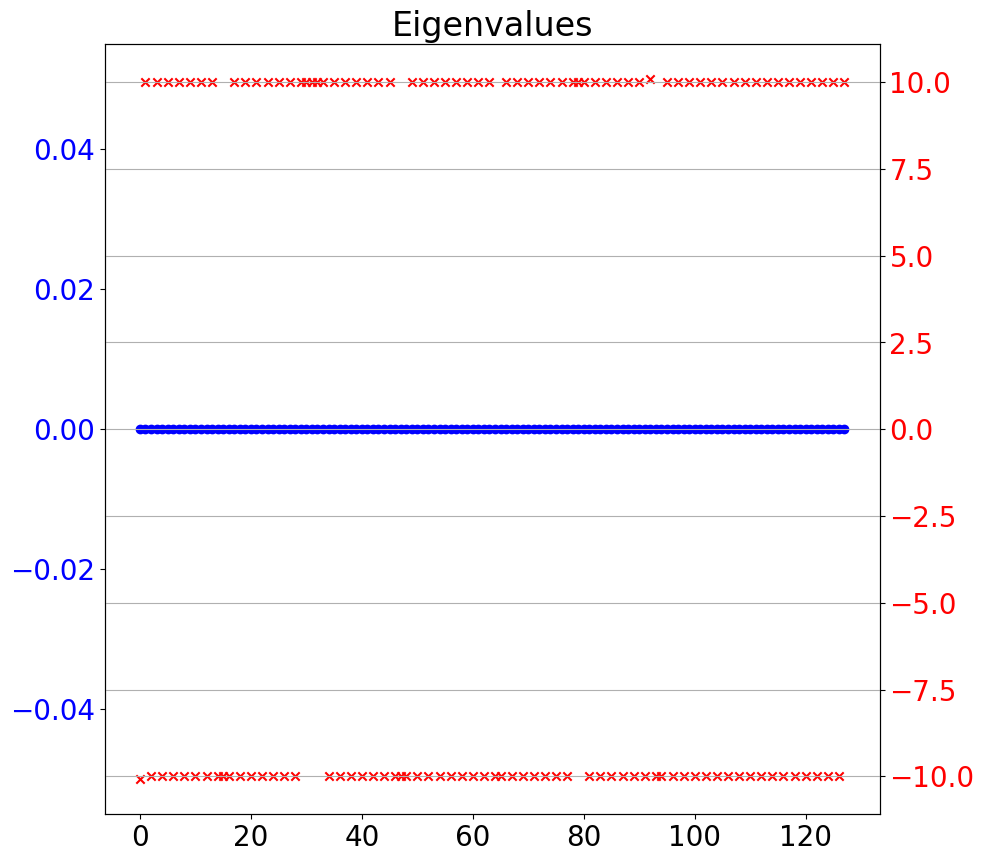

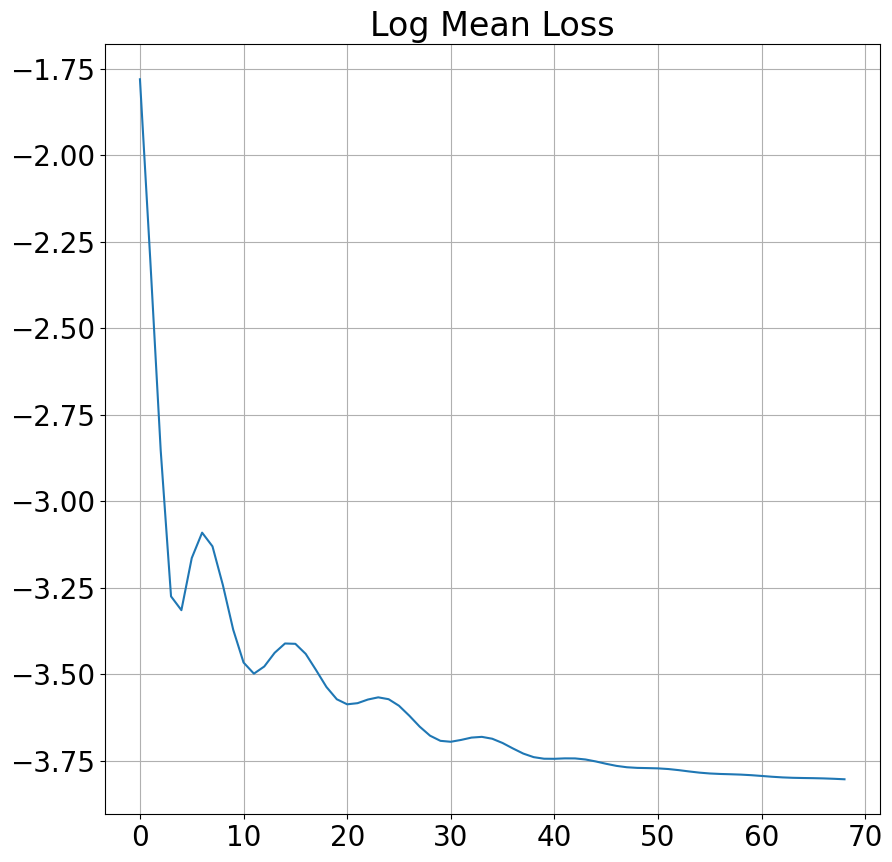

Training progress...:   7%|████▎                                                     | 74/1000 [01:18<14:12,  1.09it/s]

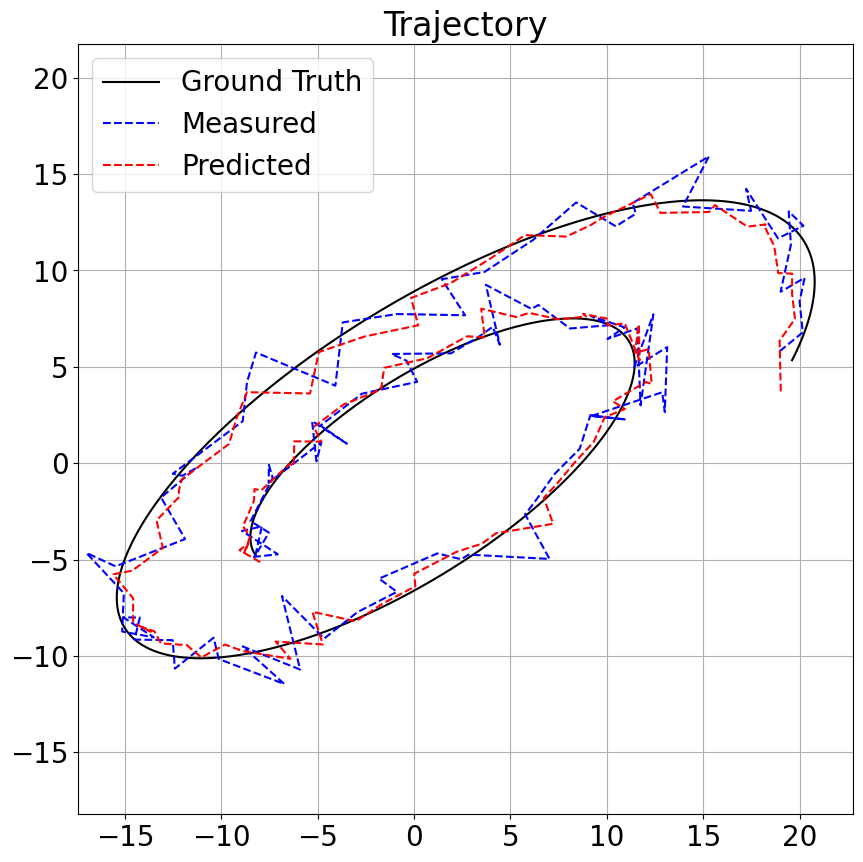

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


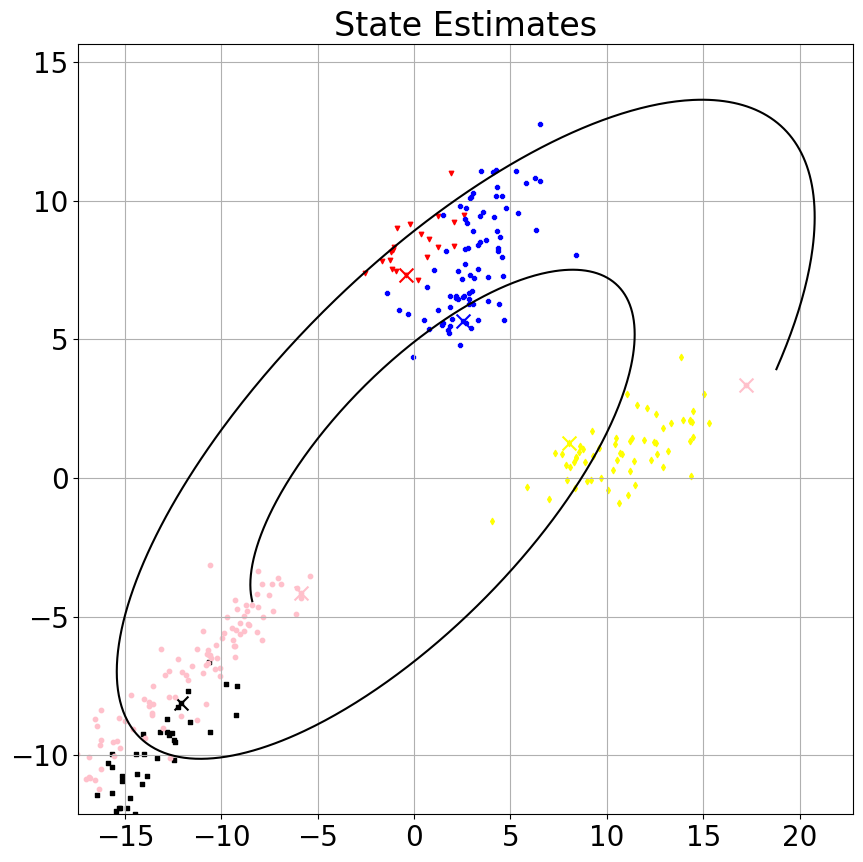

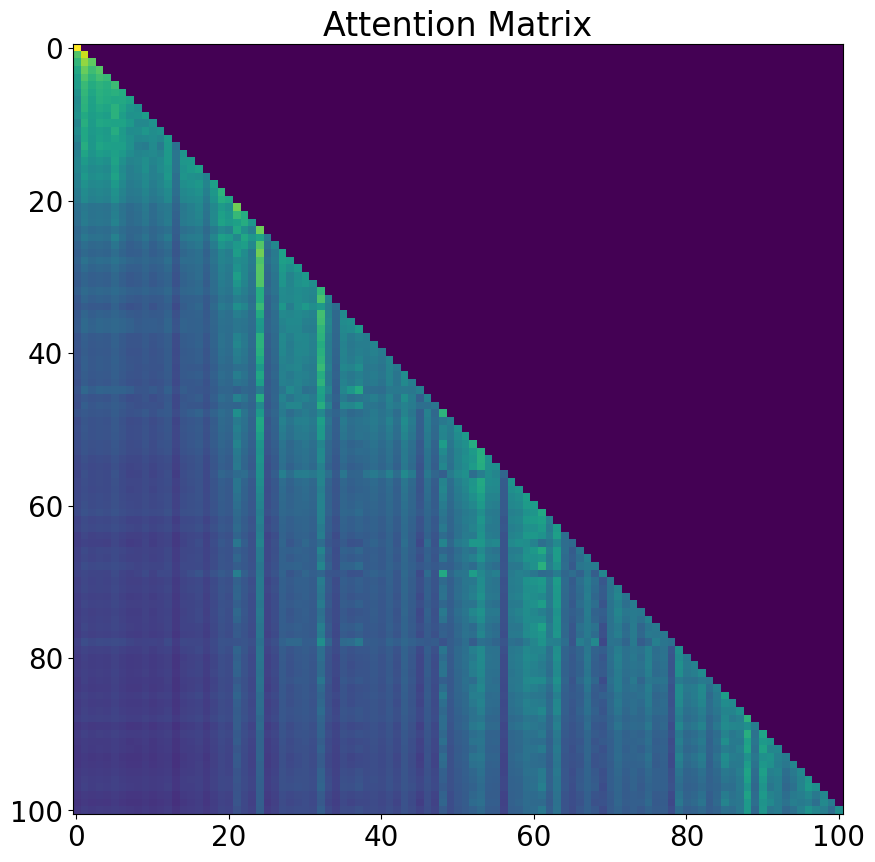

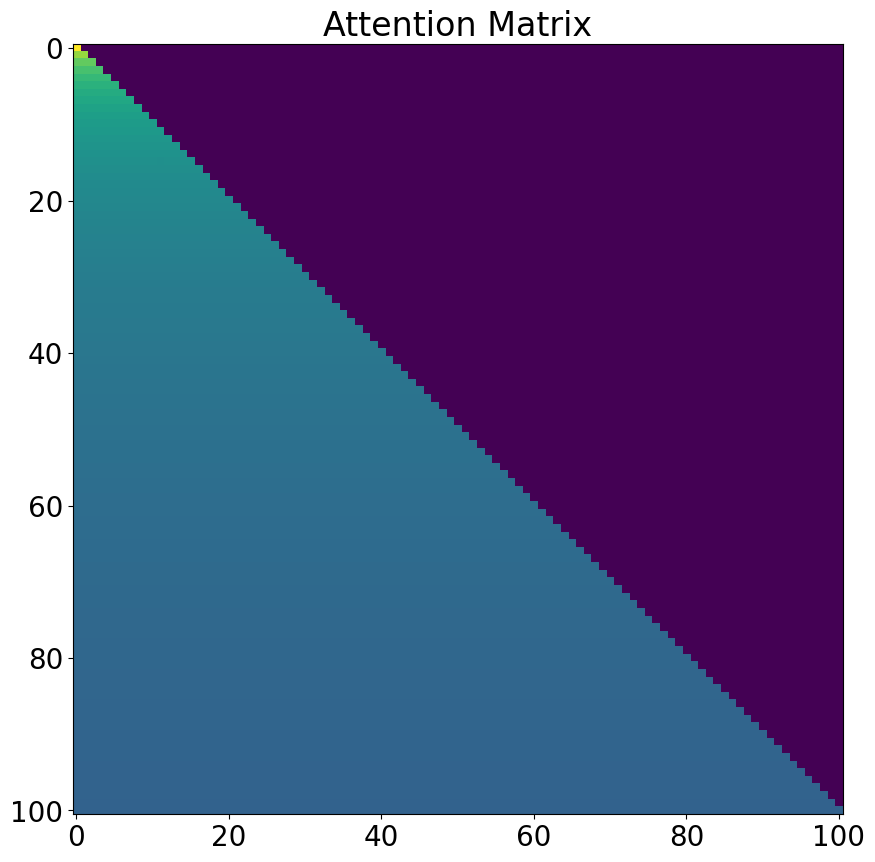

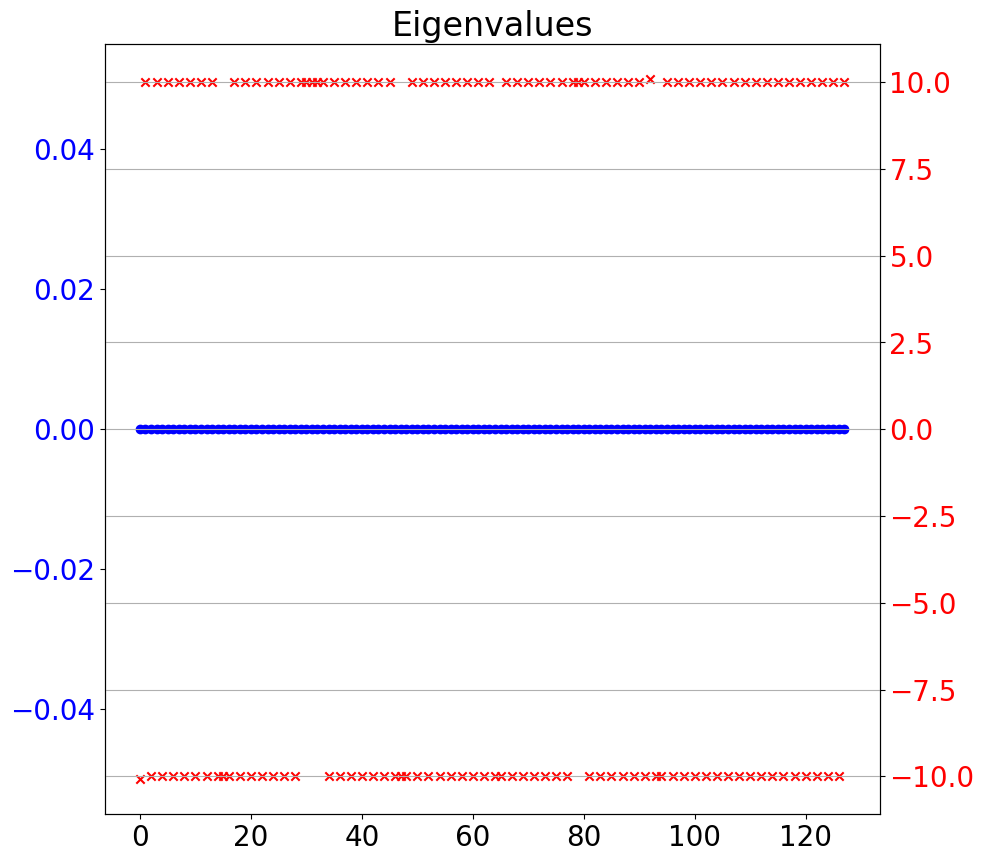

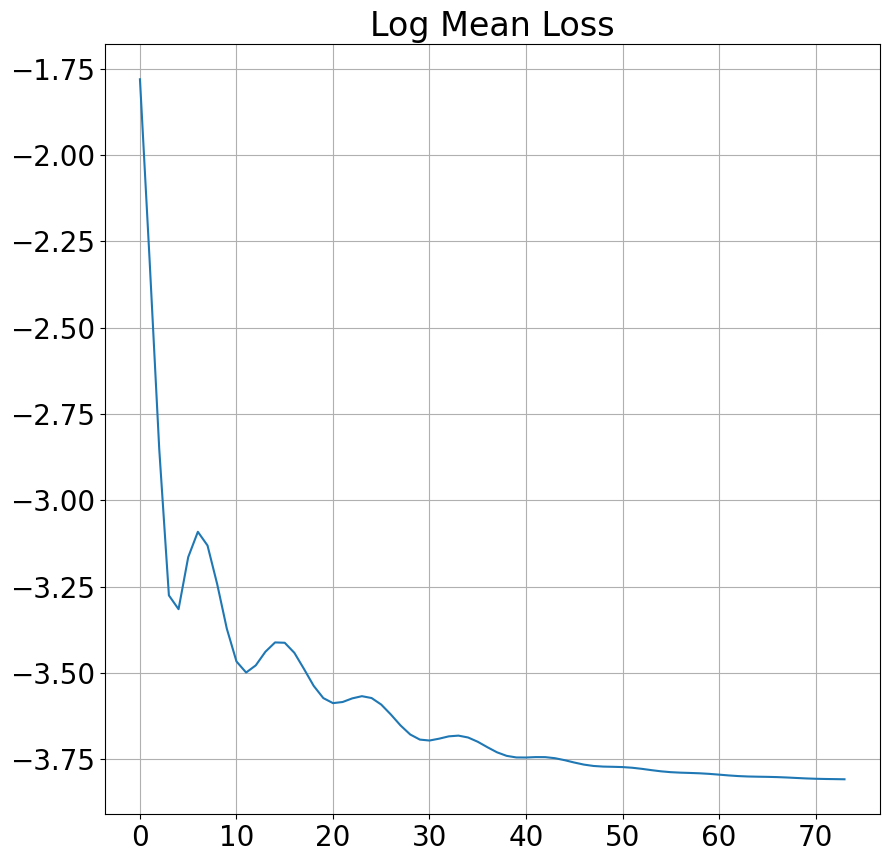

Training progress...:   8%|████▌                                                     | 79/1000 [01:23<14:15,  1.08it/s]

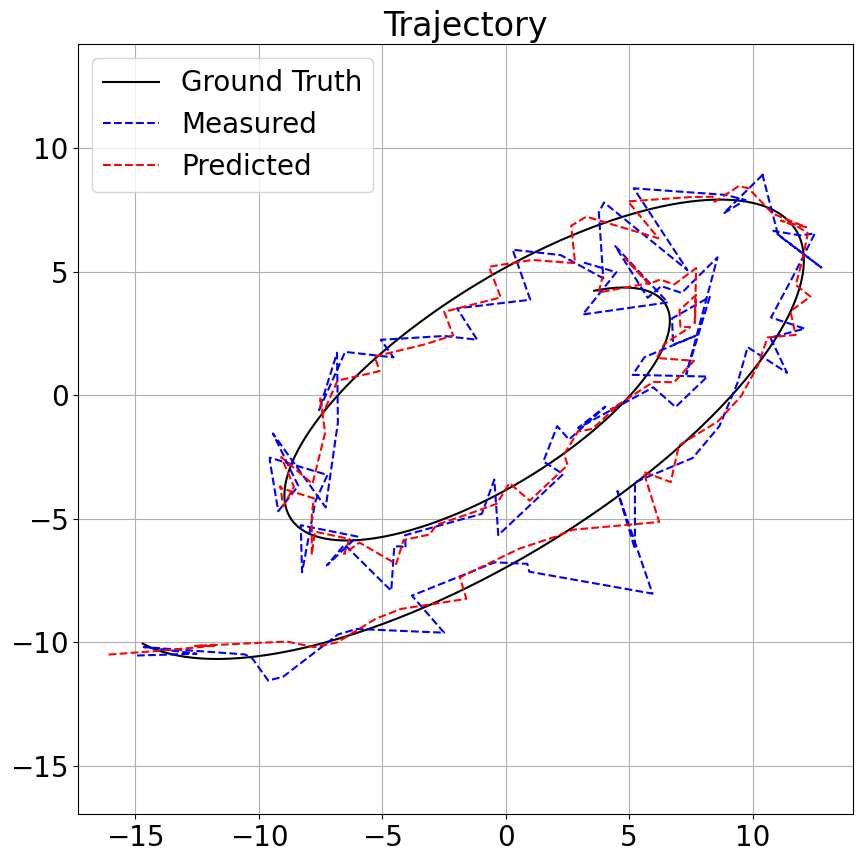

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


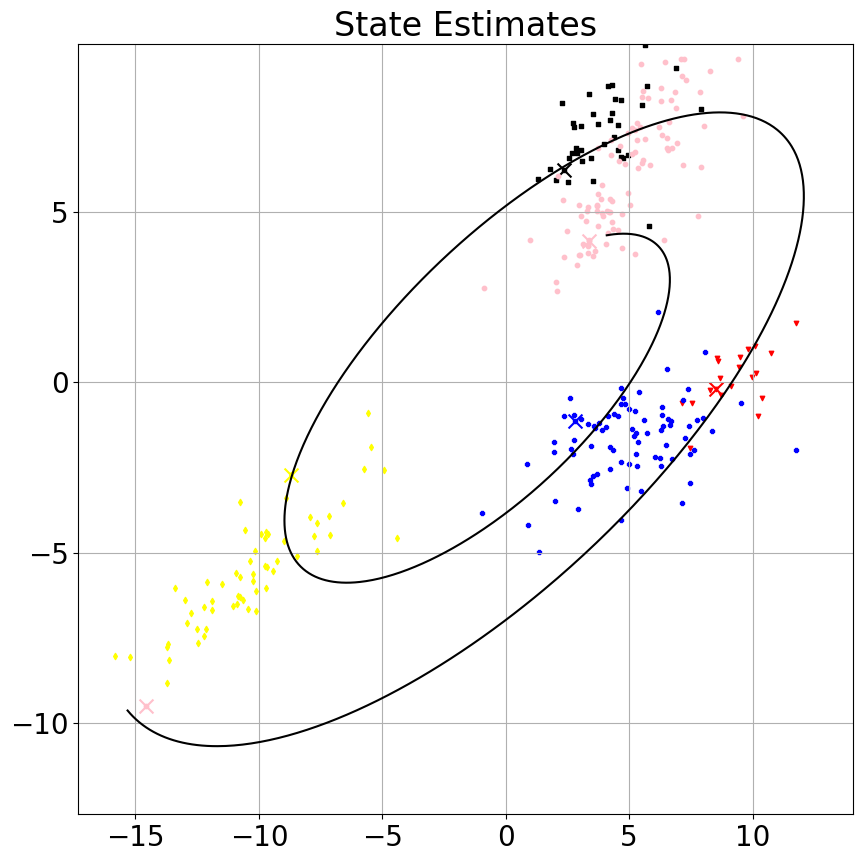

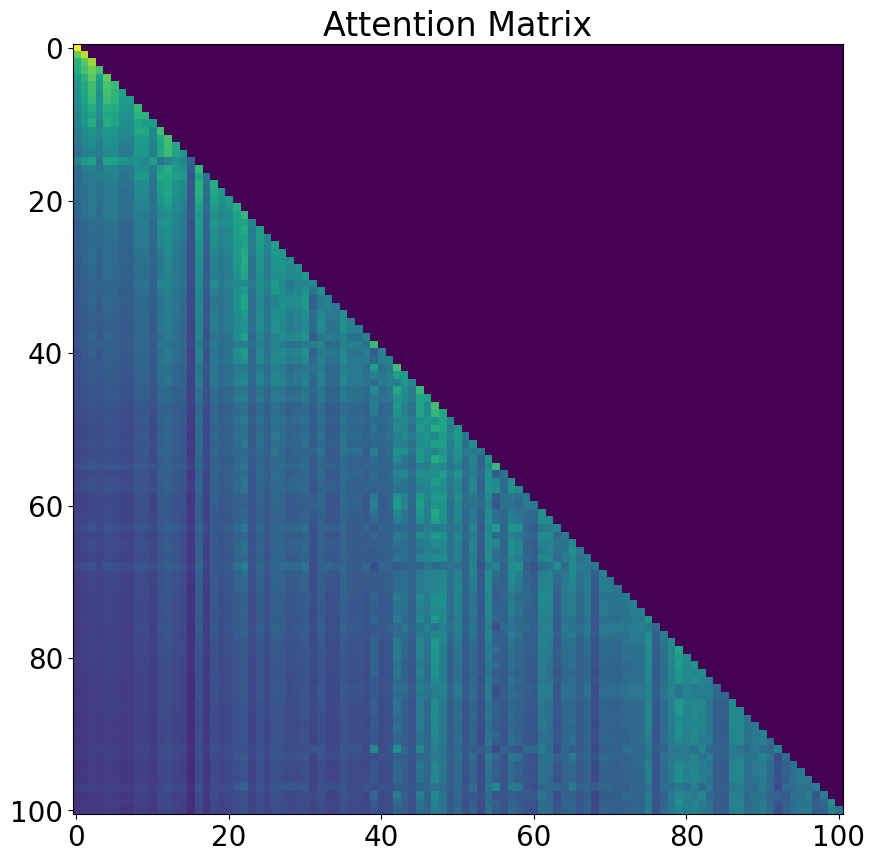

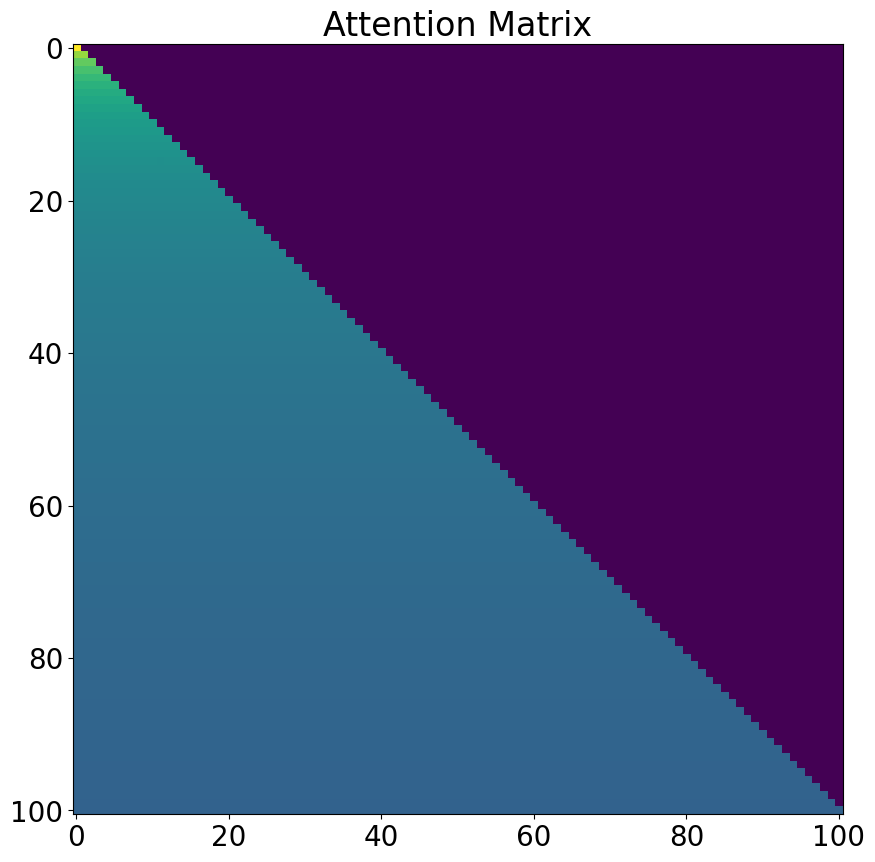

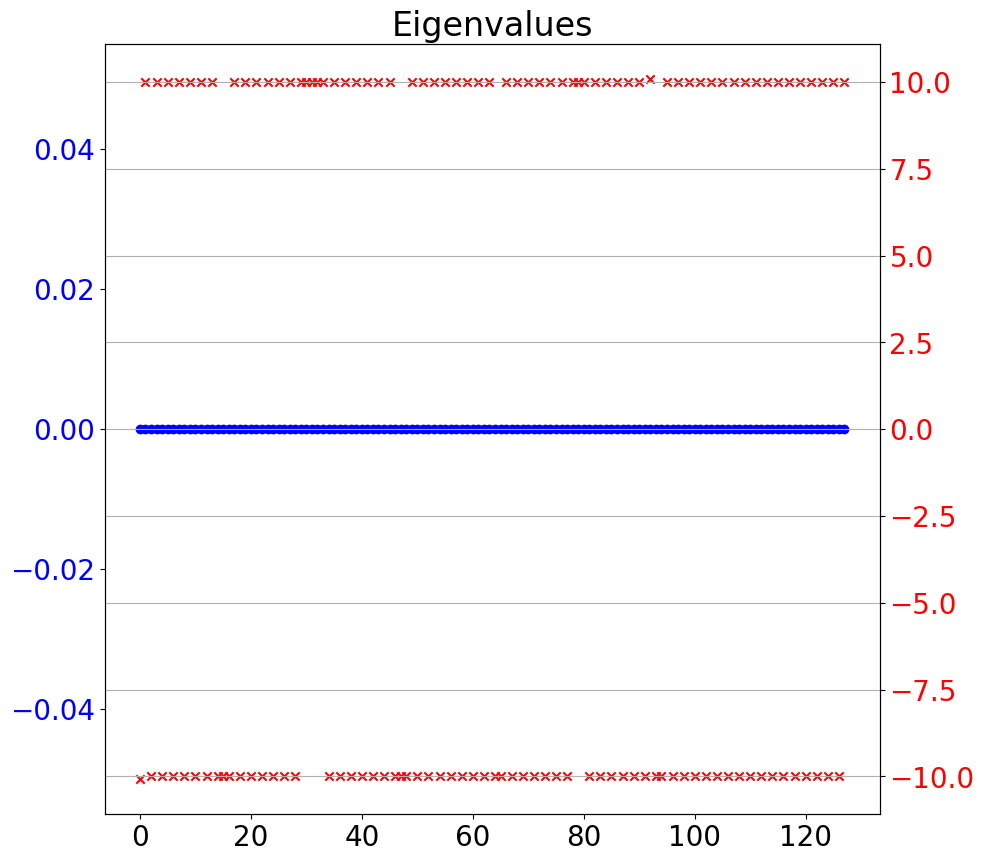

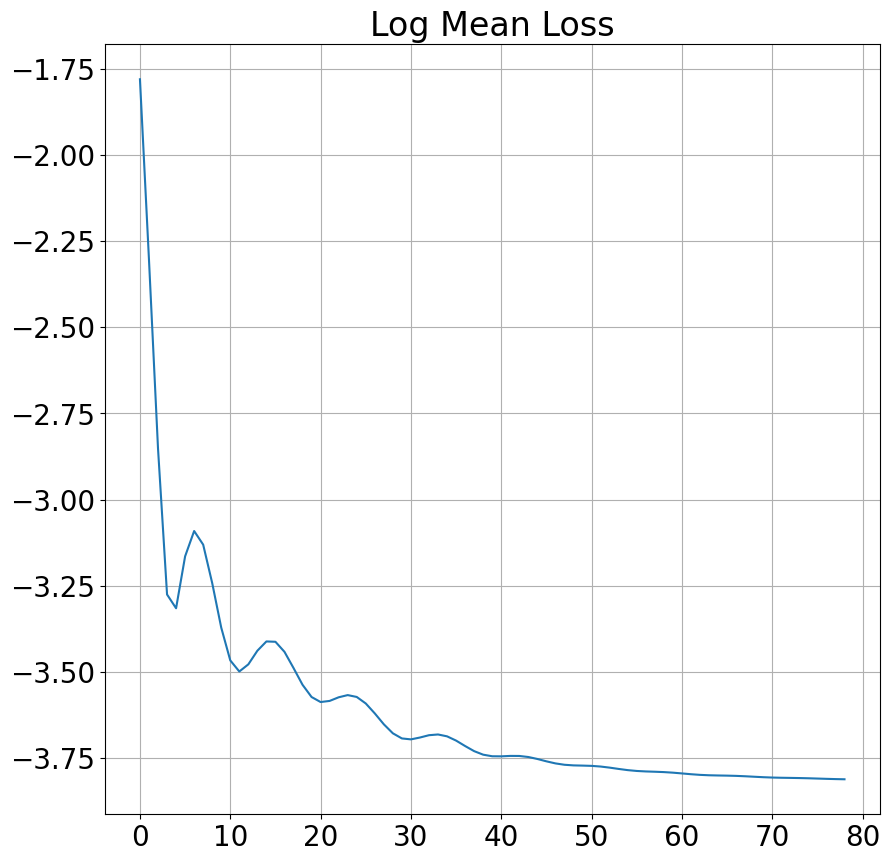

Training progress...:   8%|████▊                                                     | 84/1000 [01:28<13:51,  1.10it/s]

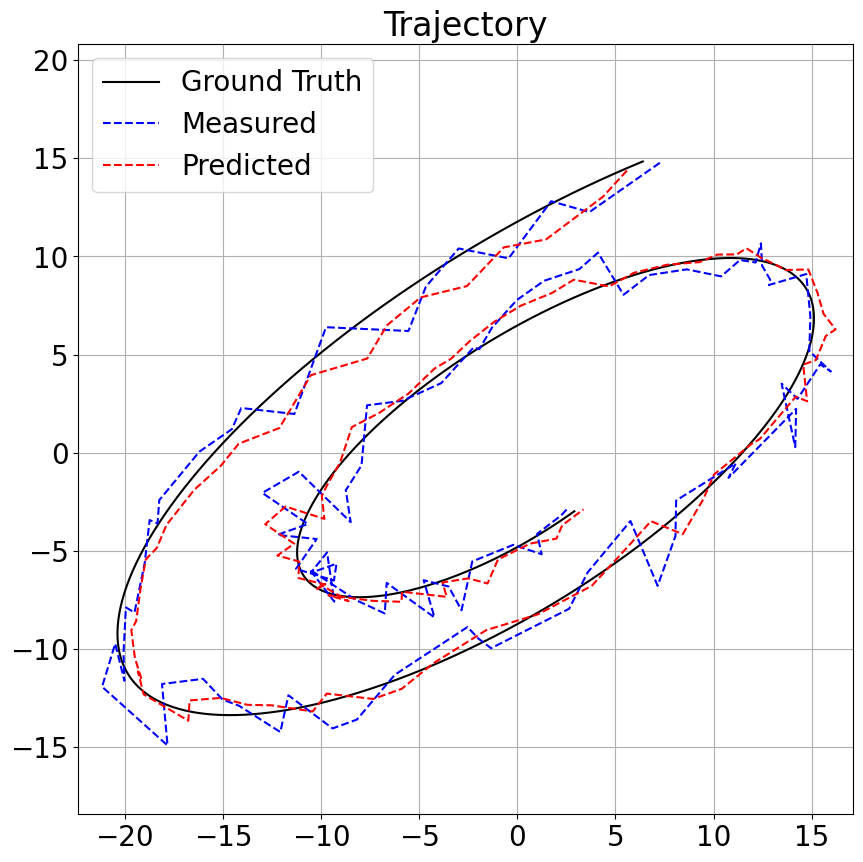

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


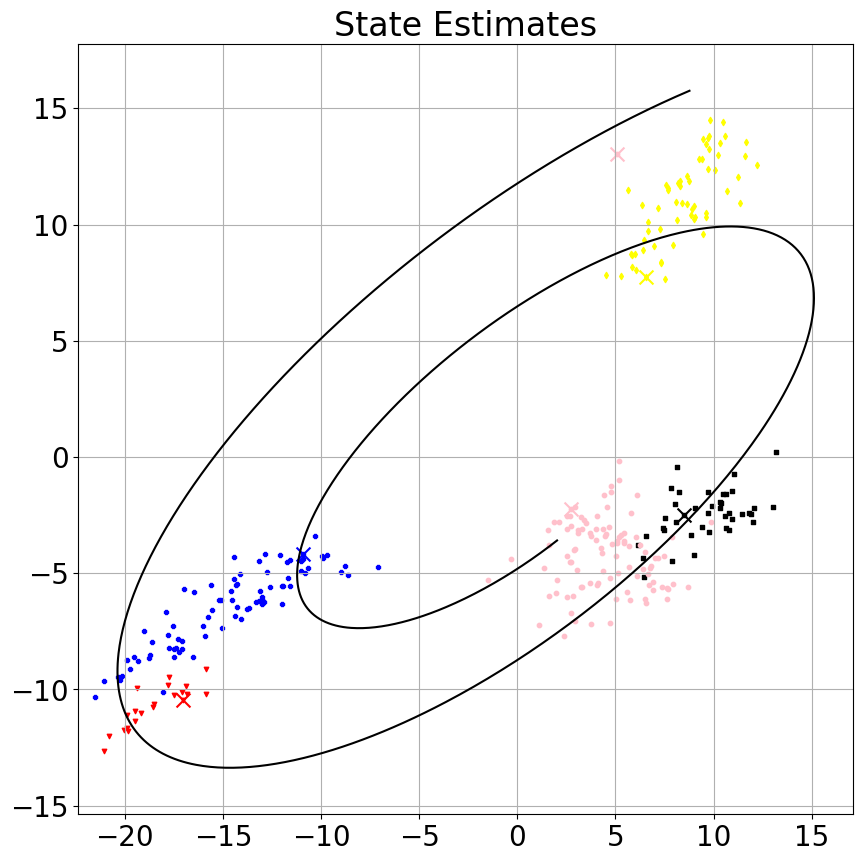

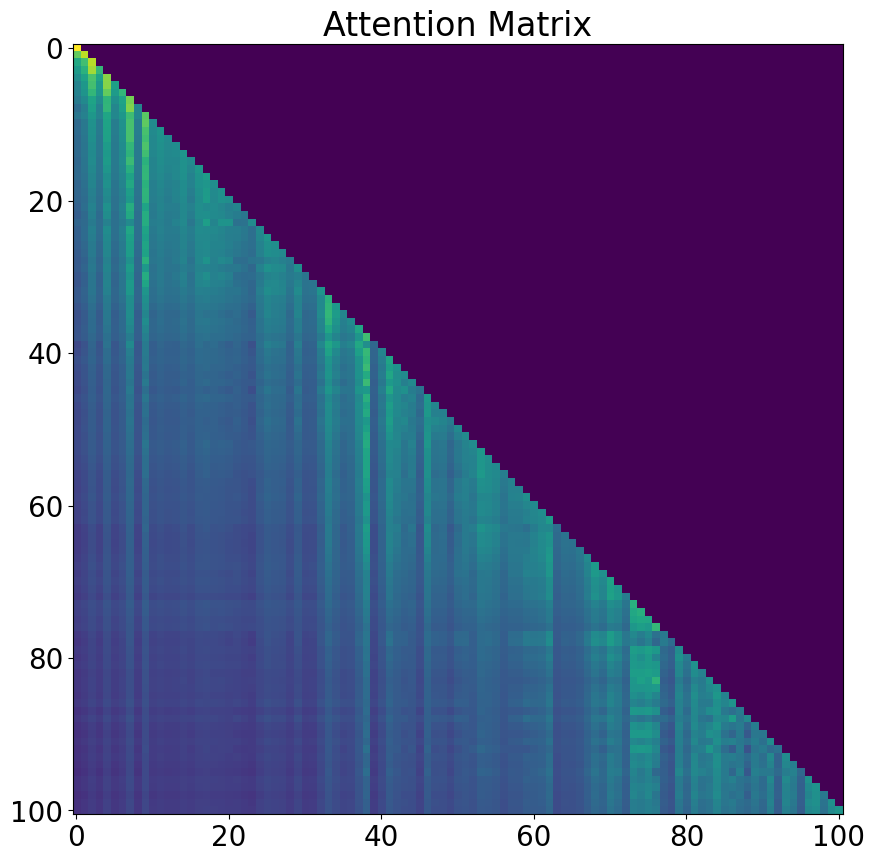

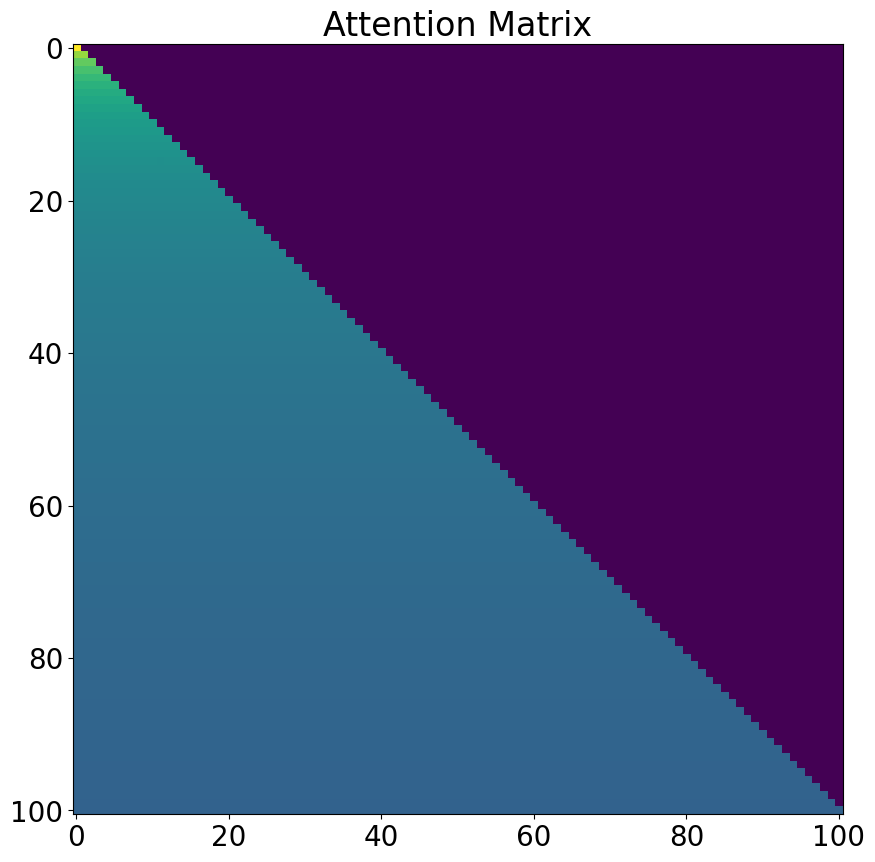

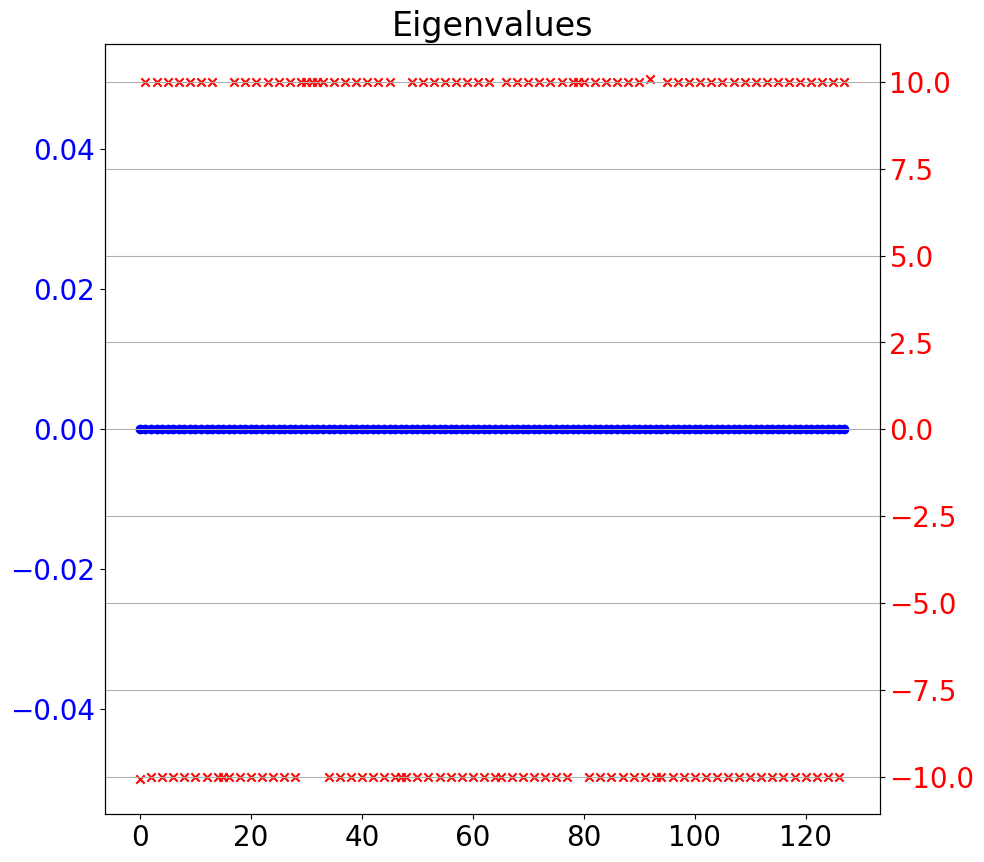

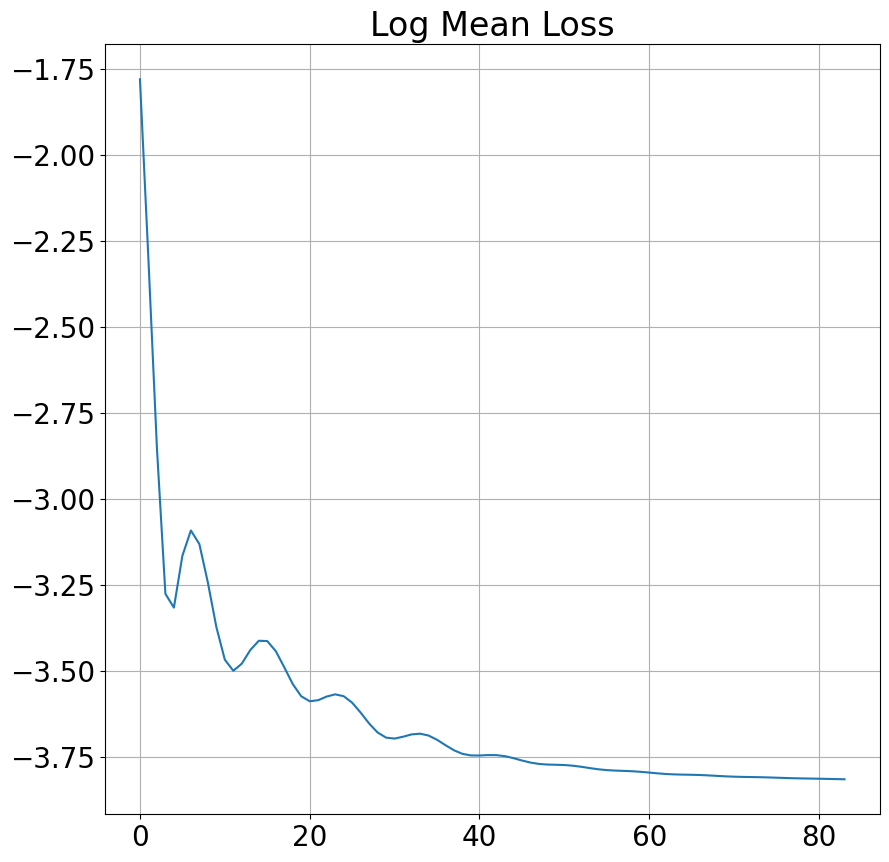

Training progress...:   9%|█████▏                                                    | 89/1000 [01:34<14:20,  1.06it/s]

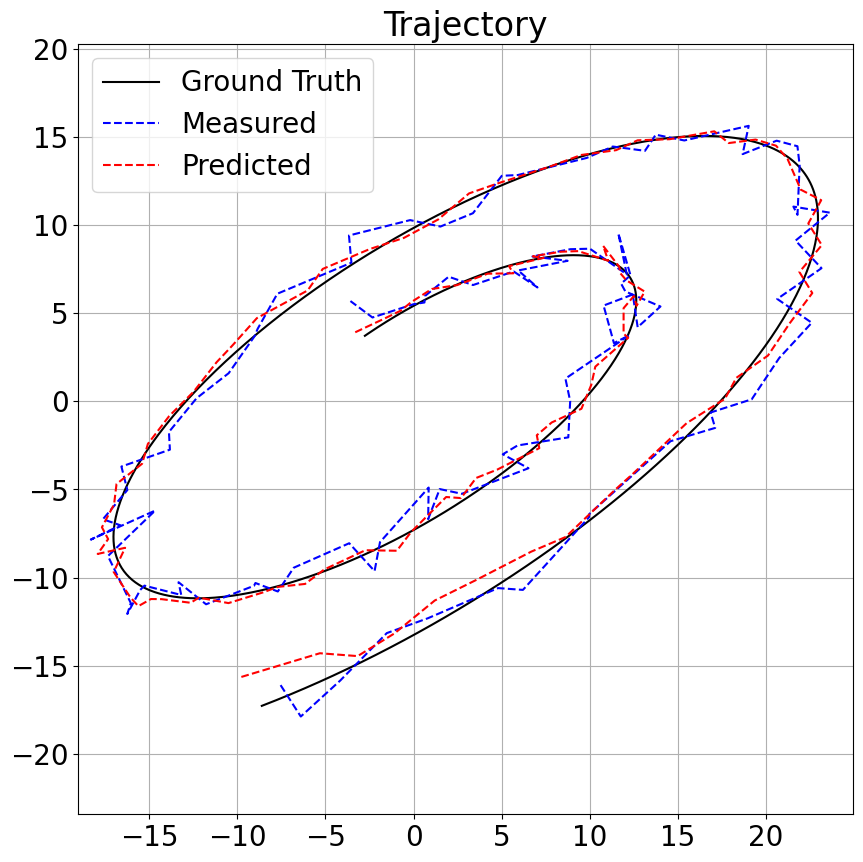

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


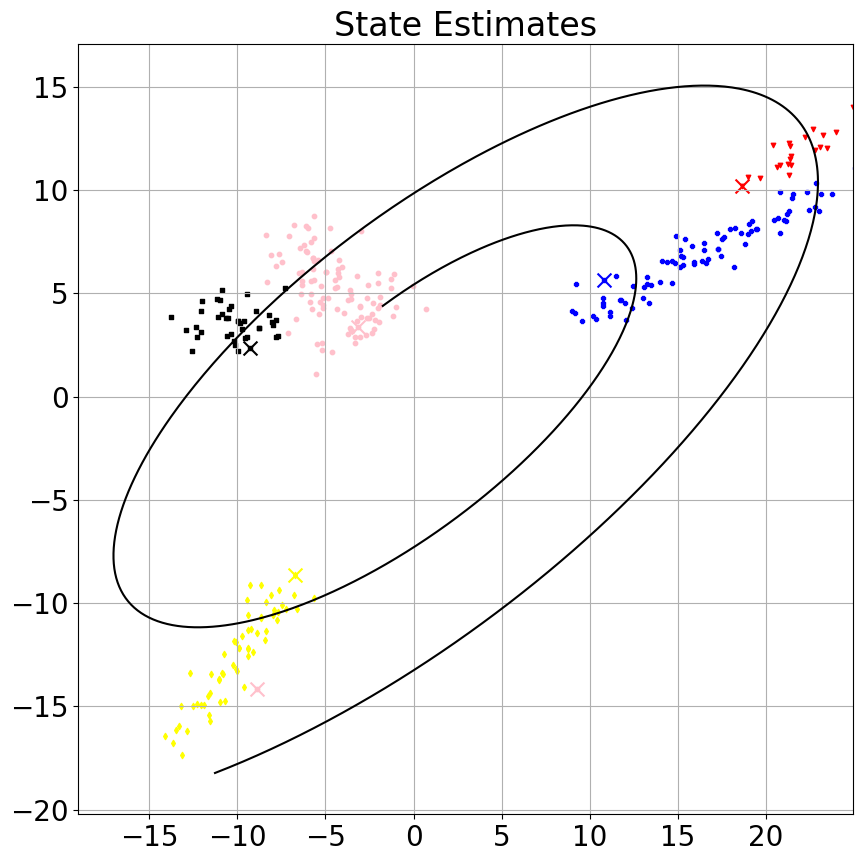

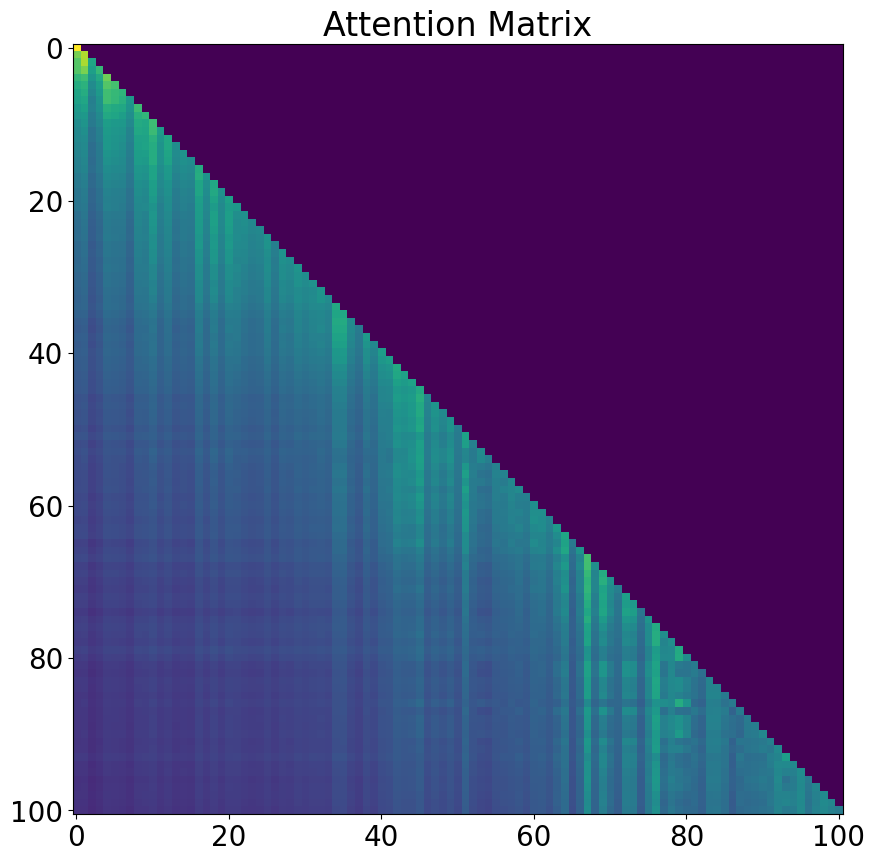

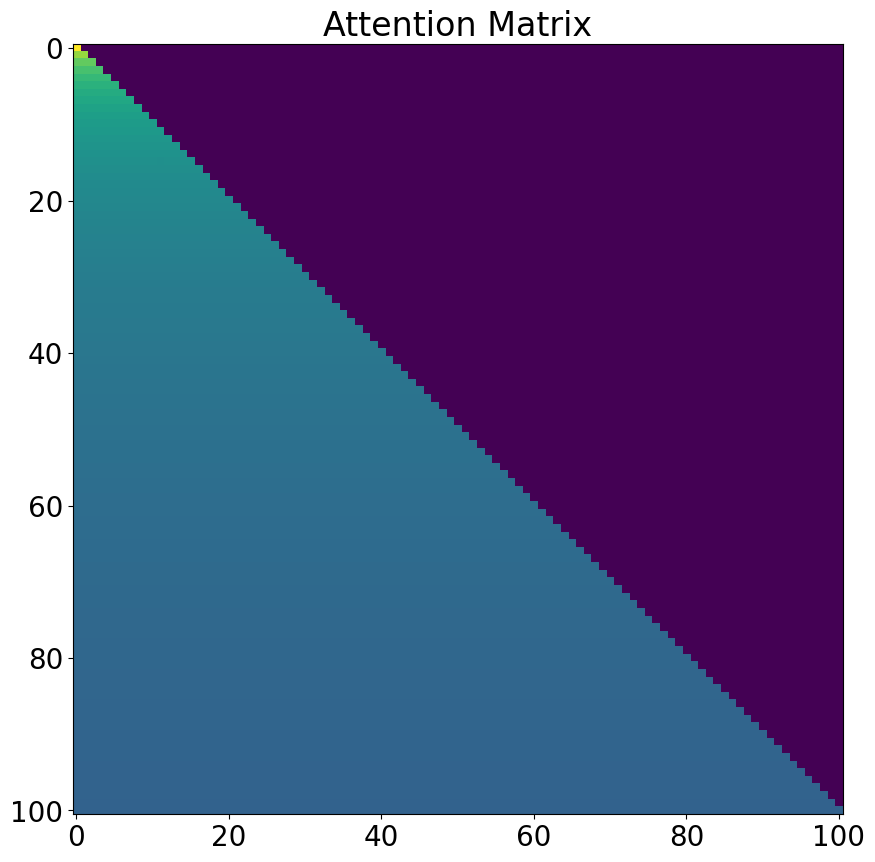

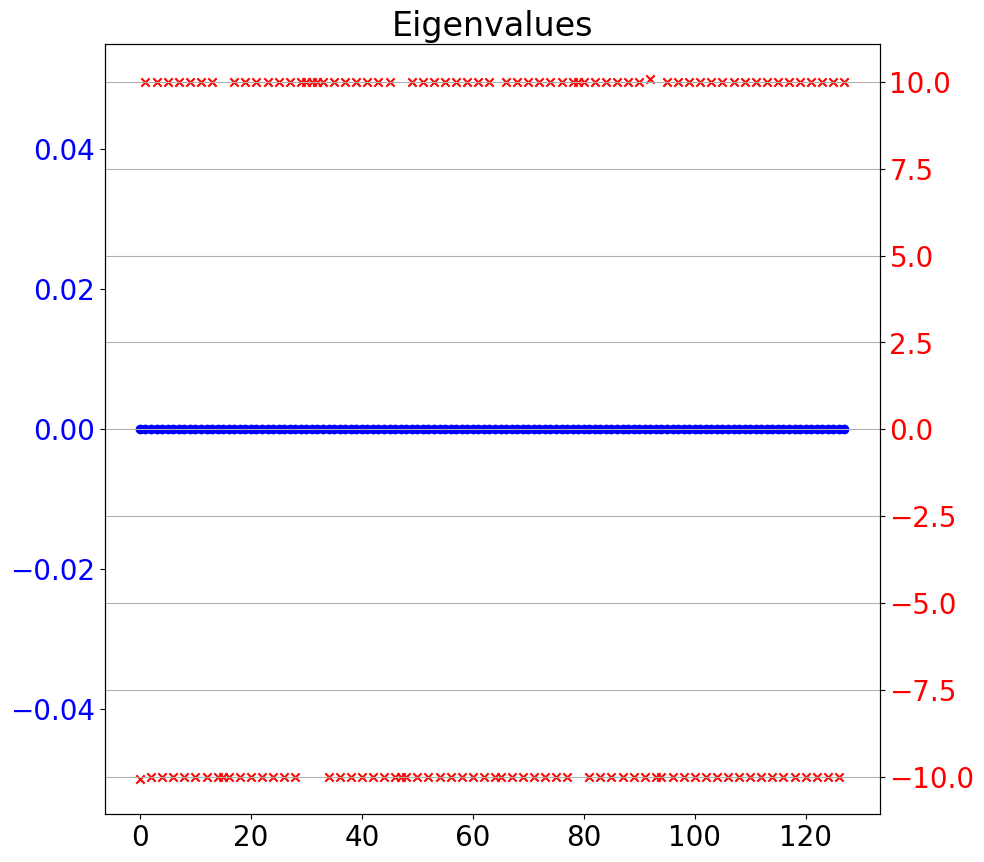

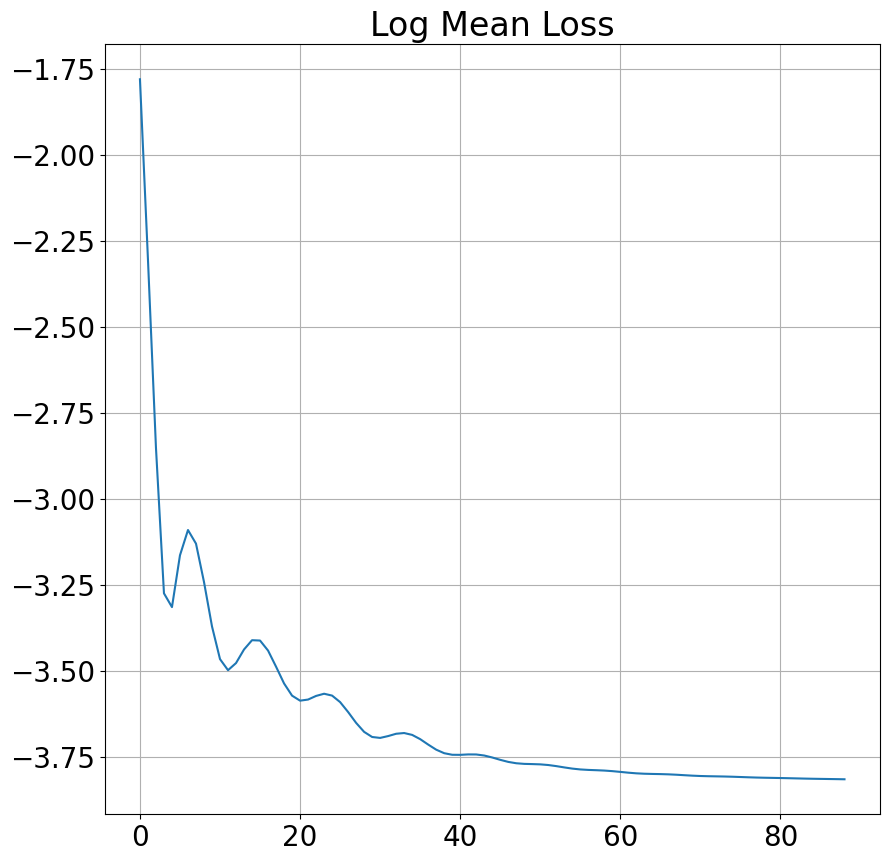

Training progress...:   9%|█████▍                                                    | 94/1000 [01:39<14:37,  1.03it/s]

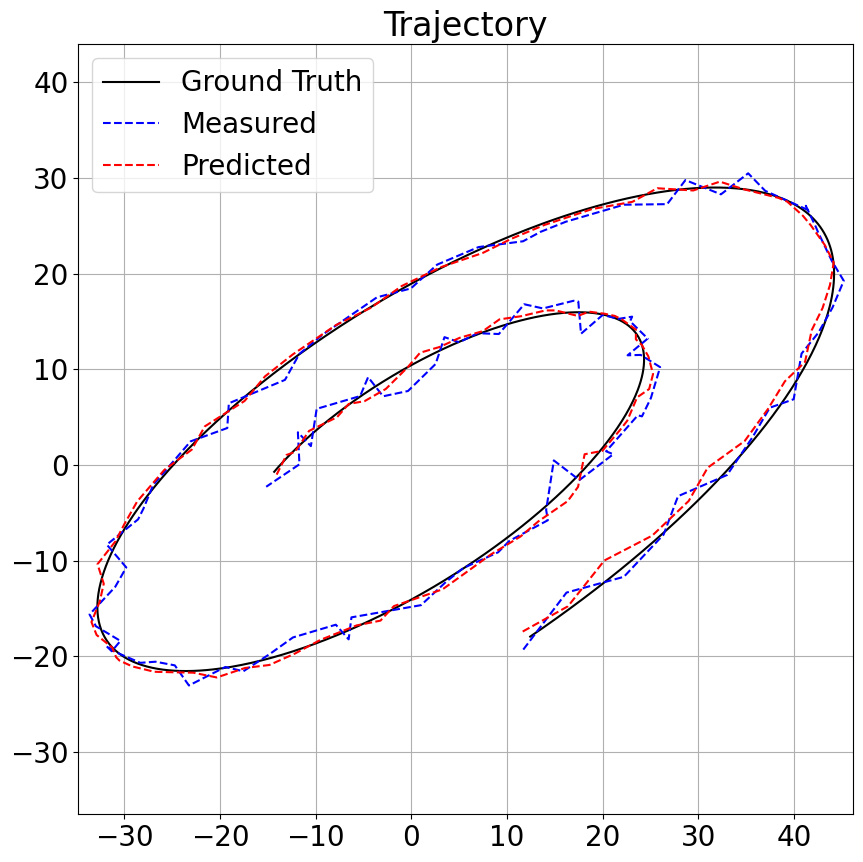

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


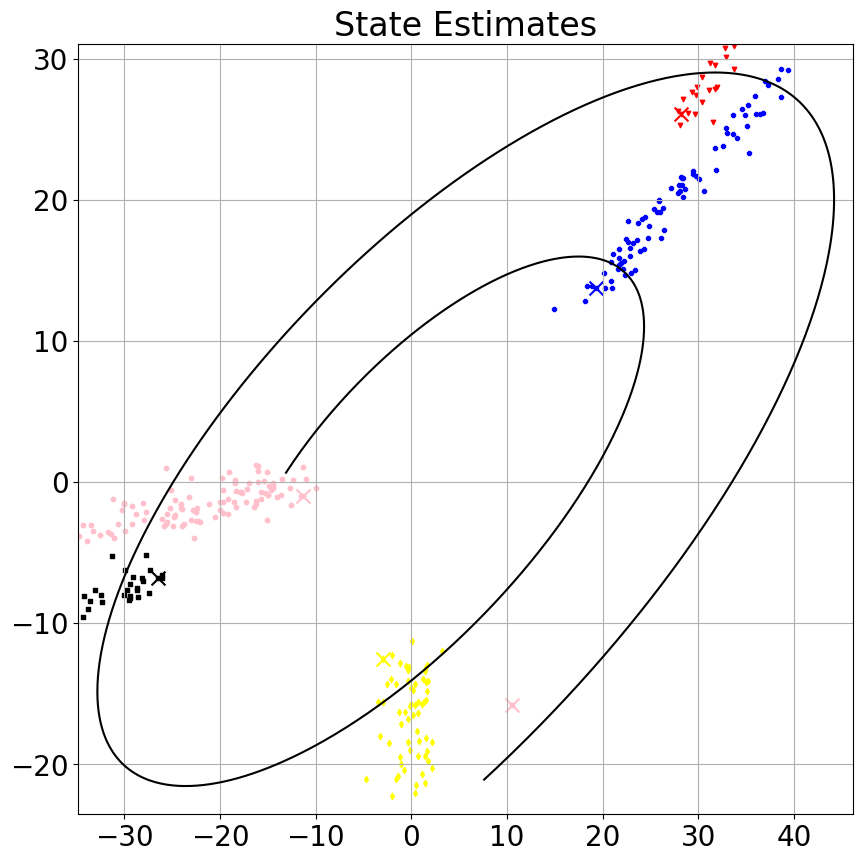

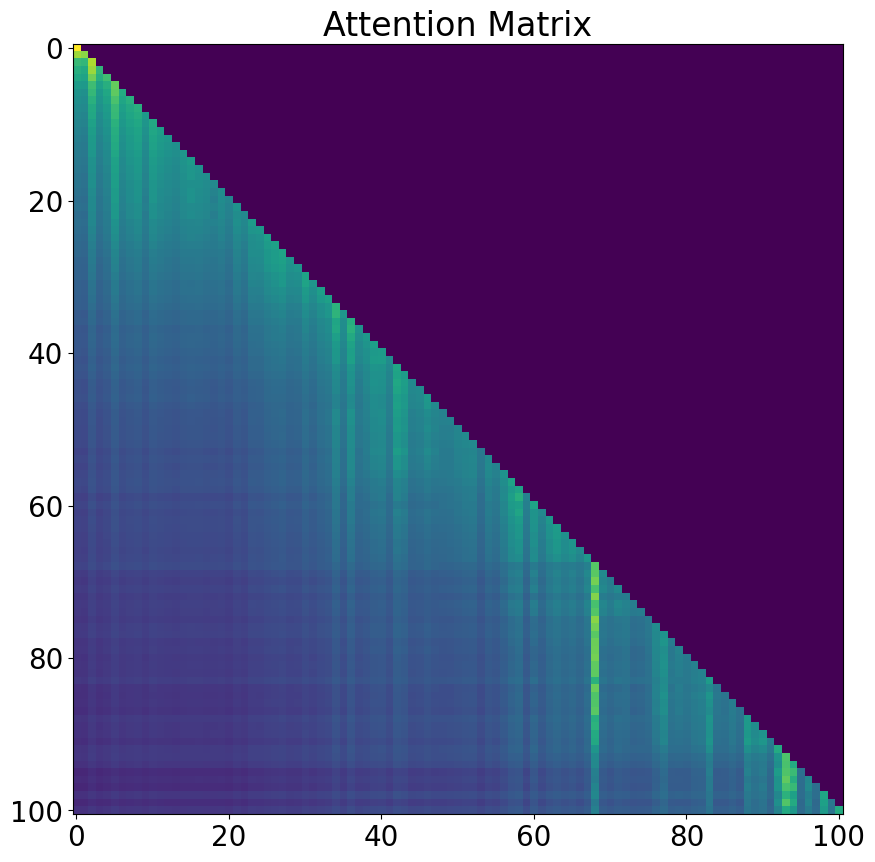

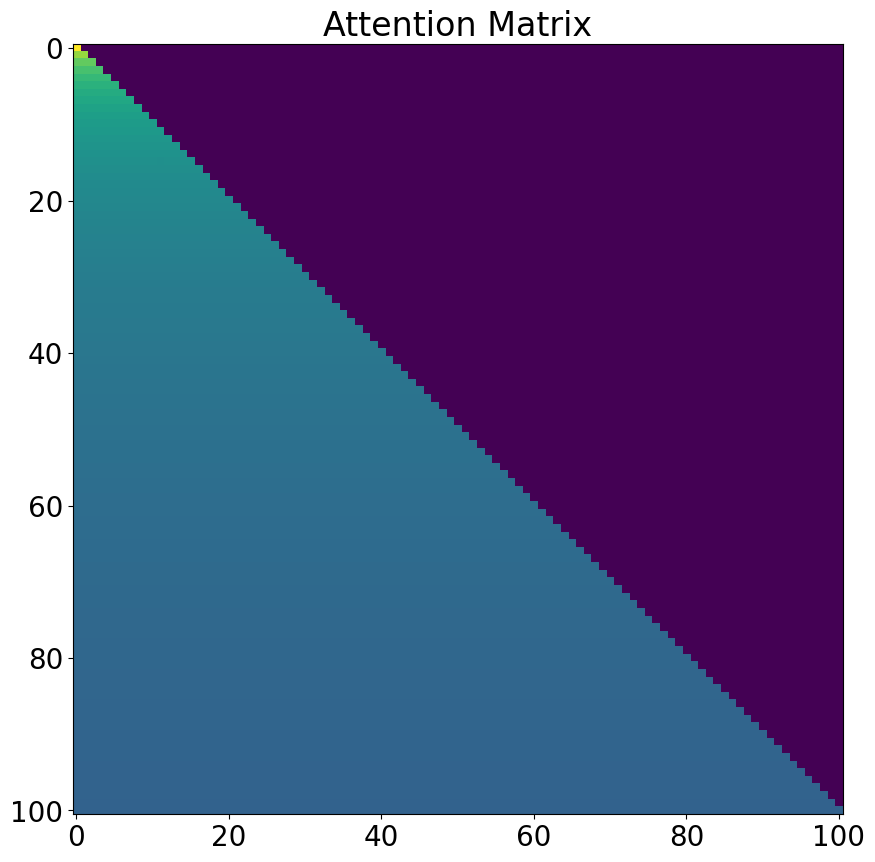

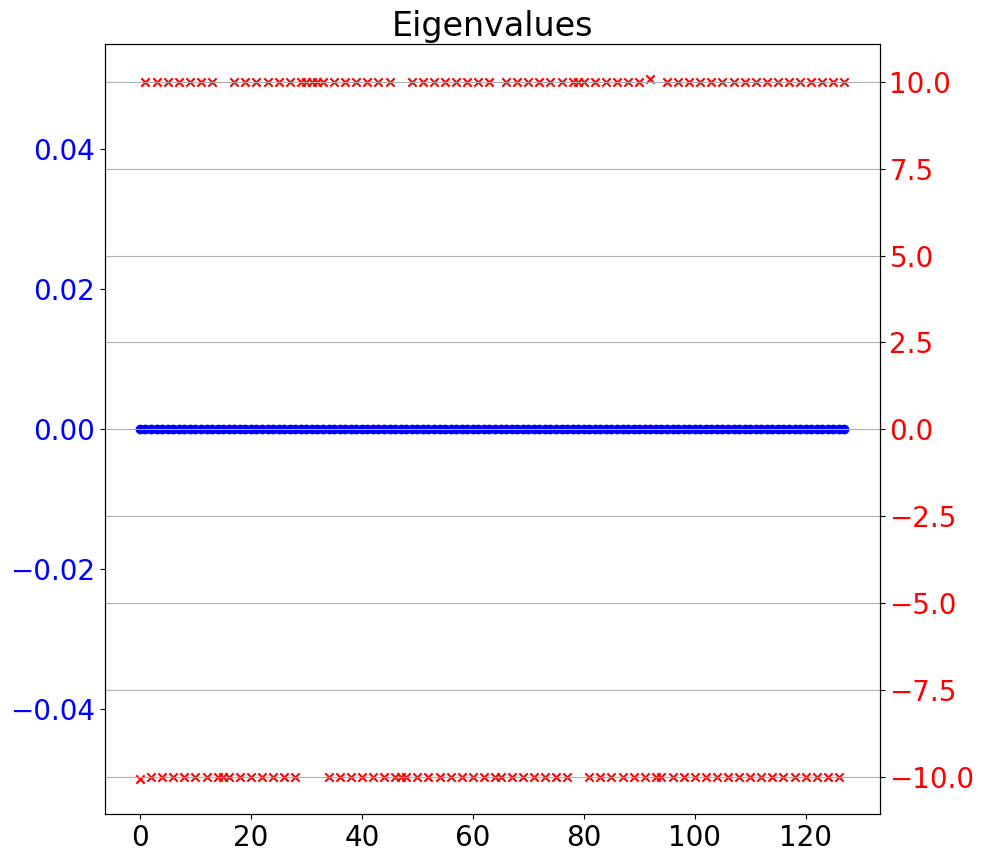

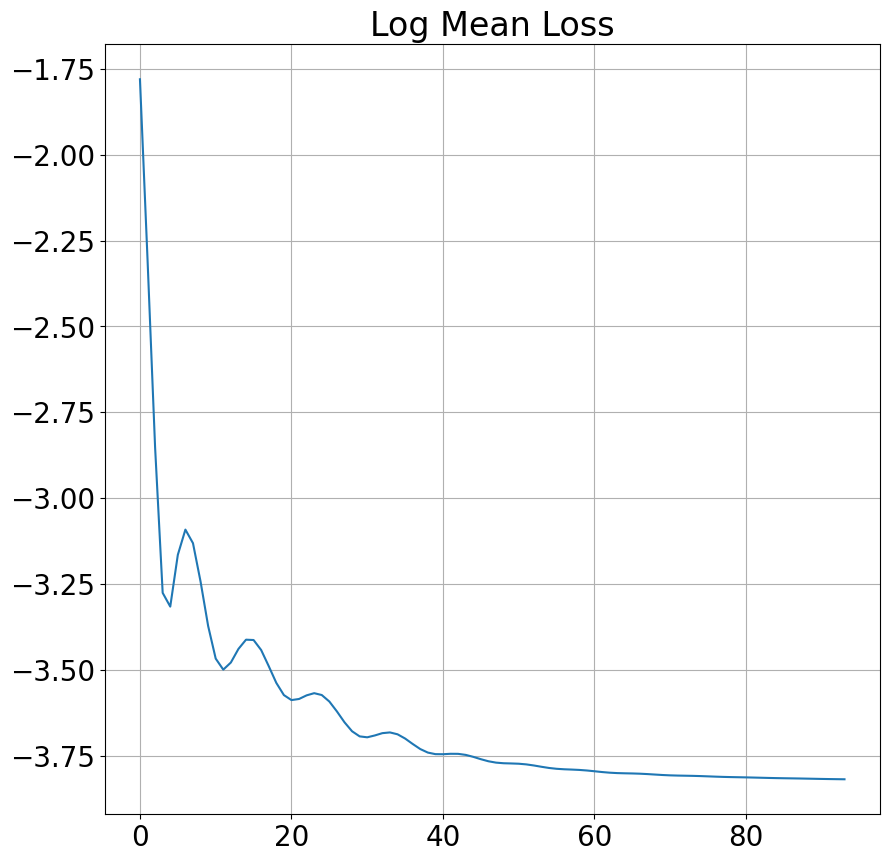

Training progress...:  10%|█████▋                                                    | 99/1000 [01:45<14:11,  1.06it/s]

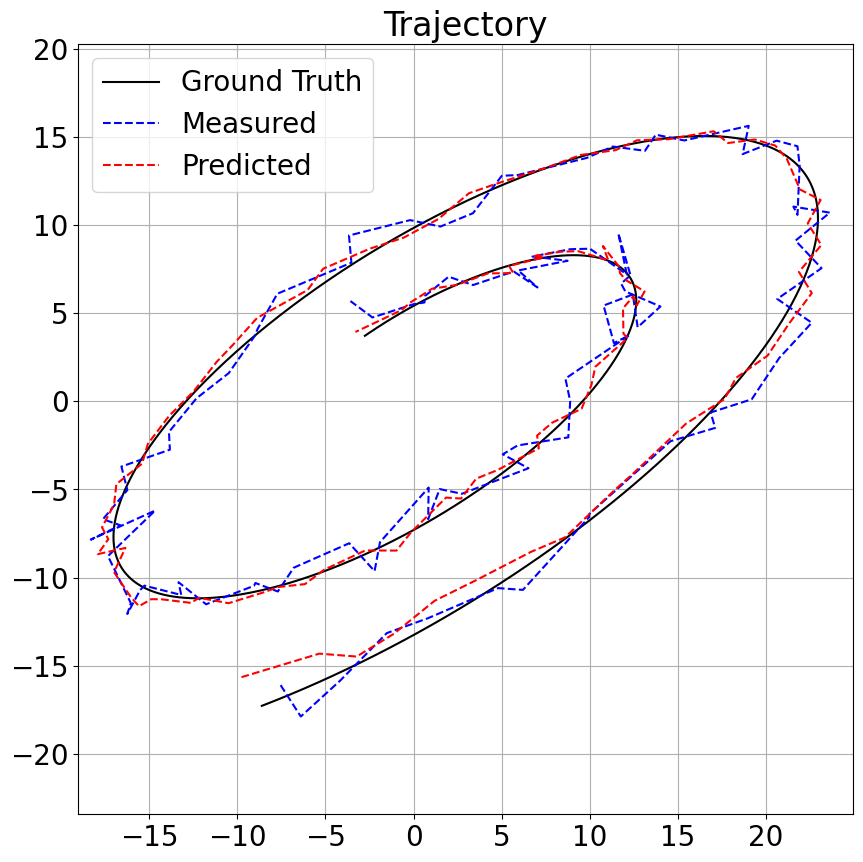

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


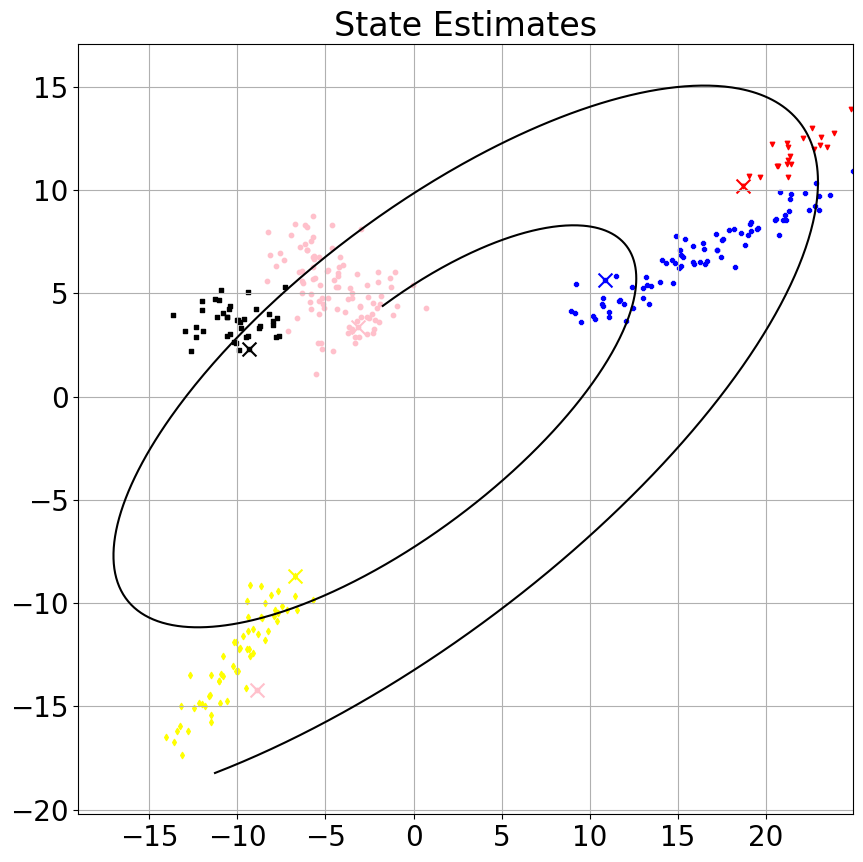

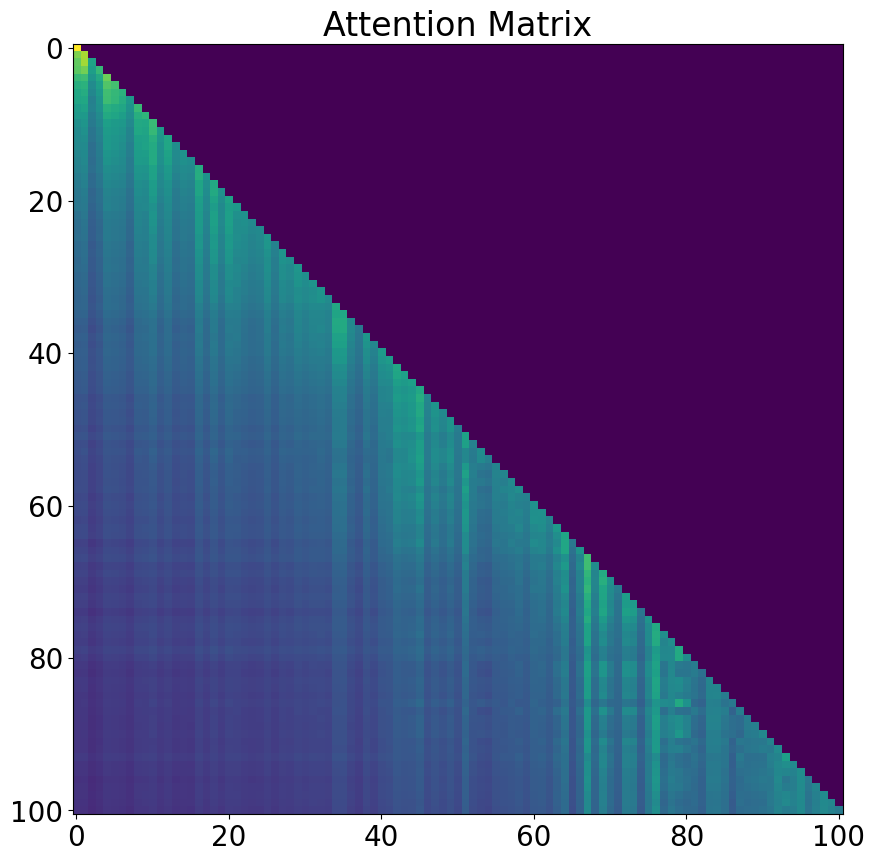

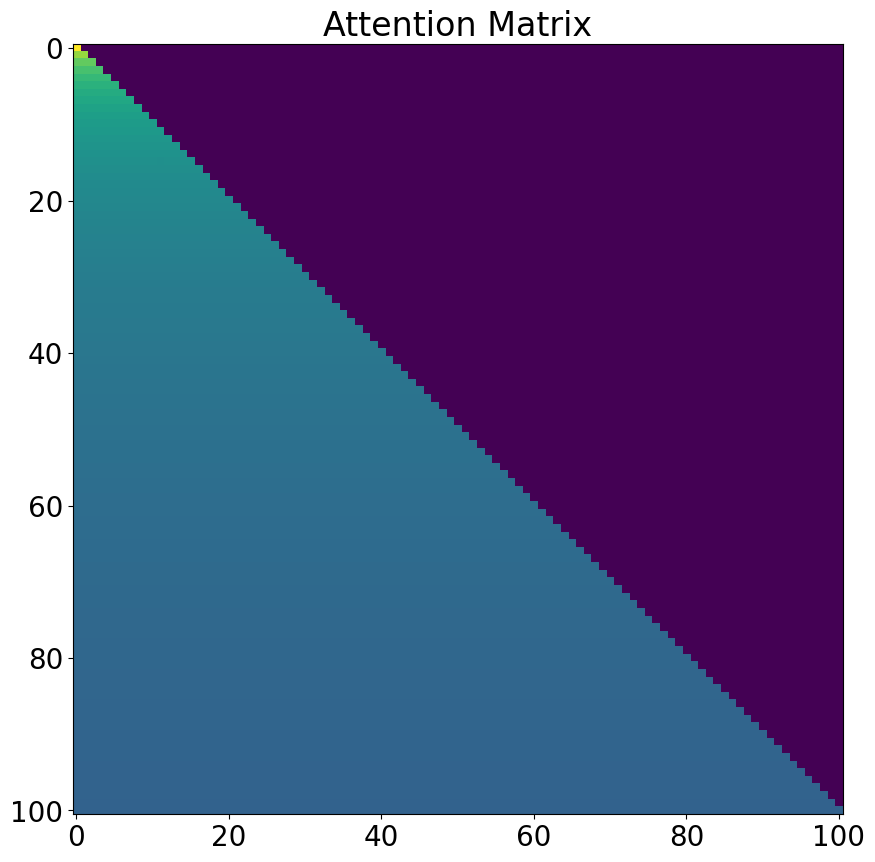

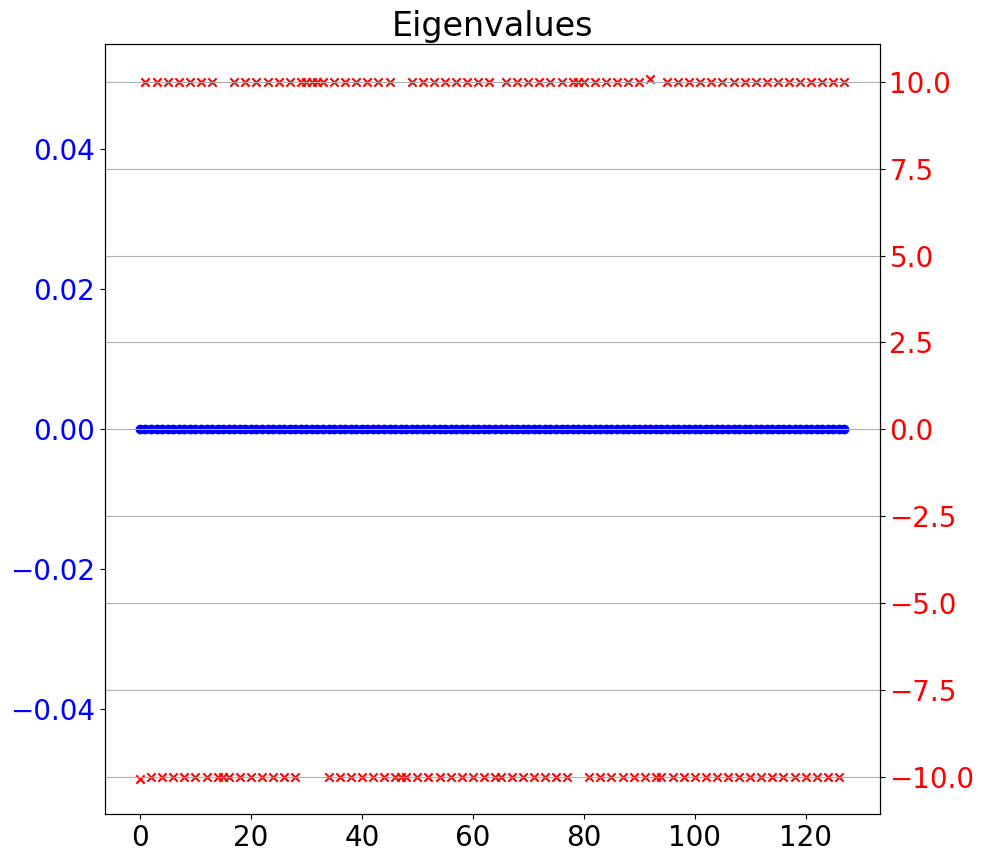

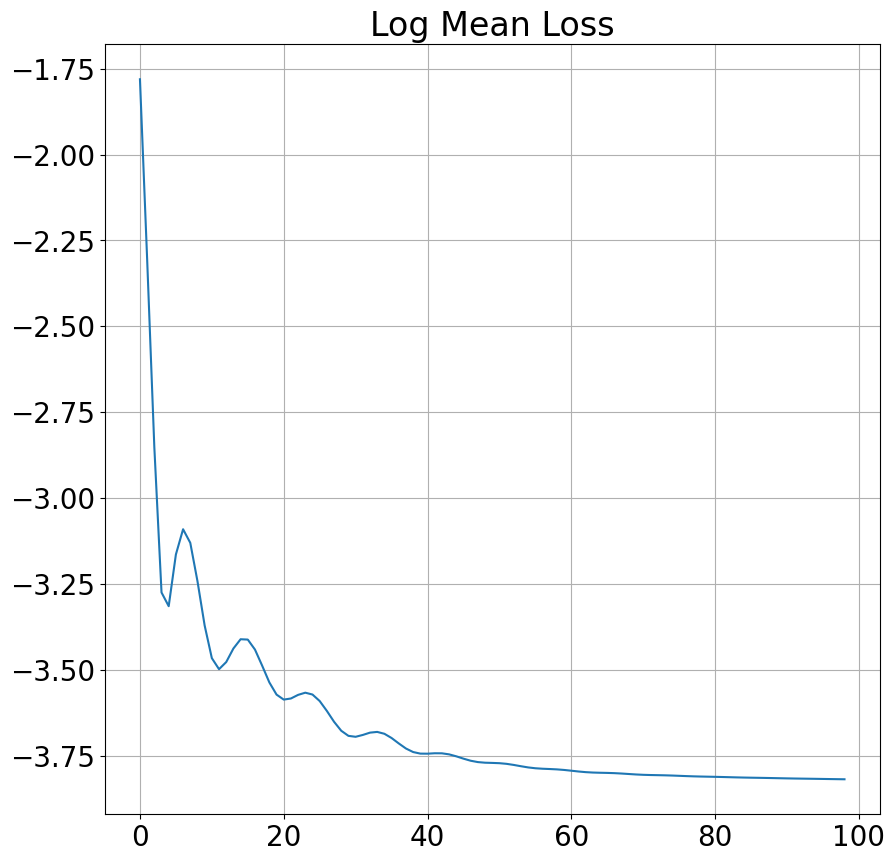

Training progress...:  10%|█████▉                                                   | 104/1000 [01:50<14:09,  1.05it/s]

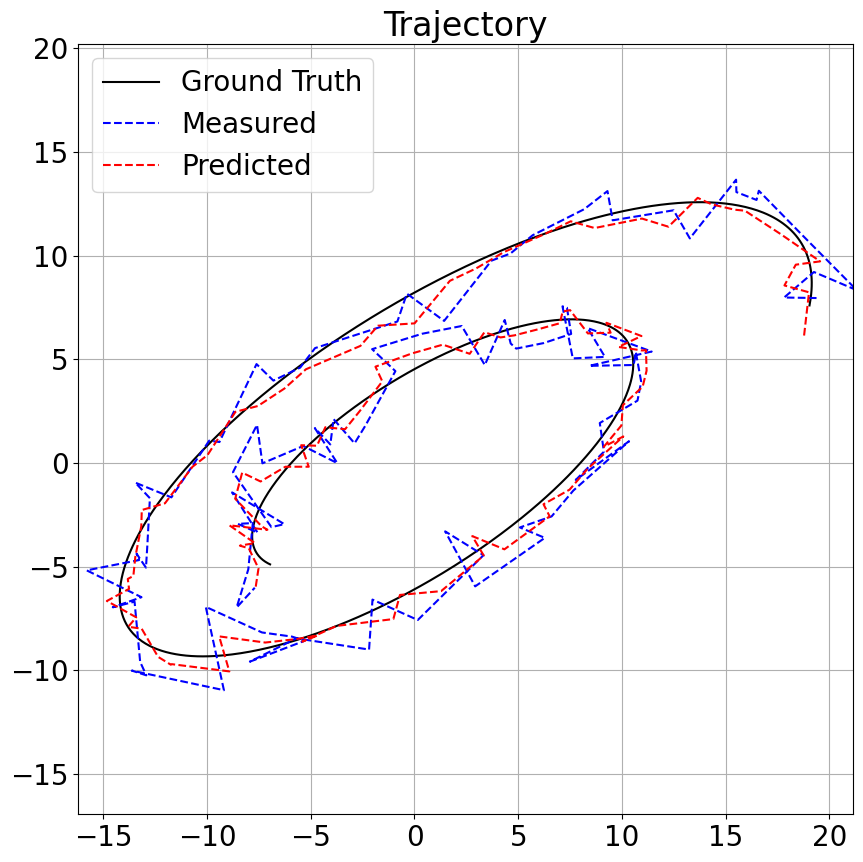

torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 2, 101, 101, 128])
torch.Size([1, 1, 101, 101])


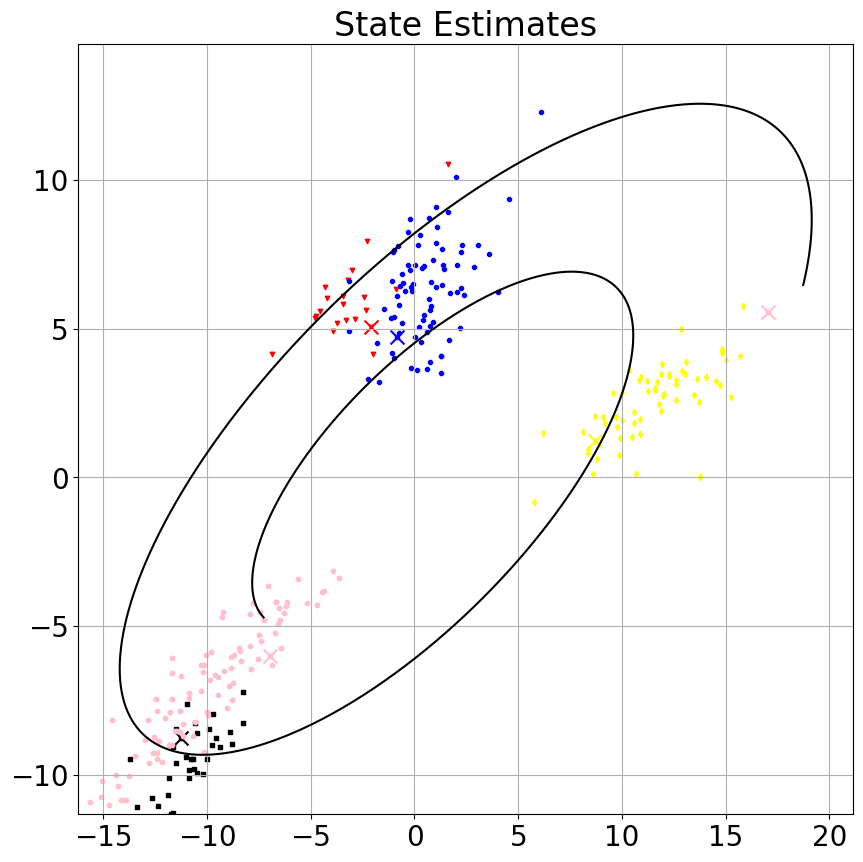

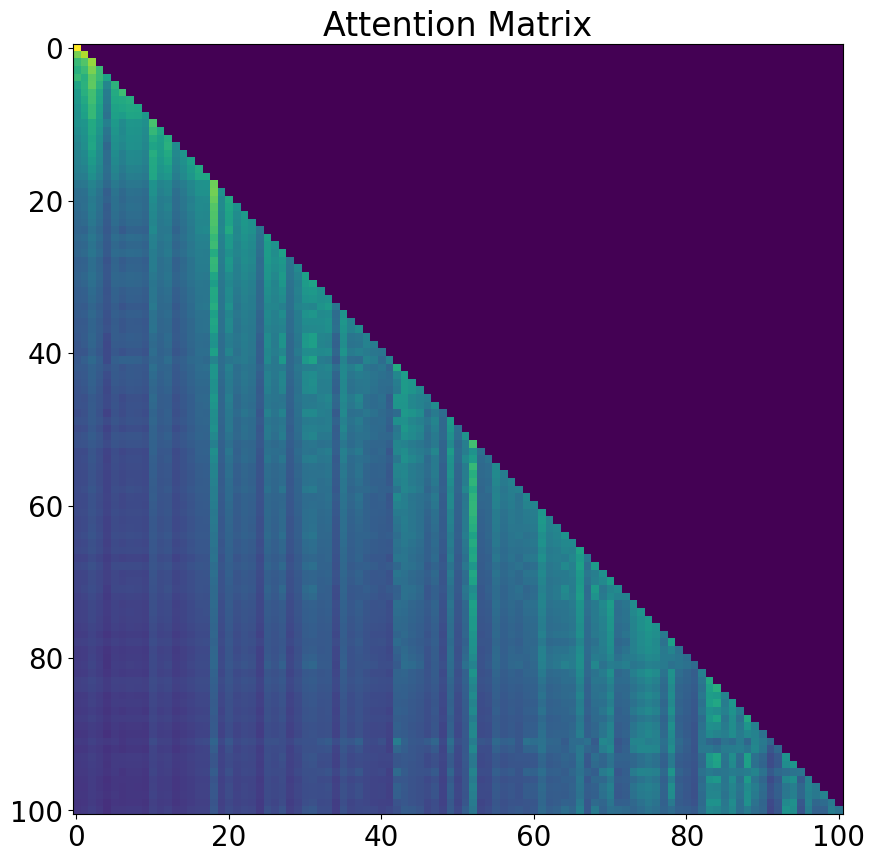

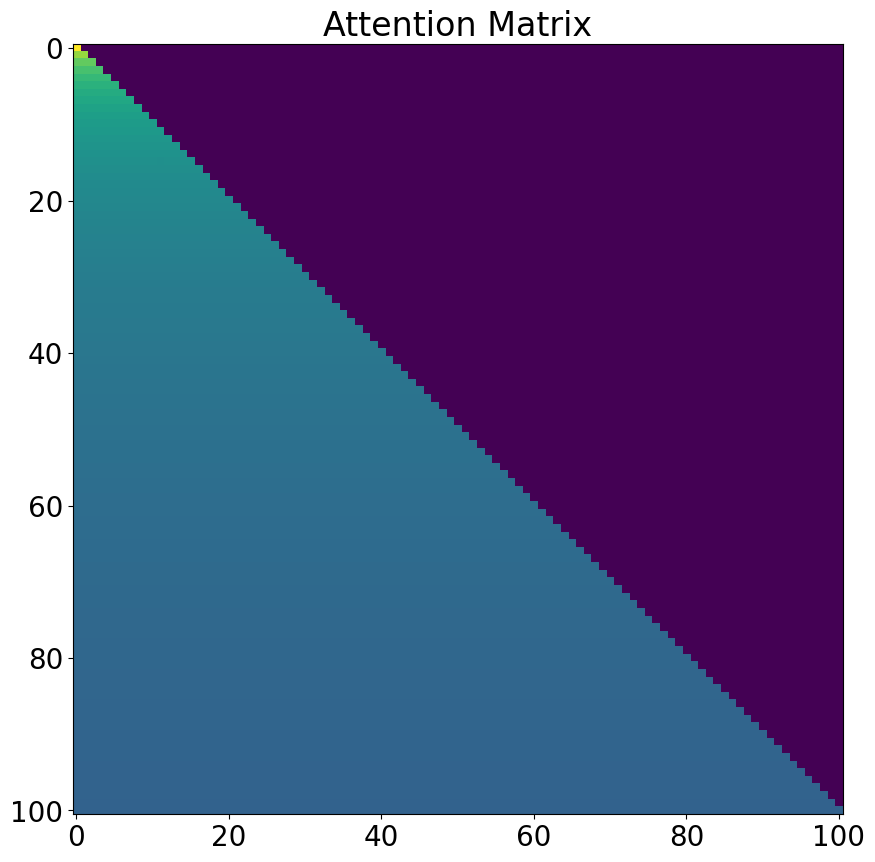

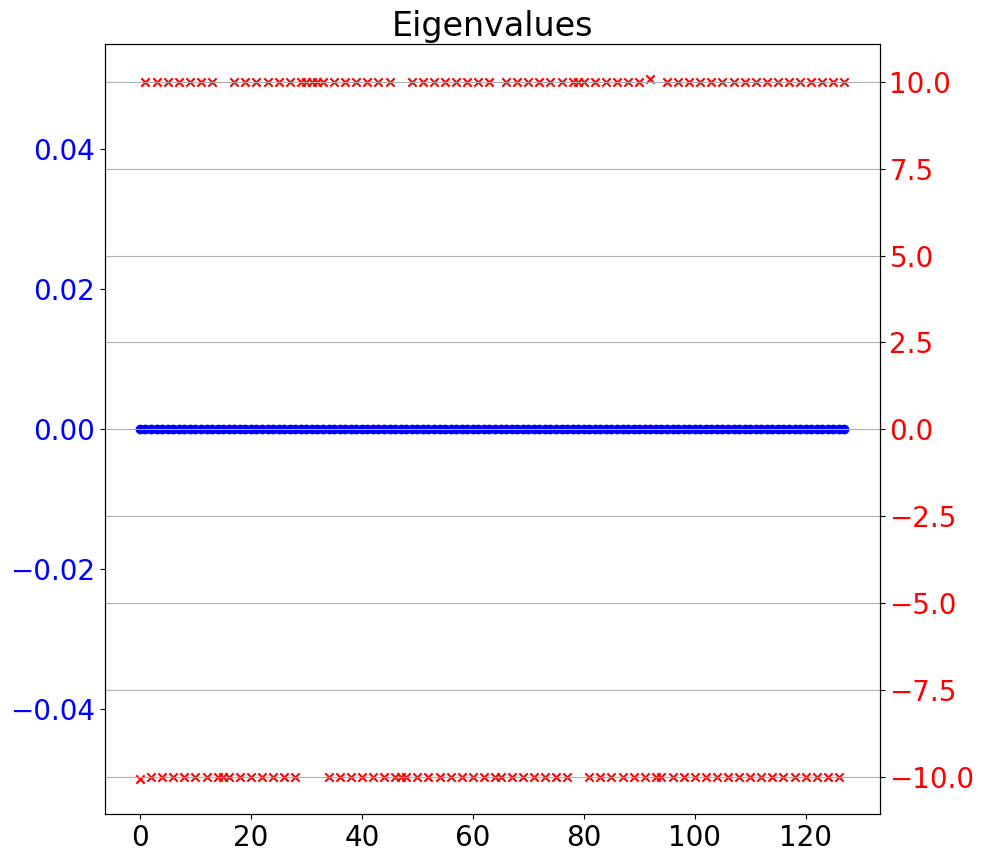

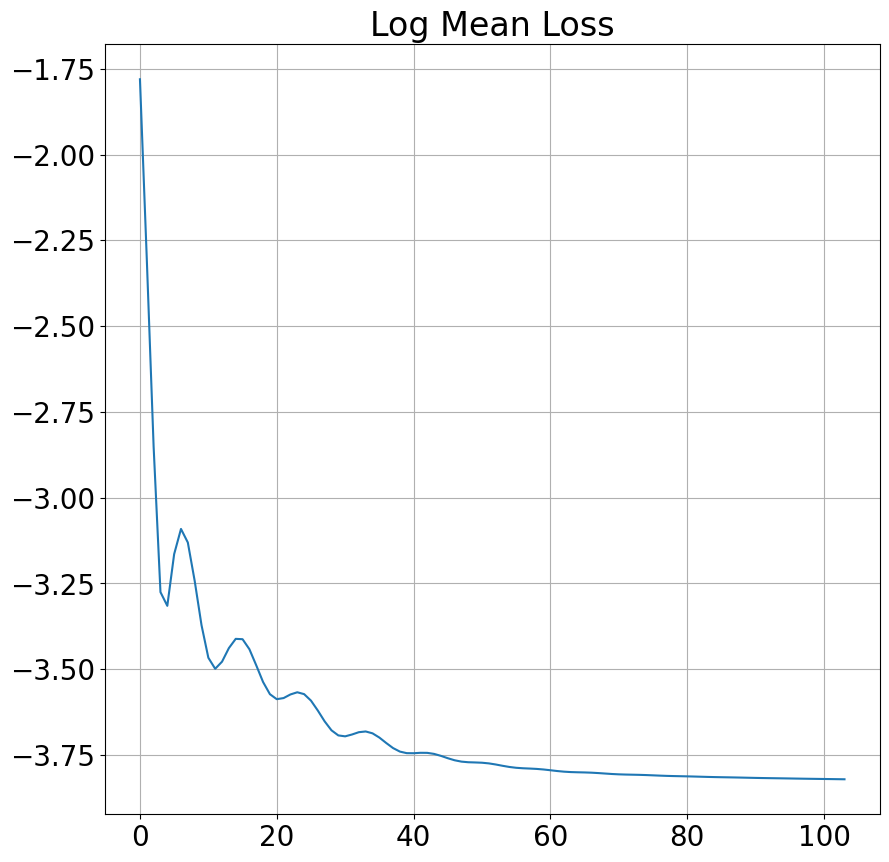

Training progress...:  11%|██████                                                   | 107/1000 [01:55<16:02,  1.08s/it]


KeyboardInterrupt: 

In [17]:
########################### TRAINING LOOP ###########################
#####################################################################

###### LOOP FOR PRECISION ATTENTION LAYERS #######

# Initialize to correct values (for testing)
initialize_net_to_correct_model(model, D1, S1, Si1, sigma_process, sigma_measure, args)
for layer in model.layers:
    initialize_net_to_correct_model(layer, D1, S1, Si1, sigma_process, sigma_measure, args)

#########

# Train for num_epochs:
for epoch in tqdm(np.arange(args.num_epochs), desc="Training progress..."):

#     # Get training data online:
#     train_loader, train_dataset, X_true_all, X_measure_all, t_measure = create_train_loader(A, S1, Si1, Pu, Pd, R1, R1i, t_v, sigma_process, sigma_measure,args)

    # Train for single epoch
    epoch_losses, Q_ij, epoch_lambdas = single_epoch(model, train_loader, optimizer, loss, loss_p, params_list, args)

    # Collect losses
    all_losses[epoch*args.num_its:(epoch+1)*args.num_its] = epoch_losses
    mean_epoch_losses[epoch] = np.mean(epoch_losses)
    log_mean_epoch_losses[epoch] = np.log(np.mean(epoch_losses))
    all_lambdas[epoch,:,:] = np.mean(epoch_lambdas,axis=0)
    
    # Visualize results so far:
    if np.mod(epoch+1,args.show_example_epochs) == 0:
        visualize_results(model, train_dataset, all_losses, mean_epoch_losses, log_mean_epoch_losses, all_lambdas, R1, R1i, Pu, Pd, A, epoch, args)

# ##################################################
# ##### LOOP FOR REAL/COMPLEX ATTENTION NETS #######

# for epoch in tqdm(np.arange(args.num_epochs), desc="Training progress..."):

#     epoch_losses = single_epoch_attn(model, train_loader, optimizer, loss, params_list, args)
    
#     # Collect losses
#     all_losses[epoch*args.num_its:(epoch+1)*args.num_its] = epoch_losses
#     log_mean_epoch_losses[epoch] = np.log(np.mean(epoch_losses))
    
#     # Visualize results so far:
#     if np.mod(epoch+1,args.show_example_epochs) == 0:
#         visualize_results_attn(model, train_dataset, all_losses, mean_epoch_losses, log_mean_epoch_losses, all_lambdas, R1, R1i, Pu, Pd, A, epoch, args)
# ##################################################

In [ ]:
## JUMP

In [ ]:
# visualize_results(model, train_dataset, all_losses, mean_epoch_losses, log_mean_epoch_losses, all_lambdas, R1, R1i, Pu, Pd, A, epoch, args)

In [19]:
# Iterate through training data
for it, (train_data, X_true, X_measure, t_measure_full) in enumerate(train_loader):
    break
    
# Outputs are one index ahead of inputs
inputs  = train_data[:, :, :-1]
outputs = train_data[:, :, 1:]
# t_measure = t_measure_full[0,:]
    
rand_idx = np.random.choice(args.num_samp)
# _, _, _, t_measure = train_dataset.__getitem__(rand_idx)
train_data, X_true, X_measure, t_measure = train_dataset.__getitem__(rand_idx)
inputs = train_data[:, :-1].unsqueeze(0)

if args.model_type == 'RealInputs':
    inputs = inputs[:,0].unsqueeze(1) # Get real part
elif args.model_type == 'ComplexInputs':
    pass
else:
    print('Error. Set model_type.')
    
# out = model.norm1(inputs)
    
est, out, Q_ij, Z_ij_hat_all, epoch_lambdas = model.forward(inputs, t_measure.unsqueeze(0))

if args.model_type == 'RealInputs':
    out = torch.concatenate((out, torch.zeros_like(out)),dim=1)
elif args.model_type == 'ComplexInputs':
    pass
else:
    print('Error!. Set model_type.')

out.size()
out = out.unsqueeze(-1)
# out, _ = model(inputs, t_measure_full)
# est, out, attn_weight, Z_ij_hat, lambda_h = model(inputs, t_measure_full)

# loss(out.unsqueeze(-1), outputs.unsqueeze(-1))

In [20]:
"""
"""
self = a0
Z_q = Z_k = Z_v = inputs

############ (Masking; used for testing) ###########
apply_net_weight_masks(self)
####################################################

if Z_q.size()[1] == 1:
    Z_q = torch.cat((Z_q, torch.zeros_like(Z_q)),dim=1)
    Z_k = torch.cat((Z_k, torch.zeros_like(Z_k)),dim=1)
    Z_v = torch.cat((Z_v, torch.zeros_like(Z_v)),dim=1)

if len(t_measure_all.size()) > 1:
    t_measure = t_measure_all[0,:-1]
else:
    t_measure = t_measure_all[:,:-1]

#######################################

if self.args.lambda_real_zero == 1:
    lambda_h_v = compute_lambda_shared(0*self.lambda_real_v, self.lambda_imag_v, self.args)
else:
    lambda_h_v = compute_lambda_shared(self.lambda_real_v, self.lambda_imag_v, self.args)

# Take absolute value of noise parameters to ensure positive definiteness / non-negativeness
#         lambda_omega = torch.abs(self.lambda_omega_sqrt) # Process noise matrix
#         lambda_gamma = torch.abs(self.lambda_gamma_sqrt) + self.args.epsilon # Measurement noise matrix
lambda_omega_v = self.lambda_omega_sqrt_v**2 # Process noise matrix
lambda_gamma_v = self.lambda_gamma_sqrt_v**2 + self.args.epsilon # Measurement noise matrix

# Project input into Q, K, V        
Q = self.W_q(Z_q).unsqueeze(-1)
K = self.W_k(Z_k).unsqueeze(-1)
V = self.W_v(Z_v).unsqueeze(-1)

# Normalize time vector by total time elapsed (optional)
t_measure /= (t_measure[-1] - t_measure[0]).unsqueeze(0)

_, _, exp_f_v, exp_b_v = compute_exp_kernel(lambda_h_v, t_measure)

mat_exp = exp_f_v[:,0,:,:] # Get matrix exponential for next-state prediction
#         mat_exp = K_exp[:, -(self.args.seq_len+1), :, :] # Get matrix exponential for next-state prediction

K_cov_v = compute_covariance_kernel_scalar(lambda_h_v, lambda_omega_v, lambda_gamma_v, exp_f_v, t_measure, self.args, epsilon=1e-5)

K_cov_v.size()
# if self.args.sep_params == 1:
#     if self.args.lambda_real_zero == 1:
#         lambda_h_k = compute_lambda_shared(0*self.lambda_real_k, self.lambda_imag_k, self.args)
#     else:
#         lambda_h_k = compute_lambda_shared(self.lambda_real_k, self.lambda_imag_k, self.args)

#     lambda_omega_k = self.lambda_omega_sqrt_k**2 # Process noise matrix
#     lambda_gamma_k = self.lambda_gamma_sqrt_k**2 + self.args.epsilon # Measurement noise matrix

#     _, _, exp_f_k, exp_b_k = compute_exp_kernel(lambda_h_k, t_measure)

#     K_cov_k = compute_covariance_kernel_scalar(lambda_h_k, lambda_omega_k, lambda_gamma_k, exp_f_k, t_measure, self.args, epsilon=1e-5)
# else:
#     exp_f_k = exp_f_v
#     exp_b_k = exp_b_v
#     K_cov_k = None

# V_k, V_v, U_q, U_k, U_v = build_factorized_kernels(exp_f_k, exp_b_k, exp_f_v, exp_b_v, Q, K, V)

# est_v, Q_ij = compute_estimate_simplified(self, K_cov_k, K_cov_v, V_k, V_v, U_q, U_k, U_v, Q, K, V, self.args)

# # Add residual connection
# eta = torch.sigmoid(self.eta_param)
# est_latent = (1 - eta) * V + torch.sigmoid(eta) * est_v
# #         est_latent = est_v

# # Get prediction in diagonalized space
# pred_p = batched_complex_hadamard(mat_exp, est_latent)

# # Multiply by output matrix to get output prediction
# pred = self.W_p(pred_p.squeeze(-1))

# # Output is a linear combination of estimate and prediction
# out = pred

# est_latent = est_latent.squeeze(-1)
# out = out.squeeze(-1)
# # Z_ij_hat_all = Z_ij_hat_all.squeeze(-1)
# Z_ij_hat_all = batched_complex_hadamard_full(V_v.unsqueeze(3), U_v.unsqueeze(2))

NameError: name 'a0' is not defined

In [21]:
class MultiheadSimplifiedPrecisionAttentionBlock(nn.Module):
    def __init__(self, input_dim, query_key_dim, value_dim, n_heads, args):
        """

        """

        super().__init__()

        # Store dimensions as instance attributes
        self.n_heads = n_heads
        self.d_e = input_dim
        self.d_k_head = query_key_dim
        self.d_v_head = value_dim

        self.d_k_total = self.n_heads * self.d_k_head
        self.d_v_total = self.n_heads * self.d_v_head

        self.seq_len = args.seq_len

        ################################################

        self.W_q = ComplexLinearLayer(self.d_e, self.d_k_total)
        self.W_k = ComplexLinearLayer(self.d_e, self.d_k_total)
        self.W_v = ComplexLinearLayer(self.d_e, self.d_v_total)
        self.W_p = ComplexLinearLayer(self.d_v_total, self.d_e)

        # if args.lambda_real_zero == 1:
        #     self.W_p = ComplexLinearHermitianLayer(self.W_v)
        # else:
        #     self.W_p = ComplexLinearLayer(self.d_v, self.d_e)

        ################################################

        self.lambda_imag_v = nn.Parameter(torch.randn(self.n_heads, int(self.d_v_head/2)))

        if args.lambda_real_zero == 1:
            self.register_buffer("lambda_real_v", torch.zeros(self.n_heads))
        else:
            self.lambda_real_v = nn.Parameter(torch.randn(self.n_heads))

        self.lambda_omega_sqrt_v = nn.Parameter(torch.randn(self.n_heads))
        self.lambda_gamma_sqrt_v = nn.Parameter(torch.randn(self.n_heads))

        ################################################

        # Define separate dynamic key-query parameters

        if args.sep_params == 1:

            self.lambda_imag_k = nn.Parameter(torch.randn(self.n_heads, int(self.d_v_head/2)))

            if args.lambda_real_zero == 1:
                self.register_buffer("lambda_real_k", torch.zeros(self.n_heads))
            else:
                self.lambda_real_k = nn.Parameter(torch.randn(self.n_heads))

            self.lambda_omega_sqrt_k = nn.Parameter(torch.randn(self.n_heads))
            self.lambda_gamma_sqrt_k = nn.Parameter(torch.randn(self.n_heads))

        ################################################

        self.noise_floor = nn.Parameter(torch.ones(self.n_heads))

        self.tau = nn.Parameter(torch.ones(self.n_heads))
        self.nu = nn.Parameter(torch.ones(self.n_heads))

        ################################################

        Wqi, bqi = init_complex_matrix(self.d_e, self.d_k_total, bias=True)
        Wki, bki = init_complex_matrix(self.d_e, self.d_k_total, bias=True)
        Wvi, bvi = init_complex_matrix(self.d_e, self.d_v_total, bias=True)
        Wpi, bpi = init_complex_matrix(self.d_v_total, self.d_e, bias=True)
        init_complexlinear(self.W_q, Wqi, bqi)
        init_complexlinear(self.W_k, Wki, bki)
        init_complexlinear(self.W_v, Wvi, bvi)
        init_complexlinear(self.W_p, Wpi, bpi)
        #         if args.lambda_real_zero == 0:
        #             init_complexlinear(self.W_p, Wpi, bpi)

        ################################################

        self.args = args

        self.register_buffer("causal_mask", torch.tril(torch.ones(self.seq_len, self.seq_len)).view(1, self.seq_len, self.seq_len, 1, 1))

        self.register_buffer("complex_identity", torch.stack((torch.eye(self.d_v_head, self.d_v_head), \
                                                              torch.zeros(self.d_v_head, self.d_v_head))).unsqueeze(1))

        # Relative weighting of attention (alpha) and residual (beta) connections (useful for diagnosis)
        self.alpha = nn.Parameter(torch.zeros(1, self.n_heads))
        self.beta = nn.Parameter(torch.zeros(1, self.n_heads))

        # Relative weighting of estimate (delta) and prediction (eta) in output
        self.eta_param = nn.Parameter(torch.zeros(1, 1, 1, self.d_v_head, self.n_heads)) # "Gradient descent" step size

        ############################################

        # Create masks for parameter matrices (used for testing)
        init_weight_masks(self, args)

        # self.epsilon = 1e-5

        ############################################

    def forward(self, Z_q, Z_k, Z_v, t_measure_all):
        """

        """
        
        ############ (Masking; used for testing) ###########
        apply_net_weight_masks(self)
        ####################################################

        if Z_q.size()[1] == 1:
            Z_q = torch.cat((Z_q, torch.zeros_like(Z_q)),dim=1)
            Z_k = torch.cat((Z_k, torch.zeros_like(Z_k)),dim=1)
            Z_v = torch.cat((Z_v, torch.zeros_like(Z_v)),dim=1)

        #######################################

        if len(t_measure_all.size()) > 1:
            t_measure = t_measure_all[0,:-1]
        else:
            t_measure = t_measure_all[:,:-1]

        # Normalize time vector by total time elapsed (optional)
        t_measure /= (t_measure[-1] - t_measure[0]).unsqueeze(0)

        #######################################

        batch_size = Z_q.size()[0]

        # Project input into Q, K, V        
        Q_proj = self.W_q(Z_q)
        K_proj = self.W_k(Z_k)
        V_proj = self.W_v(Z_v)

        Q = Q_proj.view(batch_size, 2, self.seq_len, self.d_k_head, self.n_heads)
        K = K_proj.view(batch_size, 2, self.seq_len, self.d_k_head, self.n_heads)
        V = V_proj.view(batch_size, 2, self.seq_len, self.d_v_head, self.n_heads)

        #######################################

        if self.args.lambda_real_zero == 1:
            lambda_h_v = compute_lambda_shared_multihead(0*self.lambda_real_v, self.lambda_imag_v, self.args)
        else:
            lambda_h_v = compute_lambda_shared_multihead(self.lambda_real_v, self.lambda_imag_v, self.args)

        # Take absolute value of noise parameters to ensure positive definiteness / non-negativeness
        #         lambda_omega = torch.abs(self.lambda_omega_sqrt) # Process noise matrix
        #         lambda_gamma = torch.abs(self.lambda_gamma_sqrt) + self.args.epsilon # Measurement noise matrix
        lambda_omega_v = self.lambda_omega_sqrt_v**2 # Process noise matrix
        lambda_gamma_v = self.lambda_gamma_sqrt_v**2 + self.args.epsilon # Measurement noise matrix

        exp_f_v, exp_b_v = compute_exp_kernel_multihead(lambda_h_v, t_measure)

        mat_exp = exp_f_v[:,0,:,:] # Get matrix exponential for next-state prediction

        K_cov_v = compute_covariance_kernel_scalar_multihead(lambda_h_v, lambda_omega_v, lambda_gamma_v, exp_f_v, t_measure, self.args, epsilon=1e-5)

        if self.args.sep_params == 1:
            if self.args.lambda_real_zero == 1:
                lambda_h_k = compute_lambda_shared_multihead(0*self.lambda_real_k, self.lambda_imag_k, self.args)
            else:
                lambda_h_k = compute_lambda_shared_multihead(self.lambda_real_k, self.lambda_imag_k, self.args)

            lambda_omega_k = self.lambda_omega_sqrt_k**2 # Process noise matrix
            lambda_gamma_k = self.lambda_gamma_sqrt_k**2 + self.args.epsilon # Measurement noise matrix

            exp_f_k, exp_b_k = compute_exp_kernel_multihead(lambda_h_k, t_measure)

            K_cov_k = compute_covariance_kernel_scalar_multihead(lambda_h_k, lambda_omega_k, lambda_gamma_k, exp_f_k, t_measure, self.args, epsilon=1e-5)
        else:
            exp_f_k = exp_f_v
            exp_b_k = exp_b_v
            K_cov_k = None

        V_k, V_v, U_q, U_k, U_v = build_factorized_kernels(exp_f_k, exp_b_k, exp_f_v, exp_b_v, Q, K, V)

        R_qk_abs_squared = compute_weighted_residual_norm_multihead(V_k, U_k, U_q)
        
        est_v, Q_ij = compute_estimate_simplified_multihead(self, K_cov_k, K_cov_v, V_k, V_v, U_q, U_k, U_v, Q, K, V, self.args)

        # Add residual connection
        eta = torch.sigmoid(self.eta_param)
        est_latent = (1 - eta) * V + torch.sigmoid(eta) * est_v

        # Get prediction in diagonalized space
        pred_p = batched_complex_hadamard(mat_exp, est_latent)

        pred_p_reshape = pred_p.view(batch_size, 2, self.seq_len, self.d_k_total)

        # Multiply by output matrix to get output prediction
        pred = self.W_p(pred_p_reshape)

        # Output is a linear combination of estimate and prediction
        out = pred

        est_latent = est_latent.squeeze(-1)
        out = out.squeeze(-1)
        # Z_ij_hat_all = Z_ij_hat_all.squeeze(-1)
        Z_ij_hat_all = batched_complex_hadamard_full(V_v.unsqueeze(3), U_v.unsqueeze(2))
    
#         return est_latent, out, Q_ij, V_v, U_v, lambda_h
        return est_latent, out, Q_ij, Z_ij_hat_all, lambda_h_v

In [22]:
input_dim = args.d_e
query_key_dim = args.d_k
value_dim = args.d_v

n_heads = 2
args.n_heads = n_heads
a1 = MultiheadSimplifiedPrecisionAttentionBlock(input_dim, query_key_dim, value_dim, n_heads, args).to(args.device)

a0 = SimplifiedPrecisionAttentionBlock(input_dim, query_key_dim, value_dim, args).to(args.device)

self = a1

# inputs.size()
inputs_expand = inputs
# inputs_expand = inputs.expand(32, -1, -1, -1) 
a1(inputs_expand, inputs_expand, inputs_expand, t_measure_all)

lambda_real_v = self.lambda_real_v
lambda_imag_v = self.lambda_imag_v
min_dt_decay = 1e-3
scale_r = 1
scale_i = 1

layers = nn.ModuleList([MultiheadSimplifiedPrecisionAttentionBlock(args.d_e, args.d_k, args.d_v, args.n_heads, args)]).to(args.device)

layer = layers[0]
est, out, Q_ij, Z_ij_hat_all, lambda_h = layer(inputs, inputs, inputs, t_measure_all)

RuntimeError: expand(CUDABoolType{[1, 101, 101, 1, 1]}, size=[1, 101, 101, 2]): the number of sizes provided (4) must be greater or equal to the number of dimensions in the tensor (5)

In [28]:
def compute_lambda_shared_multihead(lambda_real_input, lambda_imag_input, args, scale_r=1, scale_i=1, min_dt_decay=1e-3):
    """
    Compute complex conjugate eigenvalue pairs for each attention head.

    Args:
        lambda_real_in: Tensor of shape [n_heads, 1]
        lambda_imag_in: Tensor of shape [n_heads, d_v_head // 2]
        args: must contain dt
    Returns:
        lambda_h: [2, d_v_head, n_heads, 1] (real/imag, eigenvalue, head, 1)
    """

    device = lambda_real_input.device

    n_heads, d_half = lambda_imag_input.shape
    d_v_head = 2 * d_half

    # Compute bounded decay rate for real part
    min_lambda_real_bound = torch.tensor(np.log(min_dt_decay) / args.dt, device=device)
    lambda_real = -torch.abs(lambda_real_input) * scale_r
    lambda_real = min_lambda_real_bound + F.softplus(lambda_real - min_lambda_real_bound)  # [n_heads]

    # Expand real parts to match imag
    lambda_real_expanded = lambda_real.expand(d_half, -1)  # [n_heads, d_half]

    lambda_real_expanded.size()
    # Create interleaved real/imag conjugate pairs
    real_parts = lambda_real_expanded.repeat_interleave(2, dim=0)                # [d_v_head, n_heads]
    imag_parts = torch.stack([lambda_imag_input, -lambda_imag_input], dim=2) * scale_i   # [d_half, 2, n_heads]
    imag_parts = imag_parts.reshape(n_heads, d_v_head).T                          # interleave imag/-imag

    # Stack real and imag into shape [2, d_v_head, n_heads, 1]
    lambda_h = torch.stack([real_parts, imag_parts], dim=0).unsqueeze(1).unsqueeze(-1)  # [2, 1, d_v_head, n_heads, 1]

    return lambda_h

lambda_h_v = compute_lambda_shared_multihead(self.lambda_real_v, self.lambda_imag_v, args)
lambda_h_v.size()

torch.Size([2, 1, 128, 2, 1])

In [29]:
def compute_exp_kernel_multihead(lambda_h, t_v):
    """
    Computes the exponential kernel for a given decay matrix and array of time steps.

    Args:
        lambda_h (torch.Tensor): Complex decay matrix, shape [2, d_v_head, n_heads, 1]
        t_v (torch.Tensor): Time vector, shape [seq_len]

    Returns:
        K_exp (torch.Tensor): Full exponential kernel, shape [2, 2*seq_len - 1, d_v_head, n_heads]
        K_exp2 (torch.Tensor): Squared magnitude kernel, shape [1, 2*seq_len - 1, d_v_head, n_heads]
        exp_f (torch.Tensor): Forward kernel, shape [2, seq_len, d_v_head, n_heads]
        exp_b (torch.Tensor): Backward kernel, shape [2, seq_len, d_v_head, n_heads]
    """
    seq_len = t_v.shape[0]

    # Expand t_v to shape [1, seq_len, 1, 1, 1]
    t_exp = t_v.unsqueeze(0).unsqueeze(2).unsqueeze(3).unsqueeze(4)  # [1, seq_len, 1, 1, 1]

    # Compute exponentials
    exp_f = complex_exp(lambda_h * t_exp).squeeze(-1)   # [2, seq_len, d_v_head, n_heads]
    exp_b = complex_exp(-lambda_h * t_exp).squeeze(-1)  # [2, seq_len, d_v_head, n_heads]

    return exp_f, exp_b

exp_f_v, exp_b_v = compute_exp_kernel_multihead(lambda_h_v, t_measure)
exp_f_v.size()

torch.Size([2, 102, 128, 2])

In [30]:
def compute_covariance_kernel_scalar_multihead(lambda_h, lambda_omega, lambda_gamma, exp_f, t_v, args, epsilon=1e-5):
    """
    Multihead covariance kernel computation with correct dimension ordering.

    Inputs:
        lambda_h:     [2, 1, seq_len, num_heads, 1] (real/imag, 1, seq_len, num_heads, 1)
        lambda_omega: [num_heads, 1]
        lambda_gamma: [num_heads, 1]
        exp_f:        [2, seq_len, num_heads] (real/imag, seq_len, num_heads)
        t_v:            [seq_len]

    Returns:
        K_cov_full: [seq_len + 1, num_heads] covariance kernel
    """

    # Extract real part of lambda: shape [1, seq_len, num_heads, 1] -> squeeze dims
    # lambda_h_v shape: [2, 1, seq_len, num_heads, 1]
    lambda_real = lambda_h[0,0,0,:,0].unsqueeze(0) # shape: [1, num_heads]

    # Magnitude squared of exp_f_v: shape [2, seq_len, num_heads]
    K_mag_sq = exp_f[0,:,0,:]**2 + exp_f[1,:,0,:]**2

    # Flip time for kernel ordering
    t_flip = t_v.flip(dims=[0])  # [seq_len]

    # Create mask for Taylor approximation (lambda_real near zero)
    mask = torch.abs(lambda_real) < epsilon  # [seq_len, num_heads]

    # Prepare denominator and numerator for direct term with broadcasting
    denom = -2 * lambda_real + epsilon  # [seq_len, num_heads]
    numer = 1 - K_mag_sq + epsilon       # [seq_len, num_heads]
    direct_term = numer / denom          # [seq_len, num_heads]

    # Taylor approximation: shape broadcast to [seq_len, num_heads]
    taylor_approx = 1 - 2 * lambda_real * (t_flip.unsqueeze(-1) - 1) / epsilon

    # Choose stable fraction
    stable_frac = torch.where(mask, taylor_approx, direct_term)  # [seq_len, num_heads]

    # Broadcast stable_frac and K_mag_sq to multiply with omega and gamma
    term1 = lambda_omega * stable_frac  # [seq_len, num_heads]
    term2 = lambda_gamma * K_mag_sq     # [seq_len, num_heads]

    K_cov = term1 + term2  # [seq_len, num_heads]

    # Append ones row at end along seq_len dimension
    ones = torch.ones_like(K_cov[:-1,:])
    K_cov_full = torch.concatenate((K_cov, ones), dim=0)  # Covariance kernel

    return K_cov_full

epsilon = 1e-5
lambda_omega_v = self.lambda_omega_sqrt_v**2
lambda_gamma_v = self.lambda_gamma_sqrt_v**2 + epsilon

K_cov_v = compute_covariance_kernel_scalar_multihead(lambda_h_v, lambda_omega_v, lambda_gamma_v, exp_f_v, t_measure, args)

K_cov_v.size()

torch.Size([203, 2])

In [32]:
def compute_covariance_kernel_tanh_scalar_multihead(lambda_h, lambda_omega, lambda_gamma, exp_f, t_v, args, lambda_C=1.0, epsilon=1e-5):
    """
    Multihead covariance kernel computation using tanh solution with correct dimension ordering.

    Inputs:
        lambda_h:     [2, 1, seq_len, num_heads, 1] (real/imag, 1, seq_len, num_heads, 1)
        lambda_omega: [num_heads, 1]
        lambda_gamma: [num_heads, 1]
        exp_f:        [2, seq_len, num_heads] (real/imag, seq_len, num_heads)
        t_v:          [seq_len]

    Returns:
        K_cov_full: [seq_len + 1, num_heads] covariance kernel
    """
    m = args.seq_len
    num_heads = args.n_heads

    # Squeeze dimensions to [num_heads]
    lambda_real = lambda_h[0,0,0,:,0] # shape: [num_heads]

    # Use only the first m values from the kernel (positive time diffs)
    K_mag_sq = exp_f[0,:,0,:]**2 + exp_f[1,:,0,:]**2 # shape: [m, num_heads]

    # Compute stability-sensitive ratio
    ratio = (lambda_omega.squeeze() / (lambda_gamma.squeeze() + epsilon)) * lambda_C**2 # shape: [num_heads]

    use_lyapunov = (torch.abs(ratio) < epsilon) # shape: [num_heads]

    # --- Riccati (tanh) branch ---
    # broadcast to [m, num_heads]
    c2 = torch.sqrt(lambda_real**2 + ratio + epsilon) # shape: [num_heads]
    c3 = -lambda_real # shape: [num_heads]
    c1_arg = c3 / (c2 + epsilon) # shape: [num_heads]
    c1 = (2 / (c2 + epsilon)) * torch.atanh(c1_arg) # shape: [num_heads]

    # tanh-based solution: V = factor * (c2 tanh + λ)
    t_diff = t_v.unsqueeze(-1) - c1 # shape: [m, num_heads]
    x = 0.5 * c2 * t_diff # shape: [m, num_heads]
    tanh_term = c2 * torch.tanh(x) # shape: [m, num_heads]
    factor = lambda_gamma.squeeze() / (lambda_C**2 + epsilon) # shape: [num_heads]
    V_riccati = factor * (tanh_term + lambda_real) # shape: [m, num_heads]

    # --- Lyapunov branch (fallback when ratio ≈ 0) ---
    denom = -2 * lambda_real + epsilon # shape: [num_heads]
    V_lyapunov = (lambda_omega.squeeze() / denom) * (1 - K_mag_sq) # shape: [m, num_heads]

    # Select per-head solution
    use_lyapunov_expanded = use_lyapunov.unsqueeze(0).expand_as(V_lyapunov) # shape: [m, num_heads]
    V_ij = torch.where(use_lyapunov_expanded, V_lyapunov, V_riccati) # shape: [m, num_heads]

    # Final kernel: V_ij + Gamma * |exp|^2
    lambda_gamma_expanded = lambda_gamma.squeeze().unsqueeze(0).expand_as(K_mag_sq)
    K_cov_core = lambda_C**2 * V_ij + lambda_gamma_expanded * K_mag_sq # shape: [m, num_heads]

    # Extend to [2m-1, d] by padding with ones
    ones = torch.ones_like(K_cov_core[:-1, :]) # shape: [m-1, num_heads]
    K_cov_full = torch.cat((K_cov_core, ones), dim=0) # shape: [2m-1, num_heads]

    return K_cov_full

epsilon = 1e-5
lambda_omega_v = self.lambda_omega_sqrt_v**2
lambda_gamma_v = self.lambda_gamma_sqrt_v**2 + epsilon

K_cov_v = compute_covariance_kernel_tanh_scalar_multihead(lambda_h_v, lambda_omega_v, lambda_gamma_v, exp_f_v, t_measure, args)

K_cov_v.size()

torch.Size([203, 2])

In [ ]:
def build_covariance_from_kernel_scalar_multihead(K_cov, args, epsilon=1e-5):
    """
    Build full covariance tensor V_ij for each head from multihead kernel.

    Inputs:
      K_cov : [2m - 1, num_heads]  — covariance kernel for each head.
      args  : object with 'seq_len' and 'device' attributes.

    Returns:
      V_ij : [m, m, num_heads]     — full covariance matrix for each head.
    """

    m = args.seq_len
    device = args.device

    # Indices to extract Toeplitz structure
    i_vals = torch.arange(m, device=device)                     # [m]
    start_indices = m - 1 - i_vals                              # [m]
    indices = start_indices[:, None] + i_vals[None, :]          # [m, m]

    # Index into K_cov: K_cov[indices] -> shape [m, m, num_heads]
    V_ij = K_cov[indices] + epsilon                             # [m, m, num_heads]

    return V_ij

V_ij = build_covariance_from_kernel_scalar_multihead(K_cov_v, args)
V_ij.size()

In [ ]:
def compute_weighted_residual_norm_multihead(V_k, U_k, U_q):
    """
    Multihead version of the weighted residual norm |R_qk|^2.

    Inputs:
        V_k: Tensor of shape (B, 2, m, d, n_heads), complex-valued values
        U_k: Tensor of shape (B, 2, m, d, n_heads), complex-valued key embeddings
        U_q: Tensor of shape (B, 2, m, d, n_heads), complex-valued query embeddings

    Returns:
        R_qk_abs_squared: Tensor of shape (B, m, m, n_heads), per-head squared residuals
    """

    # Compute |V_k|^2 = Re^2 + Im^2, summed over feature dim
    V_k_abs = torch.sum(V_k**2, dim=1)  # (B, m, d, n_heads)

    # Compute |U_k|^2 and |U_q|^2 the same way
    U_k_abs = torch.sum(U_k**2, dim=1)  # (B, m, d, n_heads)
    U_q_abs = torch.sum(U_q**2, dim=1)  # (B, m, d, n_heads)

    # Term 1: (|V_k|^2)^T @ |U_k|^2 for each head
    T1 = torch.einsum('bmdh,bndh->bmnh', V_k_abs, U_k_abs)  # (B, m, m, n_heads)

    # Term 2: sum_k (|V_k|^2 ⊙ |U_q|^2), sum over feature dim
    T2 = torch.sum(V_k_abs * U_q_abs, dim=2).unsqueeze(2)  # (B, m, 1, n_heads), broadcast over keys

    # Term 3: Re[ (|V_k|^2 ⊙ U_q)^H U_k ] = Re-part inner product
    # Split into real and imag
    VU_q = V_k_abs.unsqueeze(1) * U_q  # (B, 2, m, d, n_heads)

    VU_q_real = VU_q[:, 0]  # (B, m, d, n_heads)
    VU_q_imag = VU_q[:, 1]  # (B, m, d, n_heads)
    U_k_real = U_k[:, 0]    # (B, m, d, n_heads)
    U_k_imag = U_k[:, 1]    # (B, m, d, n_heads)

    # Inner product: sum_d (Re ⊙ Re + Im ⊙ Im)
    T3_RR = torch.einsum('bmdh,bndh->bmnh', VU_q_real, U_k_real)  # (B, m, m, n_heads)
    T3_II = torch.einsum('bmdh,bndh->bmnh', VU_q_imag, U_k_imag)
    T3 = T3_RR + T3_II

    # Final residual
    R_qk_abs_squared = T1 + T2 - 2 * T3  # (B, m, m, n_heads)

    return R_qk_abs_squared

In [ ]:
R_qk_abs_squared = compute_weighted_residual_norm_multihead(V_k, U_k, U_q)
R_qk_abs_squared.size()

In [ ]:
def batched_complex_matmul_multihead(A, B):
    """
    General batched complex matrix multiplication with head dimension.

    A: [B, 2, M1, M2, H]
    B: [B, 2, M2, M3, H]
    Returns:
        [B, 2, M1, M3, H]
    """
    A_re, A_im = A[:, 0], A[:, 1]  # [B, M1, M2, H]
    B_re, B_im = B[:, 0], B[:, 1]  # [B, M2, M3, H]

    real = torch.einsum('b i j h, b j k h -> b i k h', A_re, B_re) \
         - torch.einsum('b i j h, b j k h -> b i k h', A_im, B_im)
    
    imag = torch.einsum('b i j h, b j k h -> b i k h', A_re, B_im) \
         + torch.einsum('b i j h, b j k h -> b i k h', A_im, B_re)

    return torch.stack([real, imag], dim=1)  # [B, 2, M1, M3, H]

In [ ]:
def compute_estimate_simplified_multihead(self, K_cov_k, K_cov_v, V_k, V_v, U_q, U_k, U_v, Q, K, V, args):
    """
    
    """
    
    V_avg_ij_v = build_covariance_from_kernel_scalar_multihead(K_cov_v, args)

    R_qk_abs_squared = compute_weighted_residual_norm_multihead(V_k, U_k, U_q)

    if args.sep_params == 1:
        V_avg_ij_k = build_covariance_from_kernel_scalar_multihead(K_cov_k, args)
    #         base_attn_scores = torch.log(V_avg_ij_v) + torch.log(1 + R_qk_abs_squared/V_avg_ij_v)
        base_attn_scores = torch.log(V_avg_ij_v + self.args.epsilon) + torch.log(self.noise_floor**2 + (R_qk_abs_squared + self.args.epsilon)/(V_avg_ij_k + self.args.epsilon) + self.args.epsilon)
        attention_scores = - self.tau**2 * base_attn_scores
    else:
        base_attn_scores = (self.noise_floor**2 + self.args.epsilon) * V_avg_ij_v + R_qk_abs_squared
        attention_scores = - self.tau**2 * torch.log(base_attn_scores)

    attention_scores.masked_fill_(self.causal_mask == 0, float('-inf')) # Set to -infinity where mask is 0
    attention_scores_normalized = torch.softmax(attention_scores, dim=2)

    attention_scores_normalized.size()
    # Complex-valued attention matrix
    Q_ij = torch.stack((attention_scores_normalized, torch.zeros_like(attention_scores_normalized)),dim=1) # Add zero imaginary part to unnormalized attention

    Q_ij.size() # torch.Size([1, 2, 101, 101, 2])
    U_v.size() # torch.Size([1, 2, 101, 128, 2])
    # Estimate in diagonalized space
    est_inner = batched_complex_matmul_multihead(Q_ij, U_v) # Multiply by Values to get output

    # est_inner.size() # torch.Size([1, 2, 101, 128, 2])
    # V_v.size() # torch.Size([1, 2, 101, 128, 2])
    est_v = batched_complex_hadamard_full(V_v, est_inner)

    return est_v, Q_ij

In [ ]:
V_avg_ij_v = build_covariance_from_kernel_scalar_multihead(K_cov_v, args)

R_qk_abs_squared = compute_weighted_residual_norm_multihead(V_k, U_k, U_q)

if args.sep_params == 1:
    V_avg_ij_k = build_covariance_from_kernel_scalar_multihead(K_cov_k, args)
#         base_attn_scores = torch.log(V_avg_ij_v) + torch.log(1 + R_qk_abs_squared/V_avg_ij_v)
    base_attn_scores = torch.log(V_avg_ij_v + self.args.epsilon) + torch.log(self.noise_floor**2 + (R_qk_abs_squared + self.args.epsilon)/(V_avg_ij_k + self.args.epsilon) + self.args.epsilon)
    attention_scores = - self.tau**2 * base_attn_scores
else:
    base_attn_scores = (self.noise_floor**2 + self.args.epsilon) * V_avg_ij_v + R_qk_abs_squared
    attention_scores = - self.tau**2 * torch.log(base_attn_scores)

attention_scores.size()

# attention_scores.masked_fill_(self.causal_mask == 0, float('-inf')) # Set to -infinity where mask is 0
# attention_scores_normalized = torch.softmax(attention_scores, dim=2)

# attention_scores_normalized.size()
# # Complex-valued attention matrix
# Q_ij = torch.stack((attention_scores_normalized, torch.zeros_like(attention_scores_normalized)),dim=1) # Add zero imaginary part to unnormalized attention

# Q_ij.size() # torch.Size([1, 2, 101, 101, 2])
# U_v.size() # torch.Size([1, 2, 101, 128, 2])
# # Estimate in diagonalized space
# est_inner = batched_complex_matmul_multihead(Q_ij, U_v) # Multiply by Values to get output

# # est_inner.size() # torch.Size([1, 2, 101, 128, 2])
# # V_v.size() # torch.Size([1, 2, 101, 128, 2])
# est_v = batched_complex_hadamard_full(V_v, est_inner)


In [ ]:
args.n_heads = 1

a1 = MultiheadSimplifiedPrecisionAttentionBlock(args.d_e, args.d_k, args.d_v, args.n_heads, args).to(args.device)

batch_size
inputs.size()

self.n_heads

self = a1

In [ ]:
Z_q = Z_k = Z_v = inputs

##############################################################################

############ (Masking; used for testing) ###########
apply_net_weight_masks(self)
####################################################

if Z_q.size()[1] == 1:
    Z_q = torch.cat((Z_q, torch.zeros_like(Z_q)),dim=1)
    Z_k = torch.cat((Z_k, torch.zeros_like(Z_k)),dim=1)
    Z_v = torch.cat((Z_v, torch.zeros_like(Z_v)),dim=1)
    
#######################################

if len(t_measure_all.size()) > 1:
    t_measure = t_measure_all[0,:-1]
else:
    t_measure = t_measure_all[:,:-1]
    
# Normalize time vector by total time elapsed (optional)
t_measure /= (t_measure[-1] - t_measure[0]).unsqueeze(0)

#######################################

batch_size = Z_q.size()[0]

# Project input into Q, K, V        
Q_proj = self.W_q(Z_q)
K_proj = self.W_k(Z_k)
V_proj = self.W_v(Z_v)

Q = Q_proj.view(batch_size, 2, self.seq_len, self.d_k_head, self.n_heads)
K = K_proj.view(batch_size, 2, self.seq_len, self.d_k_head, self.n_heads)
V = V_proj.view(batch_size, 2, self.seq_len, self.d_v_head, self.n_heads)

#######################################

if self.args.lambda_real_zero == 1:
    lambda_h_v = compute_lambda_shared_multihead(0*self.lambda_real_v, self.lambda_imag_v, self.args)
else:
    lambda_h_v = compute_lambda_shared_multihead(self.lambda_real_v, self.lambda_imag_v, self.args)

# Take absolute value of noise parameters to ensure positive definiteness / non-negativeness
#         lambda_omega = torch.abs(self.lambda_omega_sqrt) # Process noise matrix
#         lambda_gamma = torch.abs(self.lambda_gamma_sqrt) + self.args.epsilon # Measurement noise matrix
lambda_omega_v = self.lambda_omega_sqrt_v**2 # Process noise matrix
lambda_gamma_v = self.lambda_gamma_sqrt_v**2 + self.args.epsilon # Measurement noise matrix

exp_f_v, exp_b_v = compute_exp_kernel_multihead(lambda_h_v, t_measure)

mat_exp = exp_f_v[:,0,:,:] # Get matrix exponential for next-state prediction

K_cov_v = compute_covariance_kernel_scalar_multihead(lambda_h_v, lambda_omega_v, lambda_gamma_v, exp_f_v, t_measure, self.args, epsilon=1e-5)

if self.args.sep_params == 1:
    if self.args.lambda_real_zero == 1:
        lambda_h_k = compute_lambda_shared_multihead(0*self.lambda_real_k, self.lambda_imag_k, self.args)
    else:
        lambda_h_k = compute_lambda_shared_multihead(self.lambda_real_k, self.lambda_imag_k, self.args)

    lambda_omega_k = self.lambda_omega_sqrt_k**2 # Process noise matrix
    lambda_gamma_k = self.lambda_gamma_sqrt_k**2 + self.args.epsilon # Measurement noise matrix

    exp_f_k, exp_b_k = compute_exp_kernel_multihead(lambda_h_k, t_measure)

    K_cov_k = compute_covariance_kernel_scalar_multihead(lambda_h_k, lambda_omega_k, lambda_gamma_k, exp_f_k, t_measure, self.args, epsilon=1e-5)
else:
    exp_f_k = exp_f_v
    exp_b_k = exp_b_v
    K_cov_k = None

V_k, V_v, U_q, U_k, U_v = build_factorized_kernels(exp_f_k, exp_b_k, exp_f_v, exp_b_v, Q, K, V)

R_qk_abs_squared = compute_weighted_residual_norm_multihead(V_k, U_k, U_q)
R_qk_abs_squared.size()
est_v, Q_ij = compute_estimate_simplified_multihead(self, K_cov_k, K_cov_v, V_k, V_v, U_q, U_k, U_v, Q, K, V, self.args)

# Add residual connection
eta = torch.sigmoid(self.eta_param)
est_latent = (1 - eta) * V + torch.sigmoid(eta) * est_v

# Get prediction in diagonalized space
pred_p = batched_complex_hadamard(mat_exp, est_latent)

pred_p_reshape = pred_p.view(batch_size, 2, self.seq_len, self.d_k_total)

# Multiply by output matrix to get output prediction
pred = self.W_p(pred_p_reshape)

# Output is a linear combination of estimate and prediction
out = pred

est_latent = est_latent
out = out
# Z_ij_hat_all = Z_ij_hat_all.squeeze(-1)
Z_ij_hat_all = batched_complex_hadamard_full(V_v.unsqueeze(3), U_v.unsqueeze(2))

In [ ]:
def build_factorized_kernels(exp_f_k, exp_b_k, exp_f_v, exp_b_v, Q, K, V):
    """
    Build factorized kernels for use in simplified AFA
    """
    
    V_k = exp_f_k.unsqueeze(0)
    V_v = exp_f_v.unsqueeze(0)
    
    U_q = batched_complex_hadamard(exp_b_k, Q)
    U_k = batched_complex_hadamard(exp_b_k, K)
    U_v = batched_complex_hadamard(exp_b_v, V)
    
    return V_k, V_v, U_q, U_k, U_v